This notebook was created by Alissa Ostapenko (aostapenko@wpi.edu) for WPI Army Research Laboratory.   
Date: 05/12/2020.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
if not os.path.exists('../MicrotracMinMax'):
    os.mkdir('../MicrotracMinMax')

# Flowability Classification
Here you will learn how to run a basic Classification model (predicting specific flowability classes) using correlation-matrix based feature selection and Decision Trees. This notebook is based off of the Augmented Microtrac Data (with Density, MinSize, and MaxSize), but these columns can be filtered out during the Data Preprocessing phase.

This notebook features multiclass classification with 3 classes: 
* **0 (LowFlow)** || Ti-5Al-5V-5Mo-3Cr (0-75), Ti-Nb (0-63), Ti-Nb (64-150)
* **1 (MediumFlow)** || SS-17-4 (64-150), SS-17-4 (10-45)
* **2 (HighFlow)** || Ti-Nb-Zr (0-63), Ti-Nb-Zr (64-150),

In [2]:
from DataPreprocessor import DataPreprocessor 
from TrainTestPipeline import TrainTestPipeline
import pandas as pd

## Data Preprocessing 
Data Preprocessing is done by the *DataPreprocessor* class. It relies on helper functions in the *data_proprocessing.py* file to:
 - Transform data to make it follow a Gaussian distribution, and z-score normalize the data
 - Gets the transformed data and labels (saves to an AllData.csv file to speed up processing
 - Updates flow numbers and flow classes if they change (and updates AllData.csv as necessary)
 - Computes correlations (linear and nonlinear) between variables, and can visualize these correlations.
 
 
**New folders/files you should expect after all data preprocessing, if running this notebook for the first time:**   
 **1.**   New *{Material} {SizeRange} Particles_cleaned.csv* files in your original raw data folder which remove micron symbols from the original raw data files from microtrac (Python's CSV reader cannot parse micron symbols!)  
 **2.**   A new folder, *{RawData}\_transformed* with cleaned, Gaussian, standardized data (one csv file for each sample)  
 **3.**   An *AllData.csv* file with transformed data for all samples   
 **4.**  A *nonlinear_correlation.pkl* file if using MIC-based correlation   

### Step 1: Initialize a DataPreprocessor Object 


Specify the:
 - **Data Folder** with raw, unprocessed CSV files of samples data (e.g., Ti-Nb-Zr (0-63)
     Particles.csv is in here)
 - **Flow Values Excel Sheet** with the target flow values and target flow classes. Specify flow classes in the 'FlowClass' column. Use only positive integers from 0 onwards.  
 This file also includes the Augmented Density (AugDensity) that the materials science team provided for each sample.


**IMPORTANT:**   
* In the Flow Values Excel sheet, do **not** type outside of the colored rows, especially in rows below the data. If adding more data, make sure to follow the same format as in the sheet.     
* Make sure the names of your samples, and size ranges of the samples, match **exactly** with how they are named in each raw Excel data sheet in your data folder.  

In [3]:
data_folder = '../MicrotracDataFilesMinMax/'
flow_values_excel = '../TrueFlowValues_.xlsx'
dp = DataPreprocessor(data_folder, flow_values_excel, root_folder_ = '..')

Using existing data file, ../MicrotracDataFilesMinMax//AllData.csv


### Step 2: Prepare the Data 
Files/folders \#1-3 above will be created in this step. 

Use the *prepare_df()* method to create files/folders \#1-3, if they have not been created already.

*Note: This may take a few minutes the first time you run it.*

### Step 3: Feature Selection with a Correlation Matrix
```method```  Specify the **method** ('pearson' or 'mic') to run linear or nonlinear correlation, respectively. Default is 'pearson'.   
```threshold```  Specify a **threshold** (default is 0.8).  
```heldout_cols```  Specify parameter names you want to **hold out** (to use all parameters, do not specify anything). 

*For example, if you want to ignore the augmented features Density, MinSize, and MaxSize, you will do:*
```
heldout_cols = ['Density', 'MinSize', 'MaxSize'] 
```

This step returns a **numpy matrix of the data (X-values)**, as well as a **list of the uncorrelated columns** kept for prediction. **File \#4** will be created if you run 'mic' correlation.

*Note: Running 'mic' correlation may take a few minutes the first time you run it.*

In [4]:
success = dp.prepare_df()
assert success

In [5]:
y = dp.get_classification_y()

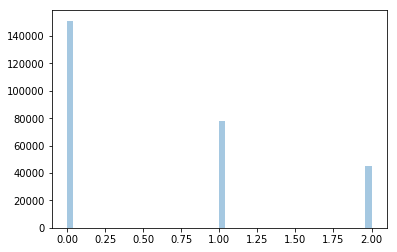

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(y, kde=False, rug=False)

In [7]:
# Pearson-correlation, full dataset with augmented features
x_filt, columns = dp.get_feature_selection_x(method='pearson', threshold = 0.8, 
                                            heldout_cols = ['Density'])

Feature columns used: ['Da', 'Sphericity', 'Ellipse Ratio', 'Concavity', 'Convexity', 'Extent', 'Transparency', 'Curvature', 'L/W Ratio', 'Fiber Length', 'MinSize']


In [8]:
# MIC correlation, full dataset with augmented features 
x_filt_mic, columns_mic = dp.get_feature_selection_x(method='mic', threshold = 0.8, 
                                            heldout_cols = ['Density'])

Feature columns used: ['Da', 'Sphericity', 'Compactness', 'Ellipse Ratio', 'Solidity', 'Convexity', 'Extent', 'Transparency', 'Curvature', 'Fiber Length', 'Fiber Width', 'MinSize']


#### Optional: Steps to visualize the linear (and nonlinear) correlation matrices:
We can use the *DataPreprocessor*'s ```visualize_correlation(...)``` function to save the Pearson (or MIC) based correlation matrices to a .pdf.  

Specify the following parameters: 
* ```output_file``` Specify a **.pdf** filename to save your results to. 
* ```method``` Specify the method (either *'pearson'* or *'mic'*) (default: 'pearson').
* ```threshold``` Specify the threshold (default: 0.8).

If you run the cell below, you should see 2 new *.pdf* files:
* *PearsonCorrelation_for_Augmented_Data.pdf*
* *MICCorrelation_for_Augmented_Data.pdf*

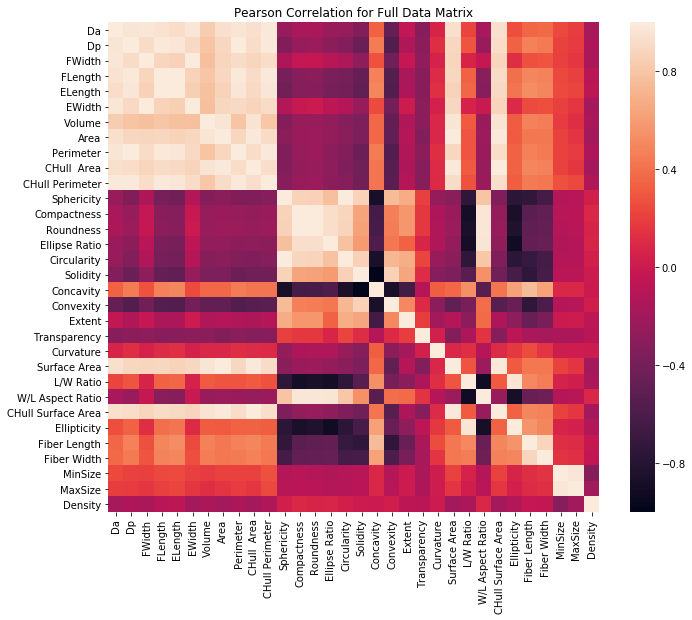

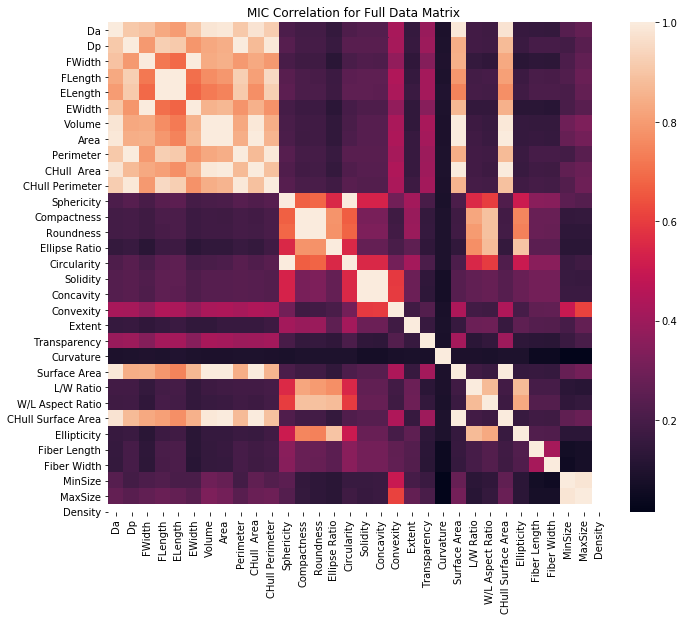

In [ ]:
# Pearson correlation with a threshold of 0.8
dp.visualize_correlation(output_file = '../MicrotracMinMax/PearsonCorrelation_for_Augmented_Data.pdf', )
# MIC-correlation with a threshold of 0.8
dp.visualize_correlation(output_file = '../MicrotracMinMax/MICCorrelation_for_Augmented_Data.pdf', 
                        method = 'mic', threshold = 0.8)


### Step 4: Prepare the Processed Data for Training and Testing
Use the *DataPreprocessor* to grab the:
* **Classification Target Values**
* **List of Sample Names** corresponding to each row of the X-data (*x_filt* and *x_filt_mic* above). 

Each sample name is a material and size range.  


In [ ]:
y_class = dp.get_classification_y()
all_samples = dp.get_samples()

## Training and Testing  
Model training and testing is done by the *TrainTestPipeline* class. It relies on helper functions in the *training_utils.py* and *test_utils.py* files to:
 - Split the data into training and test sets (5 samples are used for train, 3 are held out)
 - Train a (DecisionTreeClassifier) model and test it 
 - Visualize the model test performance and save it to a .pdf file 
 - Visualize the internals of the trained DecisionTreeClassifier, save them to a .png file 
 - Save feature importance rankings to a .csv file

### Step 5: Initialize a TrainTestPipeline 
A TrainTestPipeline comprises of 4-5 parameters:  
```x_data``` Input the **X-data object** (*x_filt* or *x_filt_mic*).  
```y_data```Input the **Regression target values** (*y_reg*).    
```all_samples```Input the **List of Sample Names** (*all_samples*).  
```model_name```Specify the **model type** ("DecisionTreeRegressor").   
* See the OneDrive folder for a full list of supported models.  

```heldout_samples```  Specify a list of **held-out test samples** (optional).   
In this example, we will use our best train set to train our DecisionTree. The heldout samples are: 
* SS-17-4 (10-45)
* SS-17-4 (64-150) 
* Ti-5Al-5V-5Mo-3Cr (0-75)


*By default, ```heldout_samples``` is 'random', meaning that 3 random samples from the 8 samples will be selected for testing.* 

In [ ]:
# DecisionTreeRegressor trained on the best train set for augmented data 
# filtered by Pearson correlationheldout_samples = ['SS-17-4 (10-45)', 
#                                                 'SS-17-4 (64-150)', 
#                                                 'Ti-5Al-5V-5Mo-3Cr (0-75)'
pipeline = TrainTestPipeline(x_data = x_filt_mic, y_data = y_class, all_samples = all_samples, 
                             model_name = 'DecisionTreeClassifier', 
                             heldout_samples = 'random', num_heldout = 4)

### Step 6: Split Data, Train, and Test a Model
To train our DecisionTreeRegressor on the Pearson correlation matrix filtered features (Density, MinSize, MaxSize are included) we will use:  
```
do_train_test(...)
```

We will use Leave One Out cross-validation to test our cross-validation accuracy as we learn from the 5 train samples.  

LOOCV runs for 5 rounds; each train sample has a chance to be a test sample. The final model is trained on all 5 samples.  

With ```cv = False```, we directly train on the 5 samples without looking at cross-validation scores.

In [ ]:
tr_test_ = pipeline.do_train_test(cv = True)

Train Set Proportion: 0.793542
Test Set Proportion: 0.206458
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Training on ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Validating o

F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Average Validation Score: 0.43
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.99491381746256
F1 Test Micro: 0.99491381746256
Recall Macro: 0.6635071090047394
Recall Micro: 0.99491381746256
Precision Macro: 0.6666666666666666
Precision Micro: 0.99491381746256


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Step 7: Visualizing Model Performance, Tree Structure, and Feature Importances
We can save a .pdf visualizing our model's predictions on the heldout test data above: 


Our Pipeline has a built-in function ```visualize_performance(...)``` for visualizing test performance.

#### Steps to visualize our test performance:
1. ```model``` Get the trained model from our *tr_test_* object above.
2. ```train_test_split``` Get the data_split used for training and test, again from *tr_test_* above.
2. ```output_file``` Specify a **.pdf** filename to which the pdf of the test performance will be saved.

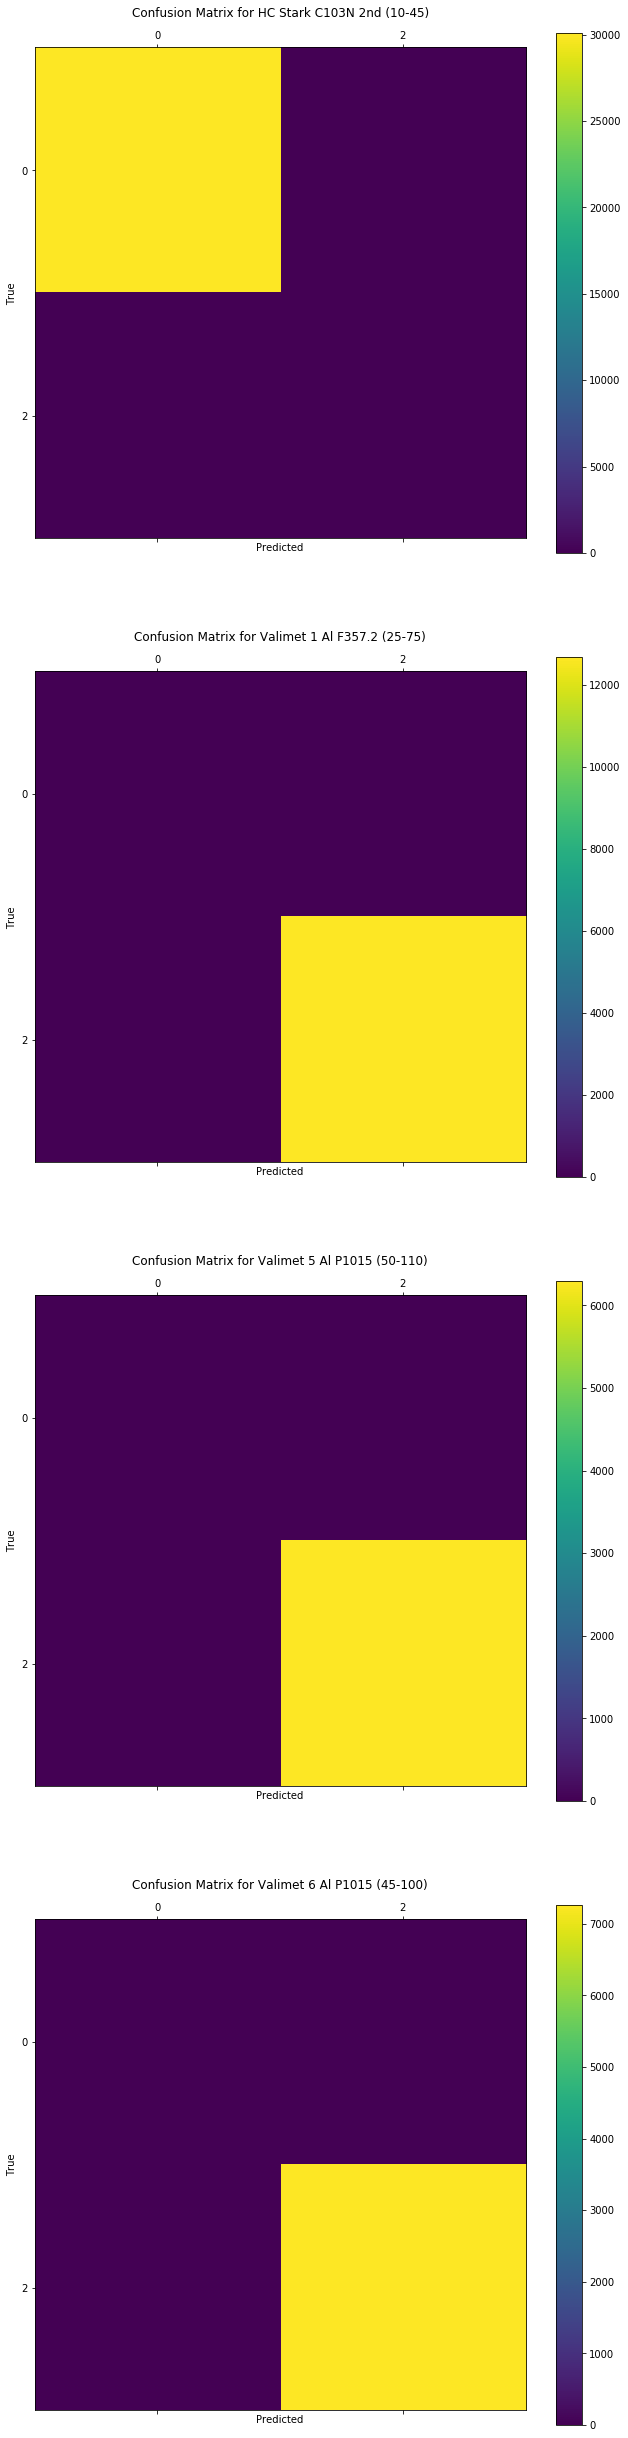

In [ ]:
#visualize results
model_ = tr_test_['model']
data_split = tr_test_['train_test_split']
pipeline.visualize_performance(model = model_, train_test_split = data_split, 
                               output_file = '../MicrotracMinMax/DTClassifyViz_Pearson_WithAugmentedData.pdf')

Check your files. There should now be a *DTClassifyViz_Pearson_WithAugmentedData.pdf* saved visualizing the predictions (via markers) versus true mean flow values (dashed-lines). Each sample is color-coded.

#### Steps to visualize the internals of our tree, and see feature importance rankings:
We will use a function called ```trained_tree_to_png(...)```. It requires the following:
1. ```model``` Get the trained model from our *tr_test_* object above.
2. ```feature_names``` List of names of the *columns* we used to train our model. We got these columns after running **Step 2**.
3. ```all_y_data``` **(New) Different from regression**... To better visualize classes, pass a list of strings (class names), as shown below. 
4. ```outfile_name``` Specify a **.png** filename to which to save the tree to. 

In this function, the DecisionTree's feature importance rankings are saved to a csv file named

```outfile_name``` *\_feature\_importances.csv* 

**New: Different from regression**  
```class_names``` : A list, in increasing order from Class 0 to Class x, of (x+1) strings (class names)  
In this example, we just did a binary classification (whether the flow was greater than 15 or not, so we have two class names: "LowFlow" and "HighFlow". These names are arbitrary. 

In [ ]:
class_names = []
for c in y_class:
    names = {0: "LowFlow", 1: "MediumFlow", 2: "HighFlow"}
    class_names.append(names[c])
    
pipeline.trained_tree_to_png(model_, feature_names=columns_mic, 
                             all_y_data = class_names, 
                             outfile_name = '../MicrotracMinMax/ClassifyBestTrainSetTree.png')


Feature Importances
     feature_name     score
11        MinSize  0.371788
5       Convexity  0.131309
7    Transparency  0.126222
0              Da  0.121049
1      Sphericity  0.088564
6          Extent  0.061155
4        Solidity  0.042349
3   Ellipse Ratio  0.027551
2     Compactness  0.021354
9    Fiber Length  0.004994
10    Fiber Width  0.002838
8       Curvature  0.000828


Check your files. There should now be a *BestTrainSetTree_WithAugmentedData.png* saved visualizing the internals of each tree. There should also be a *BestTrainSetTree_WithAugmentedData_feature_importances.csv* file with feature importances, as printed in when running the cell above.

In [ ]:
features_ = pd.read_csv('../MicrotracMinMax/ClassifyBestTrainSetTree_feature_importances.csv')
features_.head(10)

,feature_name,score
0,MinSize,0.371788
1,Convexity,0.131309
2,Transparency,0.126222
3,Da,0.121049
4,Sphericity,0.088564
5,Extent,0.061155
6,Solidity,0.042349
7,Ellipse Ratio,0.027551
8,Compactness,0.021354
9,Fiber Length,0.004994


## Finding the Best Train/Test Set
Use the TrainTestPipeline's ```exhaustive_train(...)``` method to run all 56 combinations of train/test set ups.   
Specify an ```outfile_name```, a *.csv* file to which to save test results. There will be 56 rows; the 3 samples held out for testing will be indicated in each row as well as the F1-score achieved by the model for that train-test split.

After running this, you should see a new *ClassifyExhaustiveTrainTest.csv* file. 

In [ ]:
pipeline.exhaustive_train('../MicrotracMinMax/ClassifyExhaustiveTrainTest.csv', cv = False)

Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)'], 4 of 1330
Train Set Proportion: 0.714396
Test Set Proportion: 0.285604
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.823301119607818
F1 Test Micro: 0.823301119607818
Recall Macro: 0.596394228328307
Recall Micro: 0.8233011196078182
Precision Macro: 0.66666666666666

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.819878
Test Set Proportion: 0.180122
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.98
F1 Validation, Macro: 0.98
Classification Performance
F1 Test Macro: 0.9805469524908402
F1 Test Micro: 0.9805469524908402
Recall Macro: 0.6579439421994699
Recall Micro: 0.9805469524908402
Precision Macro: 0.6666666666666666
Precision Micro: 0.9805469524908402
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.858932
Test Set Proportion: 0.141068
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.90
F1 Validation, Macro: 0.90
Classification Performance
F1 Test Macro: 0.8965882657017317
F1 Test Micro: 0.8965882657017317
Recall Macro: 0.5881887944231338
Recall Micro: 0.8965882657017317
Precision Macro: 0.6259955060960206
Precision Micro: 0.8965882657017317
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.787960
Test Set Proportion: 0.212040
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6126902244003095
F1 Test Micro: 0.6126902244003095
Recall Macro: 0.6666666666666666
Recall Micro: 0.6126902244003095
Precision Macro: 0.5015758535262471
Precision Micro: 0.6126902244003095
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.843592
Test Set Proportion: 0.156408
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.98
F1 Validation, Macro: 0.98
Classification Performance
F1 Test Macro: 0.9773876961092851
F1 Test Micro: 0.9773876961092851
Recall Macro: 0.6525805233655717
Recall Micro: 0.977387696109285
Precision Macro: 0.6666666666666666
Precision Micro: 0.977387696109285
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.773543
Test Set Proportion: 0.226457
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.7171424431241848
F1 Test Micro: 0.7171424431241848
Recall Macro: 0.7771982375199983
Recall Micro: 0.7171424431241848
Precision Macro: 0.829827215420108
Precision Micro: 0.7171424431241848
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.759301
Test Set Proportion: 0.240699
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.98
F1 Validation, Macro: 0.98
Classification Performance
F1 Test Macro: 0.9787018101946527
F1 Test Micro: 0.9787018101946527
Recall Macro: 0.6578799355056432
Recall Micro: 0.9787018101946527
Precision Macro: 0.6666666666666666
Precision Micro: 0.9787018101946527
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.757832
Test Set Proportion: 0.242168
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.56
F1 Validation, Macro: 0.56
Classification Performance
F1 Test Macro: 0.5563702610738053
F1 Test Micro: 0.5563702610738053
Recall Macro: 0.4839073829416398
Recall Micro: 0.5563702610738053
Precision Macro: 0.6666666666666666
Precision Micro: 0.5563702610738053
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.851107
Test Set Proportion: 0.148893
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.848418062493878
F1 Test Micro: 0.848418062493878
Recall Macro: 0.5933922842903986
Recall Micro: 0.848418062493878
Precision Macro: 0.5696417253849309
Precision Micro: 0.848418062493878
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', 'I-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.858902
Test Set Proportion: 0.141098
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9489120884800248
F1 Test Micro: 0.9489120884800248
Recall Macro: 0.8752451245752871
Recall Micro: 0.9489120884800248
Precision Macro: 0.879036565169483
Precision Micro: 0.9489120884800248
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.858355
Test Set Proportion: 0.141645
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9652234349258649
F1 Test Micro: 0.9652234349258649
Recall Macro: 0.9006415564795397
Recall Micro: 0.9652234349258649
Precision Macro: 0.9325312744697861
Precision Micro: 0.9652234349258649
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.854720
Test Set Proportion: 0.145280
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.98
F1 Validation, Macro: 0.98
Classification Performance
F1 Test Macro: 0.976408583260133
F1 Test Micro: 0.976408583260133
Recall Macro: 0.6530161772821005
Recall Micro: 0.976408583260133
Precision Macro: 0.6666666666666666
Precision Micro: 0.976408583260133
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)', 'Va

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.853054
Test Set Proportion: 0.146946
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.98
F1 Validation, Macro: 0.98
Classification Performance
F1 Test Macro: 0.9759565282119994
F1 Test Micro: 0.9759565282119994
Recall Macro: 0.6525950451627893
Recall Micro: 0.9759565282119994
Precision Macro: 0.6666666666666666
Precision Micro: 0.9759565282119994
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103H (10-45)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.859573
Test Set Proportion: 0.140427
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.94
F1 Validation, Macro: 0.94
Classification Performance
F1 Test Macro: 0.9383341122708625
F1 Test Micro: 0.9383341122708625
Recall Macro: 0.6360258543948601
Recall Micro: 0.9383341122708625
Precision Macro: 0.6666666666666666
Precision Micro: 0.9383341122708625
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.747882
Test Set Proportion: 0.252118
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.86
F1 Validation, Macro: 0.86
Classification Performance
F1 Test Macro: 0.8628573907761725
F1 Test Micro: 0.8628573907761725
Recall Macro: 0.6106900419101587
Recall Micro: 0.8628573907761725
Precision Macro: 0.6666666666666666
Precision Micro: 0.8628573907761725
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.786935
Test Set Proportion: 0.213065
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7885036621260867
F1 Test Micro: 0.7885036621260867
Recall Macro: 0.5292687957862102
Recall Micro: 0.7885036621260867
Precision Macro: 0.6386991780721724
Precision Micro: 0.7885036621260867
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.715963
Test Set Proportion: 0.284037
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.7108637886548311
F1 Test Micro: 0.7108637886548311
Recall Macro: 0.6666666666666666
Recall Micro: 0.7108637886548311
Precision Macro: 0.5515556645815446
Precision Micro: 0.7108637886548311
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.771596
Test Set Proportion: 0.228404
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8544769567230177
F1 Test Micro: 0.8544769567230177
Recall Macro: 0.595503512880562
Recall Micro: 0.8544769567230177
Precision Macro: 0.6666666666666666
Precision Micro: 0.8544769567230177
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.701547
Test Set Proportion: 0.298453
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.7409443528190093
F1 Test Micro: 0.7409443528190093
Recall Macro: 0.7726062542370172
Recall Micro: 0.7409443528190093
Precision Macro: 0.7825916148241171
Precision Micro: 0.7409443528190093
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.687305
Test Set Proportion: 0.312695
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.8436935203647346
F1 Test Micro: 0.8436935203647346
Recall Macro: 0.6055269735281776
Recall Micro: 0.8436935203647346
Precision Macro: 0.6666666666666666
Precision Micro: 0.8436935203647346
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.685836
Test Set Proportion: 0.314164
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.57
F1 Validation, Macro: 0.57
Classification Performance
F1 Test Macro: 0.5692864769509308
F1 Test Micro: 0.5692864769509308
Recall Macro: 0.4983285025469357
Recall Micro: 0.5692864769509308
Precision Macro: 0.6666666666666666
Precision Micro: 0.5692864769509308
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.779111
Test Set Proportion: 0.220889
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7596480802878742
F1 Test Micro: 0.7596480802878742
Recall Macro: 0.5653480847510698
Recall Micro: 0.7596480802878743
Precision Macro: 0.5696417253849309
Precision Micro: 0.7596480802878743
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.786906
Test Set Proportion: 0.213094
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.8247895421257956
F1 Test Micro: 0.8247895421257956
Recall Macro: 0.8168648326841574
Recall Micro: 0.8247895421257956
Precision Macro: 0.7172881310516027
Precision Micro: 0.8247895421257956
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.786359
Test Set Proportion: 0.213641
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8273202034337986
F1 Test Micro: 0.8273202034337986
Recall Macro: 0.8399597377029767
Recall Micro: 0.8273202034337986
Precision Macro: 0.7263194132006191
Precision Micro: 0.8273202034337986
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.782724
Test Set Proportion: 0.217276
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8475440922286922
F1 Test Micro: 0.8475440922286922
Recall Macro: 0.5957455113192819
Recall Micro: 0.8475440922286922
Precision Macro: 0.6666666666666666
Precision Micro: 0.8475440922286922
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.781058
Test Set Proportion: 0.218942
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.8447408739674926
F1 Test Micro: 0.8447408739674926
Recall Macro: 0.5938875878220141
Recall Micro: 0.8447408739674926
Precision Macro: 0.6666666666666666
Precision Micro: 0.8447408739674926
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.787577
Test Set Proportion: 0.212423
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8124785444558874
F1 Test Micro: 0.8124785444558874
Recall Macro: 0.5867757716692626
Recall Micro: 0.8124785444558874
Precision Macro: 0.6666666666666666
Precision Micro: 0.8124785444558874
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.892418
Test Set Proportion: 0.107582
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.90
F1 Validation, Macro: 0.90
Classification Performance
F1 Test Macro: 0.8963261709482817
F1 Test Micro: 0.8963261709482817
Recall Macro: 0.9028024911032029
Recall Micro: 0.8963261709482817
Precision Macro: 0.9091152177788342
Precision Micro: 0.8963261709482817
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.877078
Test Set Proportion: 0.122922
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)', 'Ti-Nb-Zr (0-63)'], 44 of 1330
Train Set Proportion: 0.807029
Test Set Proportion: 0.1929

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.791318
Test Set Proportion: 0.208682
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.50
F1 Validation, Macro: 0.50
Classification Performance
F1 Test Macro: 0.5014501869518119
F1 Test Micro: 0.5014501869518119
Recall Macro: 0.4532022652632209
Recall Micro: 0.5014501869518119
Precision Macro: 0.6666666666666666
Precision Micro: 0.5014501869518119
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.884593
Test Set Proportion: 0.115407
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.40
F1 Validation, Macro: 0.40
Classification Performance
F1 Test Macro: 0.40051181599898905
F1 Test Micro: 0.40051181599898905
Recall Macro: 0.5
Recall Micro: 0.400511815998989
Precision Macro: 0.2002559079994945
Precision Micro: 0.400511815998989
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)', 'I-718 (63-150

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.892388
Test Set Proportion: 0.107612
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9647624856000542
F1 Test Micro: 0.9647624856000542
Recall Macro: 0.8869688077382892
Recall Micro: 0.9647624856000542
Precision Macro: 0.9765923925275715
Precision Micro: 0.9647624856000542
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.891841
Test Set Proportion: 0.108159
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9683454692556634
F1 Test Micro: 0.9683454692556634
Recall Macro: 0.9027043829654958
Recall Micro: 0.9683454692556634
Precision Macro: 0.9787205112516147
Precision Micro: 0.9683454692556634
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.888206
Test Set Proportion: 0.111794
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (230-500)', 'Valimet 4 Al P1015 (50-110)'], 56 of 1330
Train Set Proportion: 0.886540
Test Set Propor

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.860499
Test Set Proportion: 0.139501
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.33
F1 Validation, Macro: 0.33
Classification Performance
F1 Test Macro: 0.3313382122320962
F1 Test Micro: 0.3313382122320962
Recall Macro: 0.2685349940688019
Recall Micro: 0.3313382122320962
Precision Macro: 0.3333333333333333
Precision Micro: 0.3313382122320962
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.916132
Test Set Proportion: 0.083868
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8670115642118078
F1 Test Micro: 0.8670115642118078
Recall Macro: 0.43350578210590385
Recall Micro: 0.8670115642118077
Precision Macro: 0.5
Precision Micro: 0.8670115642118077
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)'], 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.846083
Test Set Proportion: 0.153917
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.54
F1 Validation, Macro: 0.54
Classification Performance
F1 Test Macro: 0.5374283413085706
F1 Test Micro: 0.5374283413085706
Recall Macro: 0.39455156128183405
Recall Micro: 0.5374283413085706
Precision Macro: 0.6666666666666666
Precision Micro: 0.5374283413085706
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919665
Test Set Proportion: 0.080335
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.86
F1 Validation, Macro: 0.86
Classification Performance
F1 Test Macro: 0.8611628012526664
F1 Test Micro: 0.8611628012526664
Recall Macro: 0.4305814006263332
Recall Micro: 0.8611628012526664
Precision Macro: 0.5
Precision Micro: 0.8611628012526664
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'HC Stark C103N 2nd (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.831841
Test Set Proportion: 0.168159
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.93
F1 Validation, Macro: 0.93
Classification Performance
F1 Test Macro: 0.9275585429314831
F1 Test Micro: 0.9275585429314831
Recall Macro: 0.5987745938581647
Recall Micro: 0.9275585429314831
Precision Macro: 0.635917694480464
Precision Micro: 0.9275585429314831
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.830371
Test Set Proportion: 0.169629
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.32
F1 Validation, Macro: 0.32
Classification Performance
F1 Test Macro: 0.32115297809685533
F1 Test Micro: 0.32115297809685533
Recall Macro: 0.29304750476054403
Recall Micro: 0.32115297809685533
Precision Macro: 0.4751080217922224
Precision Micro: 0.32115297809685533
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.923647
Test Set Proportion: 0.076353
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8539229263167948
F1 Test Micro: 0.8539229263167948
Recall Macro: 0.9028024911032029
Recall Micro: 0.8539229263167948
Precision Macro: 0.8149201355275895
Precision Micro: 0.8539229263167948
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'I-718 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.872065
Test Set Proportion: 0.127935
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.54
F1 Validation, Macro: 0.54
Classification Performance
F1 Test Macro: 0.5418376652986776
F1 Test Micro: 0.5418376652986776
Recall Macro: 0.37765377593458666
Recall Micro: 0.5418376652986776
Precision Macro: 0.6666666666666666
Precision Micro: 0.5418376652986776
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Ti-N

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.930107
Test Set Proportion: 0.069893
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.70
F1 Validation, Macro: 0.70
Classification Performance
F1 Test Macro: 0.7031144034639262
F1 Test Micro: 0.7031144034639262
Recall Macro: 0.34630953528639585
Recall Micro: 0.7031144034639262
Precision Macro: 0.6666666666666666
Precision Micro: 0.7031144034639262
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.917733
Test Set Proportion: 0.082267
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'SS-17-4 (64-150)'], 69 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.930895
Test Set Proportion: 0.069105
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7896375244024693
F1 Test Micro: 0.7896375244024693
Recall Macro: 0.5057124886289511
Recall Micro: 0.7896375244024693
Precision Macro: 0.6666666666666666
Precision Micro: 0.7896375244024693
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.933513
Test Set Proportion: 0.066487
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.70
F1 Validation, Macro: 0.70
Classification Performance
F1 Test Macro: 0.6952015355086373
F1 Test Micro: 0.6952015355086373
Recall Macro: 0.2685349940688019
Recall Micro: 0.6952015355086373
Precision Macro: 0.3333333333333333
Precision Micro: 0.6952015355086373
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.927260
Test Set Proportion: 0.072740
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8466666666666667
F1 Test Micro: 0.8466666666666667
Recall Macro: 0.42333333333333334
Recall Micro: 0.8466666666666667
Precision Macro: 0.5
Precision Micro: 0.8466666666666667
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Valimet 4 Al P1015 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.925594
Test Set Proportion: 0.074406
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8501004557259764
F1 Test Micro: 0.8501004557259764
Recall Macro: 0.4250502278629882
Recall Micro: 0.8501004557259764
Precision Macro: 0.5
Precision Micro: 0.8501004557259764
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-64 (150-350)', 'Ti-5Al-5V-5Mo-3Cr (0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.932113
Test Set Proportion: 0.067887
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.73
F1 Validation, Macro: 0.73
Classification Performance
F1 Test Macro: 0.7329072452870723
F1 Test Micro: 0.7329072452870723
Recall Macro: 0.38057106760331455
Recall Micro: 0.7329072452870723
Precision Macro: 0.4135220125786163
Precision Micro: 0.7329072452870723
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.845160
Test Set Proportion: 0.154840
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.47
F1 Validation, Macro: 0.47
Classification Performance
F1 Test Macro: 0.4696116984953022
F1 Test Micro: 0.4696116984953022
Recall Macro: 0.3333333333333333
Recall Micro: 0.4696116984953022
Precision Macro: 0.3333333333333333
Precision Micro: 0.4696116984953022
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.775111
Test Set Proportion: 0.224889
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.29
F1 Validation, Macro: 0.29
Classification Performance
F1 Test Macro: 0.29483292530683053
F1 Test Micro: 0.29483292530683053
Recall Macro: 0.3708011917880903
Recall Micro: 0.29483292530683053
Precision Macro: 0.6666666666666666
Precision Micro: 0.29483292530683053
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.848693
Test Set Proportion: 0.151307
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.46
F1 Validation, Macro: 0.46
Classification Performance
F1 Test Macro: 0.4572268543062316
F1 Test Micro: 0.4572268543062316
Recall Macro: 0.3333333333333333
Recall Micro: 0.4572268543062316
Precision Macro: 0.3333333333333333
Precision Micro: 0.4572268543062316
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'HC St

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.760869
Test Set Proportion: 0.239131
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6565678127620646
F1 Test Micro: 0.6565678127620646
Recall Macro: 0.6666666666666666
Recall Micro: 0.6565678127620646
Precision Macro: 0.5247599606864747
Precision Micro: 0.6565678127620646
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.759400
Test Set Proportion: 0.240600
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.23
F1 Validation, Macro: 0.23
Classification Performance
F1 Test Macro: 0.22779899375644055
F1 Test Micro: 0.22779899375644055
Recall Macro: 0.35883110836825066
Recall Micro: 0.22779899375644055
Precision Macro: 0.3648860484746172
Precision Micro: 0.22779899375644055
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.860470
Test Set Proportion: 0.139530
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.38
F1 Validation, Macro: 0.38
Classification Performance
F1 Test Macro: 0.38483850736908126
F1 Test Micro: 0.38483850736908126
Recall Macro: 0.3600354291222174
Recall Micro: 0.3848385073690812
Precision Macro: 0.6666666666666666
Precision Micro: 0.3848385073690812
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'Inc

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.801093
Test Set Proportion: 0.198907
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.35
F1 Validation, Macro: 0.35
Classification Performance
F1 Test Macro: 0.34784521474529356
F1 Test Micro: 0.34784521474529356
Recall Macro: 0.38347342949024105
Recall Micro: 0.34784521474529356
Precision Macro: 0.6666666666666666
Precision Micro: 0.34784521474529356
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.859136
Test Set Proportion: 0.140864
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.35
F1 Validation, Macro: 0.35
Classification Performance
F1 Test Macro: 0.3507014546772273
F1 Test Micro: 0.3507014546772273
Recall Macro: 0.3445313402935624
Recall Micro: 0.3507014546772273
Precision Macro: 0.6666666666666666
Precision Micro: 0.3507014546772273
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.846761
Test Set Proportion: 0.153239
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'SS-17-4 (64-150)'], 84 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.859923
Test Set Proportion: 0.140077
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.39
F1 Validation, Macro: 0.39
Classification Performance
F1 Test Macro: 0.3905981571138529
F1 Test Micro: 0.3905981571138529
Recall Macro: 0.3634927417997229
Recall Micro: 0.3905981571138529
Precision Macro: 0.6666666666666666
Precision Micro: 0.3905981571138529
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.862541
Test Set Proportion: 0.137459
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.34
F1 Validation, Macro: 0.34
Classification Performance
F1 Test Macro: 0.3362599469496021
F1 Test Micro: 0.3362599469496021
Recall Macro: 0.3333333333333333
Recall Micro: 0.3362599469496021
Precision Macro: 0.3333333333333333
Precision Micro: 0.3362599469496021
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.854622
Test Set Proportion: 0.145378
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.44
F1 Validation, Macro: 0.44
Classification Performance
F1 Test Macro: 0.43509229534510435
F1 Test Micro: 0.43509229534510435
Recall Macro: 0.3333333333333333
Recall Micro: 0.43509229534510435
Precision Macro: 0.3333333333333333
Precision Micro: 0.43509229534510435
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (10-45)', 'T

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.861141
Test Set Proportion: 0.138859
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.36
F1 Validation, Macro: 0.36
Classification Performance
F1 Test Macro: 0.3587333263312677
F1 Test Micro: 0.3587333263312677
Recall Macro: 0.4472193317146491
Recall Micro: 0.3587333263312677
Precision Macro: 0.3472996157499964
Precision Micro: 0.3587333263312677
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.904326
Test Set Proportion: 0.095674
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd (10-45)'], 91 of 1330
Train Set Proportion: 0.816502
Test Set Pr

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.815032
Test Set Proportion: 0.184968
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.44
F1 Validation, Macro: 0.44
Classification Performance
F1 Test Macro: 0.4384387936132466
F1 Test Micro: 0.4384387936132466
Recall Macro: 0.35822479184937367
Recall Micro: 0.4384387936132466
Precision Macro: 0.6666666666666666
Precision Micro: 0.4384387936132466
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.908307
Test Set Proportion: 0.091693
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7930252902815333
F1 Test Micro: 0.7930252902815333
Recall Macro: 0.5
Recall Micro: 0.7930252902815333
Precision Macro: 0.3965126451407667
Precision Micro: 0.7930252902815333
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-100)', 'I-718 (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.916103
Test Set Proportion: 0.083897
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9556714471968709
F1 Test Micro: 0.9556714471968709
Recall Macro: 0.5558091511792197
Recall Micro: 0.9556714471968709
Precision Macro: 0.6666666666666666
Precision Micro: 0.9556714471968709
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.856726
Test Set Proportion: 0.143274
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Inconel 718 (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.67
F1 Validation, Macro: 0.67
Classification Performance
F1 Test Macro: 0.6675403995419265
F1 Test Micro: 0.6675403995419265
Recall Macro: 0.44164255201874053
Recall Micro: 0.6675403995419265
Precision Macro: 0.6666666666666666
Precision Micro: 0.6675403995419265
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.914768
Test Set Proportion: 0.085232
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.89
F1 Validation, Macro: 0.89
Classification Performance
F1 Test Macro: 0.8902292950034223
F1 Test Micro: 0.8902292950034223
Recall Macro: 0.41751626371492384
Recall Micro: 0.8902292950034223
Precision Macro: 0.6666666666666666
Precision Micro: 0.8902292950034223
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.902393
Test Set Proportion: 0.097607
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.27
F1 Validation, Macro: 0.27
Classification Performance
F1 Test Macro: 0.27142323496451254
F1 Test Micro: 0.27142323496451254
Recall Macro: 0.09047441165483751
Recall Micro: 0.27142323496451254
Precision Macro: 0.3333333333333333
Precision Micro: 0.27142323496451254
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.915556
Test Set Proportion: 0.084444
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9589810017271158
F1 Test Micro: 0.9589810017271158
Recall Macro: 0.5682312713708424
Recall Micro: 0.9589810017271158
Precision Macro: 0.6666666666666666
Precision Micro: 0.9589810017271158
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.918174
Test Set Proportion: 0.081826
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.89
F1 Validation, Macro: 0.89
Classification Performance
F1 Test Macro: 0.888646288209607
F1 Test Micro: 0.888646288209607
Recall Macro: 0.3333333333333333
Recall Micro: 0.888646288209607
Precision Macro: 0.3333333333333333
Precision Micro: 0.888646288209607
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-100)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.911921
Test Set Proportion: 0.088079
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 6 Al P1015 (45-100)', 'Valimet 4 Al P1015 (50-110)'], 101 of 1330
Train Set Proportion: 0.910254
Test Set 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.834276
Test Set Proportion: 0.165724
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.63
F1 Validation, Macro: 0.63
Classification Performance
F1 Test Macro: 0.632931444160873
F1 Test Micro: 0.632931444160873
Recall Macro: 0.45663066193317725
Recall Micro: 0.632931444160873
Precision Macro: 0.6666666666666666
Precision Micro: 0.632931444160873
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', 'HC Stark

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.746452
Test Set Proportion: 0.253548
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.75
F1 Validation, Macro: 0.75
Classification Performance
F1 Test Macro: 0.7494355685298896
F1 Test Micro: 0.7494355685298896
Recall Macro: 0.7812209921927495
Recall Micro: 0.7494355685298897
Precision Macro: 0.8671055189954027
Precision Micro: 0.7494355685298897
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.786676
Test Set Proportion: 0.213324
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.28
F1 Validation, Macro: 0.28
Classification Performance
F1 Test Macro: 0.27991522381937206
F1 Test Micro: 0.27991522381937206
Recall Macro: 0.36024438140955706
Recall Micro: 0.27991522381937206
Precision Macro: 0.6666666666666666
Precision Micro: 0.27991522381937206
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.844719
Test Set Proportion: 0.155281
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.55
F1 Validation, Macro: 0.55
Classification Performance
F1 Test Macro: 0.5485817601202216
F1 Test Micro: 0.5485817601202216
Recall Macro: 0.45241995698349546
Recall Micro: 0.5485817601202216
Precision Macro: 0.6666666666666666
Precision Micro: 0.5485817601202216
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.832344
Test Set Proportion: 0.167656
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.21
F1 Validation, Macro: 0.21
Classification Performance
F1 Test Macro: 0.20586316384672262
F1 Test Micro: 0.20586316384672262
Recall Macro: 0.11916811440944684
Recall Micro: 0.20586316384672262
Precision Macro: 0.20437420385603558
Precision Micro: 0.20586316384672262
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.845507
Test Set Proportion: 0.154493
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5784244312281696
F1 Test Micro: 0.5784244312281696
Recall Macro: 0.46615030588763534
Recall Micro: 0.5784244312281696
Precision Macro: 0.6666666666666666
Precision Micro: 0.5784244312281696
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', 'Ti-N

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.848124
Test Set Proportion: 0.151876
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.53
F1 Validation, Macro: 0.53
Classification Performance
F1 Test Macro: 0.5281605608104863
F1 Test Micro: 0.5281605608104863
Recall Macro: 0.45070121106830824
Recall Micro: 0.5281605608104863
Precision Macro: 0.5962048158799977
Precision Micro: 0.5281605608104863
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.840205
Test Set Proportion: 0.159795
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.62
F1 Validation, Macro: 0.62
Classification Performance
F1 Test Macro: 0.616346461004883
F1 Test Micro: 0.616346461004883
Recall Macro: 0.45499408313820283
Recall Micro: 0.616346461004883
Precision Macro: 0.6666666666666666
Precision Micro: 0.616346461004883
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (0-63)', 'Ti-5Al-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.846724
Test Set Proportion: 0.153276
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.7062895475522146
F1 Test Micro: 0.7062895475522146
Recall Macro: 0.7230889552952382
Recall Micro: 0.7062895475522146
Precision Macro: 0.6869593822917999
Precision Micro: 0.7062895475522146
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.818565
Test Set Proportion: 0.181435
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.43
F1 Validation, Macro: 0.43
Classification Performance
F1 Test Macro: 0.42752356262936836
F1 Test Micro: 0.42752356262936836
Recall Macro: 0.3582356189300679
Recall Micro: 0.42752356262936836
Precision Macro: 0.6666666666666666
Precision Micro: 0.42752356262936836
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.911840
Test Set Proportion: 0.088160
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.78
F1 Validation, Macro: 0.78
Classification Performance
F1 Test Macro: 0.7847305513048514
F1 Test Micro: 0.7847305513048514
Recall Macro: 0.5
Recall Micro: 0.7847305513048514
Precision Macro: 0.3923652756524257
Precision Micro: 0.7847305513048514
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-110)', 'I-718 (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919636
Test Set Proportion: 0.080364
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9538133478517309
F1 Test Micro: 0.9538133478517309
Recall Macro: 0.556026518856646
Recall Micro: 0.9538133478517309
Precision Macro: 0.6666666666666666
Precision Micro: 0.9538133478517309
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.860259
Test Set Proportion: 0.139741
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.658691227887074
F1 Test Micro: 0.658691227887074
Recall Macro: 0.44134973129392313
Recall Micro: 0.658691227887074
Precision Macro: 0.6666666666666666
Precision Micro: 0.658691227887074
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-110)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.918301
Test Set Proportion: 0.081699
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8840094613290489
F1 Test Micro: 0.8840094613290489
Recall Macro: 0.41431206913292556
Recall Micro: 0.884009461329049
Precision Macro: 0.6666666666666666
Precision Micro: 0.884009461329049
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.905926
Test Set Proportion: 0.094074
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.24
F1 Validation, Macro: 0.24
Classification Performance
F1 Test Macro: 0.24406030774001006
F1 Test Micro: 0.24406030774001006
Recall Macro: 0.0813534359133367
Recall Micro: 0.24406030774001009
Precision Macro: 0.3333333333333333
Precision Micro: 0.24406030774001009
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919089
Test Set Proportion: 0.080911
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9606146636023614
F1 Test Micro: 0.9606146636023614
Recall Macro: 0.5761061029945084
Recall Micro: 0.9606146636023614
Precision Macro: 0.6666666666666666
Precision Micro: 0.9606146636023614
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.921707
Test Set Proportion: 0.078293
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8836212918548876
F1 Test Micro: 0.8836212918548876
Recall Macro: 0.3333333333333333
Recall Micro: 0.8836212918548876
Precision Macro: 0.3333333333333333
Precision Micro: 0.8836212918548876
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.915454
Test Set Proportion: 0.084546
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 5 Al P1015 (50-110)', 'Valimet 4 Al P1015 (50-110)'], 126 of 1330
Train Set Proportion: 0.913787
Test Set 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.730741
Test Set Proportion: 0.269259
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6094680966309176
F1 Test Micro: 0.6094680966309176
Recall Macro: 0.5095115877349289
Recall Micro: 0.6094680966309176
Precision Macro: 0.6666666666666666
Precision Micro: 0.6094680966309176
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 2nd (10-45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.824016
Test Set Proportion: 0.175984
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.89
F1 Validation, Macro: 0.89
Classification Performance
F1 Test Macro: 0.8862967720548627
F1 Test Micro: 0.8862967720548627
Recall Macro: 0.6152650163440014
Recall Micro: 0.8862967720548627
Precision Macro: 0.5696417253849309
Precision Micro: 0.8862967720548627
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 2nd (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.831812
Test Set Proportion: 0.168188
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'I-718 (63-150)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9714273326396116
F1 Test Micro: 0.9714273326396116
Recall Macro: 0.8859709331397513
Recall Micro: 0.9714273326396116
Precision Macro: 0.9466140879069272
Precision Micro: 0.9714273326396116
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 2nd (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.831265
Test Set Proportion: 0.168735
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (64-150)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.97311897661956
F1 Test Micro: 0.97311897661956
Recall Macro: 0.8990803870782789
Recall Micro: 0.97311897661956
Precision Macro: 0.9508152929649883
Precision Micro: 0.97311897661956
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 2nd (10-45)', 'Ti

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.827630
Test Set Proportion: 0.172370
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.9939714436805923
F1 Test Micro: 0.9939714436805923
Recall Macro: 0.6635400210637178
Recall Micro: 0.9939714436805923
Precision Macro: 0.6666666666666666
Precision Micro: 0.9939714436805923
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 2nd (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.825963
Test Set Proportion: 0.174037
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.9936520573200369
F1 Test Micro: 0.9936520573200369
Recall Macro: 0.6633425487098473
Recall Micro: 0.9936520573200369
Precision Macro: 0.6666666666666666
Precision Micro: 0.9936520573200369
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark C103N 2nd (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.832483
Test Set Proportion: 0.167517
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9523332752916595
F1 Test Micro: 0.9523332752916595
Recall Macro: 0.6447229987675475
Recall Micro: 0.9523332752916595
Precision Macro: 0.6666666666666666
Precision Micro: 0.9523332752916595
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (0-63)', 'HC Stark

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.822547
Test Set Proportion: 0.177453
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.31
F1 Validation, Macro: 0.31
Classification Performance
F1 Test Macro: 0.307197600115063
F1 Test Micro: 0.307197600115063
Recall Macro: 0.35439356894124624
Recall Micro: 0.307197600115063
Precision Macro: 0.5696417253849309
Precision Micro: 0.307197600115063
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (0-63)', 'I-718 (63-15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.830342
Test Set Proportion: 0.169658
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.37
F1 Validation, Macro: 0.37
Classification Performance
F1 Test Macro: 0.36599256409705355
F1 Test Micro: 0.36599256409705355
Recall Macro: 0.5809721127761575
Recall Micro: 0.36599256409705355
Precision Macro: 0.5868893383317507
Precision Micro: 0.36599256409705355
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (0-63)', 'Inco

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.829795
Test Set Proportion: 0.170205
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.37
F1 Validation, Macro: 0.37
Classification Performance
F1 Test Macro: 0.3710931642424113
F1 Test Micro: 0.3710931642424113
Recall Macro: 0.6000201894596421
Recall Micro: 0.37109316424241123
Precision Macro: 0.599684347877134
Precision Micro: 0.37109316424241123
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (0-63)', 'Ti-Nb (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.826160
Test Set Proportion: 0.173840
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.40
F1 Validation, Macro: 0.40
Classification Performance
F1 Test Macro: 0.4024078191199295
F1 Test Micro: 0.4024078191199295
Recall Macro: 0.3581814835265967
Recall Micro: 0.4024078191199295
Precision Macro: 0.6666666666666666
Precision Micro: 0.4024078191199295
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (0-63)', 'Valimet 4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.824494
Test Set Proportion: 0.175506
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.41
F1 Validation, Macro: 0.41
Classification Performance
F1 Test Macro: 0.408081437623351
F1 Test Micro: 0.408081437623351
Recall Macro: 0.3581814835265967
Recall Micro: 0.408081437623351
Precision Macro: 0.6666666666666666
Precision Micro: 0.408081437623351
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (0-63)', 'Ti-5Al-5V-5M

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.831013
Test Set Proportion: 0.168987
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.27
F1 Validation, Macro: 0.27
Classification Performance
F1 Test Macro: 0.27352363691285303
F1 Test Micro: 0.27352363691285303
Recall Macro: 0.3333333333333333
Recall Micro: 0.27352363691285303
Precision Macro: 0.3333333333333333
Precision Micro: 0.27352363691285303
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (170-230

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.923617
Test Set Proportion: 0.076383
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.70
F1 Validation, Macro: 0.70
Classification Performance
F1 Test Macro: 0.7013222588190368
F1 Test Micro: 0.7013222588190368
Recall Macro: 0.5523312683403977
Recall Micro: 0.7013222588190368
Precision Macro: 0.5696417253849309
Precision Micro: 0.7013222588190368
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (170-230)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.923070
Test Set Proportion: 0.076930
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.713066969998578
F1 Test Micro: 0.713066969998578
Recall Macro: 0.5786965081338722
Recall Micro: 0.7130669699985781
Precision Macro: 0.5696417253849309
Precision Micro: 0.7130669699985781
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (170-230)', 'T

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919435
Test Set Proportion: 0.080565
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7644370021723389
F1 Test Micro: 0.7644370021723389
Recall Macro: 0.5
Recall Micro: 0.7644370021723389
Precision Macro: 0.38221850108616945
Precision Micro: 0.7644370021723389
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (170-230)', 'Valimet 4 Al

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.917769
Test Set Proportion: 0.082231
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 Validation, Macro: 0.77
Classification Performance
F1 Test Macro: 0.7692103046157939
F1 Test Micro: 0.7692103046157939
Recall Macro: 0.5
Recall Micro: 0.7692103046157939
Precision Macro: 0.38460515230789694
Precision Micro: 0.7692103046157939
Combo ['Valimet 1 Al F357.2 (25-75)', 'HC Stark TaH (170-230)', 'Ti-5Al-5V-5M

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.924288
Test Set Proportion: 0.075712
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6566819166867325
F1 Test Micro: 0.6566819166867325
Recall Macro: 0.3728569073524563
Recall Micro: 0.6566819166867325
Precision Macro: 0.5696417253849309
Precision Micro: 0.6566819166867325
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'Incone

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.872036
Test Set Proportion: 0.127964
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Inconel 718 (0-63)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.60
F1 Validation, Macro: 0.60
Classification Performance
F1 Test Macro: 0.5967631638933212
F1 Test Micro: 0.5967631638933212
Recall Macro: 0.4562499070728698
Recall Micro: 0.5967631638933212
Precision Macro: 0.6666666666666666
Precision Micro: 0.5967631638933212
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'Ti-Nb-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.930078
Test Set Proportion: 0.069922
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7624237367680035
F1 Test Micro: 0.7624237367680035
Recall Macro: 0.433025641025641
Recall Micro: 0.7624237367680033
Precision Macro: 0.6666666666666666
Precision Micro: 0.7624237367680033
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'Valimet

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.917703
Test Set Proportion: 0.082297
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.09
F1 Validation, Macro: 0.09
Classification Performance
F1 Test Macro: 0.0899827211909087
F1 Test Micro: 0.0899827211909087
Recall Macro: 0.2207368764264754
Recall Micro: 0.0899827211909087
Precision Macro: 0.08308787432498772
Precision Micro: 0.0899827211909087
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'SS-17

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.930866
Test Set Proportion: 0.069134
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8751648119824904
F1 Test Micro: 0.8751648119824904
Recall Macro: 0.5411096965839168
Recall Micro: 0.8751648119824904
Precision Macro: 0.6666666666666666
Precision Micro: 0.8751648119824904
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.933484
Test Set Proportion: 0.066516
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.86
F1 Validation, Macro: 0.86
Classification Performance
F1 Test Macro: 0.8630159513237954
F1 Test Micro: 0.8630159513237954
Recall Macro: 0.6666666666666666
Recall Micro: 0.8630159513237954
Precision Macro: 0.5170080249131632
Precision Micro: 0.8630159513237954
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.927231
Test Set Proportion: 0.072769
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9473394127668104
F1 Test Micro: 0.9473394127668104
Recall Macro: 0.5524399521791109
Recall Micro: 0.9473394127668103
Precision Macro: 0.6666666666666666
Precision Micro: 0.9473394127668103
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.925564
Test Set Proportion: 0.074436
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9513592946362969
F1 Test Micro: 0.9513592946362969
Recall Macro: 0.5587436148244757
Recall Micro: 0.9513592946362969
Precision Macro: 0.6666666666666666
Precision Micro: 0.9513592946362969
Combo ['Valimet 1 Al F357.2 (25-75)', 'I-718 (63-150)', 'Ti-5Al

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.932084
Test Set Proportion: 0.067916
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.8427014548773286
F1 Test Micro: 0.8427014548773286
Recall Macro: 0.6683493247107052
Recall Micro: 0.8427014548773286
Precision Macro: 0.6685476844433067
Precision Micro: 0.8427014548773286
Combo ['Valimet 1 Al F357.2 (25-75)', 'Inconel 718 (0-63)', 'Ti-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.858326
Test Set Proportion: 0.141674
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.16
F1 Validation, Macro: 0.16
Classification Performance
F1 Test Macro: 0.1616224006588429
F1 Test Micro: 0.1616224006588429
Recall Macro: 0.10817142069725783
Recall Micro: 0.1616224006588429
Precision Macro: 0.16934983685246607
Precision Micro: 0.1616224006588429
Combo ['Valimet 1 Al F357.2 (25-75)', 'Inconel 718 (0-63)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.871489
Test Set Proportion: 0.128511
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.60
F1 Validation, Macro: 0.60
Classification Performance
F1 Test Macro: 0.6039550587300686
F1 Test Micro: 0.6039550587300686
Recall Macro: 0.4604989144401613
Recall Micro: 0.6039550587300686
Precision Macro: 0.6666666666666666
Precision Micro: 0.6039550587300686
Combo ['Valimet 1 Al F357.2 (25-75)', 'Inconel 718 (0-63)', 'Ti

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.874107
Test Set Proportion: 0.125893
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.55
F1 Validation, Macro: 0.55
Classification Performance
F1 Test Macro: 0.5496119091751622
F1 Test Micro: 0.5496119091751622
Recall Macro: 0.4418492490009646
Recall Micro: 0.5496119091751622
Precision Macro: 0.5719968178202068
Precision Micro: 0.5496119091751622
Combo ['Valimet 1 Al F357.2 (25-75)', 'Inconel 718 (0-63)', 'Va

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.866187
Test Set Proportion: 0.133813
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.64
F1 Validation, Macro: 0.64
Classification Performance
F1 Test Macro: 0.6445504087193461
F1 Test Micro: 0.6445504087193461
Recall Macro: 0.4419698222405953
Recall Micro: 0.6445504087193461
Precision Macro: 0.6666666666666666
Precision Micro: 0.6445504087193461
Combo ['Valimet 1 Al F357.2 (25-75)', 'Inconel 718 (0-63)', 'Ti

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.872707
Test Set Proportion: 0.127293
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.63
F1 Validation, Macro: 0.63
Classification Performance
F1 Test Macro: 0.627262832263978
F1 Test Micro: 0.627262832263978
Recall Macro: 0.6910373796281041
Recall Micro: 0.627262832263978
Precision Macro: 0.6785656793890272
Precision Micro: 0.627262832263978
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (64-150)', 'Valimet

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.929531
Test Set Proportion: 0.070469
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6559217674755523
F1 Test Micro: 0.6559217674755523
Recall Macro: 0.3333333333333333
Recall Micro: 0.6559217674755523
Precision Macro: 0.3333333333333333
Precision Micro: 0.6559217674755523
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (64-150)', 'Ti-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.932149
Test Set Proportion: 0.067851
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8657101402547155
F1 Test Micro: 0.8657101402547155
Recall Macro: 0.6666666666666666
Recall Micro: 0.8657101402547155
Precision Macro: 0.5262418521015958
Precision Micro: 0.8657101402547155
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (64-150)', 'Val

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.925896
Test Set Proportion: 0.074104
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8725152529029718
F1 Test Micro: 0.8725152529029718
Recall Macro: 0.41508884357704634
Recall Micro: 0.8725152529029718
Precision Macro: 0.6666666666666666
Precision Micro: 0.8725152529029718
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (64-150)', 'Va

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.924230
Test Set Proportion: 0.075770
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8755112843462779
F1 Test Micro: 0.8755112843462779
Recall Macro: 0.41547723079910676
Recall Micro: 0.8755112843462779
Precision Macro: 0.6666666666666666
Precision Micro: 0.8755112843462779
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb-Zr (64-150)', 'Ti

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.930749
Test Set Proportion: 0.069251
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7591744326857263
F1 Test Micro: 0.7591744326857263
Recall Macro: 0.5207030899921686
Recall Micro: 0.7591744326857264
Precision Macro: 0.5180700303700668
Precision Micro: 0.7591744326857264
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 2 AA 2024 (25-75

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919774
Test Set Proportion: 0.080226
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 2 AA 2024 (25-75)', 'Valimet 3 AA 4047 (50-110)'], 181 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.913521
Test Set Proportion: 0.086479
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.18
F1 Validation, Macro: 0.18
Classification Performance
F1 Test Macro: 0.17767096719790876
F1 Test Micro: 0.17767096719790876
Recall Macro: 0.05922365573263625
Recall Micro: 0.17767096719790876
Precision Macro: 0.3333333333333333
Precision Micro: 0.17767096719790876
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 2 AA 2024 (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.911855
Test Set Proportion: 0.088145
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.19
F1 Validation, Macro: 0.19
Classification Performance
F1 Test Macro: 0.1932161323681489
F1 Test Micro: 0.1932161323681489
Recall Macro: 0.06440537745604964
Recall Micro: 0.1932161323681489
Precision Macro: 0.3333333333333333
Precision Micro: 0.1932161323681489
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 2 AA 2024 (25-7

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.918374
Test Set Proportion: 0.081626
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.04
F1 Validation, Macro: 0.04
Classification Performance
F1 Test Macro: 0.04283736096841917
F1 Test Micro: 0.04283736096841917
Recall Macro: 0.11087987050526073
Recall Micro: 0.04283736096841917
Precision Macro: 0.022223767148683723
Precision Micro: 0.04283736096841917
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (64-150)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.932937
Test Set Proportion: 0.067063
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.86
F1 Validation, Macro: 0.86
Classification Performance
F1 Test Macro: 0.8641330941118904
F1 Test Micro: 0.8641330941118904
Recall Macro: 0.6666666666666666
Recall Micro: 0.8641330941118904
Precision Macro: 0.5209353860508514
Precision Micro: 0.8641330941118904
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (64-150)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.926684
Test Set Proportion: 0.073316
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9532524368410583
F1 Test Micro: 0.9532524368410583
Recall Macro: 0.5692674334265879
Recall Micro: 0.9532524368410583
Precision Macro: 0.6666666666666666
Precision Micro: 0.9532524368410583
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (64-150)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.925018
Test Set Proportion: 0.074982
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9539995137369317
F1 Test Micro: 0.9539995137369317
Recall Macro: 0.5686457361931406
Recall Micro: 0.9539995137369317
Precision Macro: 0.6666666666666666
Precision Micro: 0.9539995137369317
Combo ['Valimet 1 Al F357.2 (25-75)', 'SS-17-4 (64-150)', 'Ti-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.931537
Test Set Proportion: 0.068463
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8485913617723811
F1 Test Micro: 0.8485913617723811
Recall Macro: 0.6825753302932777
Recall Micro: 0.8485913617723811
Precision Macro: 0.6850511695906433
Precision Micro: 0.8485913617723811
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (64-150)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.927635
Test Set Proportion: 0.072365
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8740867637426311
F1 Test Micro: 0.8740867637426311
Recall Macro: 0.3333333333333333
Recall Micro: 0.8740867637426312
Precision Macro: 0.3333333333333333
Precision Micro: 0.8740867637426312
Combo ['Valimet 1 Al F357.2 (25-75)', 'Ti-Nb (64-150)', 'Ti-5Al

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.934155
Test Set Proportion: 0.065845
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7558558059693227
F1 Test Micro: 0.7558558059693227
Recall Macro: 0.39359593707419793
Recall Micro: 0.7558558059693228
Precision Macro: 0.6666666666666666
Precision Micro: 0.7558558059693228
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 3 AA 4047 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.921382
Test Set Proportion: 0.078618
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 1 Al F357.2 (25-75)', 'Valimet 3 AA 4047 (50-110)', 'Ti-5Al-5V-5Mo-3Cr (0-75)'], 192 of 1330
Train Set Proportion: 0.927902
Test Set Prop

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.926235
Test Set Proportion: 0.073765
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9055904305274084
F1 Test Micro: 0.9055904305274084
Recall Macro: 0.4458318880795467
Recall Micro: 0.9055904305274084
Precision Macro: 0.6666666666666666
Precision Micro: 0.9055904305274084
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.710410
Test Set Proportion: 0.289590
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (230-500)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8285656728444802
F1 Test Micro: 0.8285656728444802
Recall Macro: 0.4142828364222401
Recall Micro: 0.8285656728444802
Precision Macro: 0.5
Precision Micro: 0.8285656728444802
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 'Ti-64 (150-350

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.749464
Test Set Proportion: 0.250536
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7555338873284532
F1 Test Micro: 0.7555338873284532
Recall Macro: 0.2635787613854449
Recall Micro: 0.7555338873284532
Precision Macro: 0.3147851711718267
Precision Micro: 0.7555338873284532
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.678492
Test Set Proportion: 0.321508
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.7445621356801017
F1 Test Micro: 0.7445621356801017
Recall Macro: 0.5
Recall Micro: 0.7445621356801017
Precision Macro: 0.3722810678400508
Precision Micro: 0.7445621356801017


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-100)'], 197 of 1330
Train Set Proportion: 0.734125
Test Set Proportion: 0.265875
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8078167855183763
F1 Test Micro: 0.8078167855183763
Recall Macro: 0.5955158863130959
Recall Micro: 0.8078167855183763
Precision Macro: 0.666666666

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.664075
Test Set Proportion: 0.335925
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.69
F1 Validation, Macro: 0.69
Classification Performance
F1 Test Macro: 0.6889897104154908
F1 Test Micro: 0.6889897104154908
Recall Macro: 0.6239504966919291
Recall Micro: 0.6889897104154908
Precision Macro: 0.622216571584111
Precision Micro: 0.6889897104154908
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 'V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.649834
Test Set Proportion: 0.350166
Train Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 'Ti-Nb (0-63)'], 201 of 1330
Train Set Proportion: 0.648364
Test Set Proportion: 0.351636
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.55
F1 Validation, Macro: 0.55
Classification Performance
F1 Test Macro: 0.5463029209568544
F1 Test Micro: 0.5463029209568544
Recall Macro: 0.2731514604784272
Recall Micro: 0.5463029209568544
Precision Macro: 0.5
Precision Micro: 0.5463

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)'], 202 of 1330
Train Set Proportion: 0.741639
Test Set Proportion: 0.258361
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.73
F1 Validation, Macro: 0.73
Classification Performance
F1 Test Macro: 0.7287571091886704
F1 Test Micro: 0.7287571091886704
Recall Macro: 0.24291903639622348
Recall Micro: 0.7287571091886704
Precision Macro: 0.3333333333333

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.749435
Test Set Proportion: 0.250565
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7856404883514501
F1 Test Micro: 0.7856404883514501
Recall Macro: 0.7227678847629632
Recall Micro: 0.7856404883514501
Precision Macro: 0.5539494321087596
Precision Micro: 0.7856404883514501
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.748888
Test Set Proportion: 0.251112
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.78
F1 Validation, Macro: 0.78
Classification Performance
F1 Test Macro: 0.7810108754047422
F1 Test Micro: 0.7810108754047422
Recall Macro: 0.7537384122198856
Recall Micro: 0.7810108754047422
Precision Macro: 0.5619648570916689
Precision Micro: 0.7810108754047422
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.745253
Test Set Proportion: 0.254747
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8055189786454457
F1 Test Micro: 0.8055189786454457
Recall Macro: 0.5976787400615348
Recall Micro: 0.8055189786454457
Precision Macro: 0.6666666666666666
Precision Micro: 0.8055189786454457
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.743586
Test Set Proportion: 0.256414
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.7999857803057234
F1 Test Micro: 0.7999857803057234
Recall Macro: 0.5952518759963851
Recall Micro: 0.7999857803057234
Precision Macro: 0.6666666666666666
Precision Micro: 0.7999857803057234
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 1st (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.750106
Test Set Proportion: 0.249894
Train Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.75
F1 Validation, Macro: 0.75
Classification Performance
F1 Test Macro: 0.7522360185009557
F1 Test Micro: 0.7522360185009557
Recall Macro: 0.37611800925047784
Recall Micro: 0.7522360185009557
Precision Macro: 0.5
Precision Micro: 0.7522360185009557
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Ti-64 (150-350)']

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.854946
Test Set Proportion: 0.145054
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.90
F1 Validation, Macro: 0.90
Classification Performance
F1 Test Macro: 0.8991026317773924
F1 Test Micro: 0.8991026317773924
Recall Macro: 0.324665069164579
Recall Micro: 0.8991026317773924
Precision Macro: 0.30707221592665085
Precision Micro: 0.8991026317773924
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'SS-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.783975
Test Set Proportion: 0.216025
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.62
F1 Validation, Macro: 0.62
Classification Performance
F1 Test Macro: 0.6198352687010532
F1 Test Micro: 0.6198352687010532
Recall Macro: 0.5
Recall Micro: 0.6198352687010532
Precision Macro: 0.3099176343505266
Precision Micro: 0.6198352687010532
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Valimet 6 Al P1015 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.839607
Test Set Proportion: 0.160393
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.9891793589452148
F1 Test Micro: 0.9891793589452148
Recall Macro: 0.6623461496569001
Recall Micro: 0.9891793589452148
Precision Macro: 0.6666666666666666
Precision Micro: 0.9891793589452148
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Ti-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.769558
Test Set Proportion: 0.230442
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.7225404259358881
F1 Test Micro: 0.7225404259358881
Recall Macro: 0.6733512178583969
Recall Micro: 0.7225404259358881
Precision Macro: 0.8012230727754619
Precision Micro: 0.7225404259358881
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.755316
Test Set Proportion: 0.244684
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.98
F1 Validation, Macro: 0.98
Classification Performance
F1 Test Macro: 0.9764856648983727
F1 Test Micro: 0.9764856648983727
Recall Macro: 0.48824283244918637
Recall Micro: 0.9764856648983727
Precision Macro: 0.5
Precision Micro: 0.9764856648983727
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Ti-Nb (0-63)'], 2

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.753847
Test Set Proportion: 0.246153
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.57
F1 Validation, Macro: 0.57
Classification Performance
F1 Test Macro: 0.5706625586941387
F1 Test Micro: 0.5706625586941387
Recall Macro: 0.28533127934706937
Recall Micro: 0.5706625586941387
Precision Macro: 0.5
Precision Micro: 0.5706625586941387
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'HC Stark TaH (170-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.847122
Test Set Proportion: 0.152878
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'I-718 (63-150)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.52
F1 Validation, Macro: 0.52
Classification Performance
F1 Test Macro: 0.5243149133058265
F1 Test Micro: 0.5243149133058265
Recall Macro: 0.17477163776860882
Recall Micro: 0.5243149133058265
Precision Macro: 0.3333333333333333
Precision Micro: 0.5243149133058265
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'I-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.854917
Test Set Proportion: 0.145083
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9493604081324922
F1 Test Micro: 0.9493604081324922
Recall Macro: 0.813293836092152
Recall Micro: 0.9493604081324922
Precision Macro: 0.824684965488432
Precision Micro: 0.9493604081324922
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Incone

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.854370
Test Set Proportion: 0.145630
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.952955609524048
F1 Test Micro: 0.952955609524048
Recall Macro: 0.8453708720930567
Recall Micro: 0.952955609524048
Precision Macro: 0.8396965721219096
Precision Micro: 0.952955609524048
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Ti-Nb (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.850735
Test Set Proportion: 0.149265
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.9885192241926816
F1 Test Micro: 0.9885192241926816
Recall Macro: 0.6624006099553426
Recall Micro: 0.9885192241926816
Precision Macro: 0.6666666666666666
Precision Micro: 0.9885192241926816
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Valimet 4 Al P1015 (50-110)'], 227 of 1330
Train Set Proportion: 0.849069
Test Set Proportion: 0.150931
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation,

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.9884768691870999
F1 Test Micro: 0.9884768691870999
Recall Macro: 0.662337072940493
Recall Micro: 0.9884768691870999
Precision Macro: 0.6666666666666666
Precision Micro: 0.9884768691870999
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (230-500)', 'Ti-5Al-5V-5Mo-3Cr (0-75)'], 228 of 1330
Train Set Proportion: 0.855588
Test Set Proportion: 0.144412
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Mic

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.823028
Test Set Proportion: 0.176972
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.47
F1 Validation, Macro: 0.47
Classification Performance
F1 Test Macro: 0.47291756804087604
F1 Test Micro: 0.47291756804087604
Recall Macro: 0.3333333333333333
Recall Micro: 0.47291756804087604
Precision Macro: 0.15763918934695867
Precision Micro: 0.47291756804087604
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.878661
Test Set Proportion: 0.121339
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8790829051353707
F1 Test Micro: 0.8790829051353707
Recall Macro: 0.5538960702047672
Recall Micro: 0.8790829051353707
Precision Macro: 0.6259581603321623
Precision Micro: 0.8790829051353707
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Ti-Nb-Zr (0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.808611
Test Set Proportion: 0.191389
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6077422796288887
F1 Test Micro: 0.6077422796288887
Recall Macro: 0.4443075069350823
Recall Micro: 0.6077422796288887
Precision Macro: 0.4825720330127074
Precision Micro: 0.6077422796288887
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Valimet 5 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.882194
Test Set Proportion: 0.117806
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.89
F1 Validation, Macro: 0.89


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.8909625502940266
F1 Test Micro: 0.8909625502940266
Recall Macro: 0.5509432313952837
Recall Micro: 0.8909625502940266
Precision Macro: 0.6267564288230459
Precision Micro: 0.8909625502940266
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)'], 233 of 1330
Train Set Proportion: 0.794370
Test Set Proportion: 0.205630
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.9211305565898895
F1 Test Micro: 0.9211305565898895
Recall Macro: 0.32465284287624835
Recall Micro: 0.9211305565898895
Precision Macro: 0.3147966356408765
Precision Micro: 0.9211305565898895
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Ti-Nb (0-63)'], 234 of 1330
Train Set Proportion: 0.792900
Test Set Proportion: 0.207100
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.44
F1 Valid

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.886175
Test Set Proportion: 0.113825
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8711320392081492
F1 Test Micro: 0.8711320392081492
Recall Macro: 0.3219219432508257
Recall Micro: 0.8711320392081492
Precision Macro: 0.2996298010180472
Precision Micro: 0.8711320392081492
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'I-718 (63-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.893971
Test Set Proportion: 0.106029
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8264099037138927
F1 Test Micro: 0.8264099037138927
Recall Macro: 0.5417375296753423
Recall Micro: 0.8264099037138927
Precision Macro: 0.5074047139083336
Precision Micro: 0.8264099037138927
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Inconel 718

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.834594
Test Set Proportion: 0.165406
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Inconel 718 (0-63)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.6108674087953267
F1 Test Micro: 0.6108674087953267
Recall Macro: 0.4183754571709697
Recall Micro: 0.6108674087953267
Precision Macro: 0.4689974279497133
Precision Micro: 0.6108674087953267
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Ti-Nb-Zr (64-150)'], 238 of 1330
Train Set Proportion: 0.892636
Test Set Proportion: 0.107364
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.7749100047544658
F1 Test Micro: 0.7749100047544658
Recall Macro: 0.3995653257654508
Recall Micro: 0.7749100047544658
Precision Macro: 0.41903644218568453
Precision Micro: 0.7749100047544658
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Valimet 2 AA 2024 (25-75)'], 239 of 1330
Train Set Proportion: 0.880261
Test Set Proportion: 0.119739
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.877679658952497
F1 Test Micro: 0.877679658952497
Recall Macro: 0.5496122938673778
Recall Micro: 0.877679658952497
Precision Macro: 0.625969533692543
Precision Micro: 0.877679658952497
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'SS-17-4 (64-150)'], 240 of 1330
Train Set Proportion: 0.893424
Test Set Proportion: 0.106576
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validati

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.896042
Test Set Proportion: 0.103958
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7884048821548821
F1 Test Micro: 0.7884048821548821
Recall Macro: 0.2943857305622127
Recall Micro: 0.7884048821548821
Precision Macro: 0.29340590492599267
Precision Micro: 0.7884048821548821
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Valimet 3

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.889789
Test Set Proportion: 0.110211
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8665100737751017
F1 Test Micro: 0.8665100737751017
Recall Macro: 0.5122944833746946
Recall Micro: 0.8665100737751017
Precision Macro: 0.6259402750595785
Precision Micro: 0.8665100737751017
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Valimet 4 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.888122
Test Set Proportion: 0.111878
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-64 (150-350)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8691500456263851
F1 Test Micro: 0.8691500456263851
Recall Macro: 0.5208735223601674
Recall Micro: 0.8691500456263851
Precision Macro: 0.6259727820569102
Precision Micro: 0.8691500456263851
Combo ['HC Stark C103H (10-45)', 'Ti-64 (150-350)', 'Ti-5Al-5V-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.894642
Test Set Proportion: 0.105358
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.7951619601328903
F1 Test Micro: 0.7951619601328903
Recall Macro: 0.2964353446607578
Recall Micro: 0.7951619601328903
Precision Macro: 0.29416961130742053
Precision Micro: 0.7951619601328903
Combo ['HC Stark C103H (10-45)', 'SS-17-4 (10-45)', 'Valimet 6 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.807689
Test Set Proportion: 0.192311
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.57
F1 Validation, Macro: 0.57
Classification Performance
F1 Test Macro: 0.5729561656302139
F1 Test Micro: 0.5729561656302139
Recall Macro: 0.6666666666666666
Recall Micro: 0.5729561656302139
Precision Macro: 0.5015758535262471
Precision Micro: 0.5729561656302139


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103H (10-45)', 'SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)'], 246 of 1330
Train Set Proportion: 0.737640
Test Set Proportion: 0.262360
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.40
F1 Validation, Macro: 0.40
Classification Performance
F1 Test Macro: 0.39500528100505866
F1 Test Micro: 0.39500528100505866
Recall Macro: 0.555803844741031
Recall Micro: 0.39500528100505866
Precision Macro: 0.6726202114699114
Precision Micr

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.723398
Test Set Proportion: 0.276602
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.70
F1 Validation, Macro: 0.70
Classification Performance
F1 Test Macro: 0.7030924573567794
F1 Test Micro: 0.7030924573567794
Recall Macro: 0.5
Recall Micro: 0.7030924573567794
Precision Macro: 0.3515462286783897
Precision Micro: 0.7030924573567794


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103H (10-45)', 'SS-17-4 (10-45)', 'Ti-Nb (0-63)'], 249 of 1330
Train Set Proportion: 0.721929
Test Set Proportion: 0.278071
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.33
F1 Validation, Macro: 0.33
Classification Performance
F1 Test Macro: 0.33165934570248473
F1 Test Micro: 0.33165934570248473
Recall Macro: 0.23533242775534507
Recall Micro: 0.33165934570248473
Precision Macro: 0.2644819942281149
Precision Micro

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.822999
Test Set Proportion: 0.177001
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.52
F1 Validation, Macro: 0.52
Classification Performance
F1 Test Macro: 0.51521268925739
F1 Test Micro: 0.51521268925739
Recall Macro: 0.5401899105154155
Recall Micro: 0.51521268925739
Precision Macro: 0.7468809155050766
Precision Micro: 0.51521268925739
Combo ['HC Stark C103H (10-45)', 'SS-17-4 (10-45)', 'Inconel 718 (0-63)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.822452
Test Set Proportion: 0.177548
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.52
F1 Validation, Macro: 0.52
Classification Performance
F1 Test Macro: 0.5195605298285245
F1 Test Micro: 0.5195605298285245
Recall Macro: 0.5455693252010412
Recall Micro: 0.5195605298285245
Precision Macro: 0.7476213079030831
Precision Micro: 0.5195605298285245
Combo ['HC Stark C103H (10-45)', 'SS-17-4 (10-45)', 'Ti-Nb (64-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.817151
Test Set Proportion: 0.182849
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.55
F1 Validation, Macro: 0.55
Classification Performance
F1 Test Macro: 0.5508584418433069
F1 Test Micro: 0.5508584418433069
Recall Macro: 0.6666666666666666
Recall Micro: 0.5508584418433069
Precision Macro: 0.5015758535262471
Precision Micro: 0.5508584418433069
Combo ['HC Stark C103H (10-45)', 'SS-17-4 (10-45)', 'Ti-5Al-5V-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.823670
Test Set Proportion: 0.176330
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.49
F1 Validation, Macro: 0.49
Classification Performance
F1 Test Macro: 0.4940344492462935
F1 Test Micro: 0.4940344492462935
Recall Macro: 0.46236018113558075
Recall Micro: 0.4940344492462935
Precision Macro: 0.25736814891416754
Precision Micro: 0.4940344492462935
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.779030
Test Set Proportion: 0.220970
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9731040855389084
F1 Test Micro: 0.9731040855389084
Recall Macro: 0.6564800579949255
Recall Micro: 0.9731040855389084
Precision Macro: 0.6666666666666666
Precision Micro: 0.9731040855389084
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.777561
Test Set Proportion: 0.222439
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.53
F1 Validation, Macro: 0.53
Classification Performance
F1 Test Macro: 0.5255790319143705
F1 Test Micro: 0.5255790319143705
Recall Macro: 0.48714513437908985
Recall Micro: 0.5255790319143705
Precision Macro: 0.6666666666666666
Precision Micro: 0.5255790319143705
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.870836
Test Set Proportion: 0.129164
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8251799576570218
F1 Test Micro: 0.8251799576570218
Recall Macro: 0.5933567716656605
Recall Micro: 0.8251799576570219
Precision Macro: 0.5275439018522974
Precision Micro: 0.8251799576570219
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.878632
Test Set Proportion: 0.121368
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9562592002884008
F1 Test Micro: 0.9562592002884008
Recall Macro: 0.8858241662535269
Recall Micro: 0.9562592002884008
Precision Macro: 0.9247217656946066
Precision Micro: 0.9562592002884008
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.878085
Test Set Proportion: 0.121915
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9455393725513652
F1 Test Micro: 0.9455393725513652
Recall Macro: 0.8972909937131769
Recall Micro: 0.9455393725513652
Precision Macro: 0.8907972632810348
Precision Micro: 0.9455393725513652
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.874449
Test Set Proportion: 0.125551
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.9863797409537085
F1 Test Micro: 0.9863797409537085
Recall Macro: 0.6598559437716012
Recall Micro: 0.9863797409537085
Precision Macro: 0.6666666666666666
Precision Micro: 0.9863797409537085
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.872783
Test Set Proportion: 0.127217
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9724570806225101
F1 Test Micro: 0.9724570806225101
Recall Macro: 0.6527112195405304
Recall Micro: 0.9724570806225101
Precision Macro: 0.6666666666666666
Precision Micro: 0.9724570806225101
Combo ['HC Stark C103H (10-45)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.879302
Test Set Proportion: 0.120698
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9125154819804852
F1 Test Micro: 0.9125154819804852
Recall Macro: 0.6293042277870238
Recall Micro: 0.9125154819804852
Precision Macro: 0.6666666666666666
Precision Micro: 0.9125154819804852
Combo ['HC Stark C103H (10-45)', 'Ti-Nb-Zr (0-63)', 'Valimet 5 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.796805
Test Set Proportion: 0.203195
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb-Zr (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.69
F1 Validation, Macro: 0.69
Classification Performance
F1 Test Macro: 0.6852446661522726
F1 Test Micro: 0.6852446661522726
Recall Macro: 0.7778860336681621
Recall Micro: 0.6852446661522726
Precision Macro: 0.8347240013951378
Precision Micro: 0.6852446661522726
Combo ['HC Stark C103H (10-45)', 'Ti-Nb-Zr (0-63)', 'HC Stark C1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.808582
Test Set Proportion: 0.191418
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.64
F1 Validation, Macro: 0.64
Classification Performance
F1 Test Macro: 0.6447741861749747
F1 Test Micro: 0.6447741861749747
Recall Macro: 0.6812089438208165
Recall Micro: 0.6447741861749747
Precision Macro: 0.7498442929912931
Precision Micro: 0.6447741861749747
Combo ['HC Stark C103H (10-45)', 'Ti-Nb-Zr (0-63)', 'Inconel 718

Train Set Proportion: 0.809253
Test Set Proportion: 0.190747
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.75
F1 Validation, Macro: 0.75
Classification Performance
F1 Test Macro: 0.7539137914556054
F1 Test Micro: 0.7539137914556054
Recall Macro: 0.7559930128174932
Recall Micro: 0.7539137914556054
Precision Macro: 0.7879021411842886
Precision Micro: 0.7539137914556054
Combo ['HC Stark C103H (10-45)', 'Valimet 5 Al P1015 (50-110)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.781094
Test Set Proportion: 0.218906
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.51
F1 Validation, Macro: 0.51
Classification Performance
F1 Test Macro: 0.5099770145574469
F1 Test Micro: 0.5099770145574469
Recall Macro: 0.4841864994448683
Recall Micro: 0.5099770145574469
Precision Macro: 0.6666666666666666
Precision Micro: 0.5099770145574469
Combo ['HC Stark C103H (10-45)', 'Valimet 5 Al P1015 (50-110)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.874369
Test Set Proportion: 0.125631
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.835035987926631
F1 Test Micro: 0.835035987926631
Recall Macro: 0.5993820803295572
Recall Micro: 0.835035987926631
Precision Macro: 0.5158233350721614
Precision Micro: 0.835035987926631
Combo ['HC Stark C103H (10-45)', 'Valimet 5 Al P1015 (50-110)', 'I-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.882165
Test Set Proportion: 0.117835
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.94
F1 Validation, Macro: 0.94
Classification Performance
F1 Test Macro: 0.9384553499597748
F1 Test Micro: 0.9384553499597748
Recall Macro: 0.8740350805522246
Recall Micro: 0.9384553499597748
Precision Macro: 0.8784177311257965
Precision Micro: 0.9384553499597748
Combo ['HC Stark C103H (10-45)', 'Valimet 5 Al P1015 (50-110)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.881618
Test Set Proportion: 0.118382
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (64-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9580202045090551
F1 Test Micro: 0.9580202045090551
Recall Macro: 0.9008236725463559
Recall Micro: 0.9580202045090551
Precision Macro: 0.9310623894857146
Precision Micro: 0.9580202045090551
Combo ['HC Stark C103H (10-45)', 'Valimet 5 Al P1015 (50-110)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.877983
Test Set Proportion: 0.122017
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9721500074704915
F1 Test Micro: 0.9721500074704915
Recall Macro: 0.6531323516598414
Recall Micro: 0.9721500074704915
Precision Macro: 0.6666666666666666
Precision Micro: 0.9721500074704915
Combo ['HC Stark C103H (10-45)', 'Valimet 5 Al P1015 (50-110)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.876316
Test Set Proportion: 0.123684
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.9859383291079535
F1 Test Micro: 0.9859383291079535
Recall Macro: 0.6597397693938601
Recall Micro: 0.9859383291079535
Precision Macro: 0.6666666666666666
Precision Micro: 0.9859383291079535
Combo ['HC Stark C103H (10-45)', 'Valimet 5 Al P1015 (50-110)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.882836
Test Set Proportion: 0.117164
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9100018671811788
F1 Test Micro: 0.9100018671811788
Recall Macro: 0.6293558333655868
Recall Micro: 0.9100018671811788
Precision Macro: 0.6666666666666666
Precision Micro: 0.9100018671811788
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 2nd (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.693270
Test Set Proportion: 0.306730
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.64
F1 Validation, Macro: 0.64
Classification Performance
F1 Test Macro: 0.6427815750371471
F1 Test Micro: 0.6427815750371471
Recall Macro: 0.32139078751857353
Recall Micro: 0.6427815750371471
Precision Macro: 0.5
Precision Micro: 0.6427815750371471


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 2nd (10-45)', 'HC Stark TaH (170-230)'], 300 of 1330
Train Set Proportion: 0.786545
Test Set Proportion: 0.213455
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8843585057137489
F1 Test Micro: 0.8843585057137489
Recall Macro: 0.2947861685712496
Recall Micro: 0.8843585057137489
Precision Macro: 0.33333333333333

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.794340
Test Set Proportion: 0.205660
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9587979789025796
F1 Test Micro: 0.9587979789025796
Recall Macro: 0.8234872668807766
Recall Micro: 0.9587979789025796
Precision Macro: 0.7955094580301065
Precision Micro: 0.9587979789025796
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 2nd (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.793794
Test Set Proportion: 0.206206
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9593316240827513
F1 Test Micro: 0.9593316240827513
Recall Macro: 0.8423206666960937
Recall Micro: 0.9593316240827513
Precision Macro: 0.8039478976890811
Precision Micro: 0.9593316240827513
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 2nd (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.790158
Test Set Proportion: 0.209842
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.98
F1 Validation, Macro: 0.98
Classification Performance
F1 Test Macro: 0.9752919099249374
F1 Test Micro: 0.9752919099249374
Recall Macro: 0.6577799442548776
Recall Micro: 0.9752919099249374
Precision Macro: 0.6666666666666666
Precision Micro: 0.9752919099249374
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 2nd (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.788492
Test Set Proportion: 0.211508
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9730386664138323
F1 Test Micro: 0.9730386664138323
Recall Macro: 0.6568925219043334
Recall Micro: 0.9730386664138323
Precision Macro: 0.6666666666666666
Precision Micro: 0.9730386664138323
Combo ['HC Stark C103H (10-45)', 'HC Stark C103N 2nd (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.795011
Test Set Proportion: 0.204989
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.94
F1 Validation, Macro: 0.94
Classification Performance
F1 Test Macro: 0.93936429448071
F1 Test Micro: 0.93936429448071
Recall Macro: 0.469682147240355
Recall Micro: 0.93936429448071
Precision Macro: 0.5
Precision Micro: 0.93936429448071
Combo ['HC Stark C103H (10-45)', 'Ti-Nb (0-63)', 'HC Stark TaH (170-230)'], 310 of 1330

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.785076
Test Set Proportion: 0.214924
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.41
F1 Validation, Macro: 0.41
Classification Performance
F1 Test Macro: 0.4132935228853527
F1 Test Micro: 0.4132935228853527
Recall Macro: 0.1377645076284509
Recall Micro: 0.4132935228853527
Precision Macro: 0.3333333333333333
Precision Micro: 0.4132935228853527
Combo ['HC Stark C103H (10-45)', 'Ti-Nb (0-63)', 'I-718 (63-150)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.792871
Test Set Proportion: 0.207129
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.46
F1 Validation, Macro: 0.46
Classification Performance
F1 Test Macro: 0.46342064497958035
F1 Test Micro: 0.46342064497958035
Recall Macro: 0.5549910565927473
Recall Micro: 0.46342064497958035
Precision Macro: 0.5113650832012804
Precision Micro: 0.46342064497958035
Combo ['HC Stark C103H (10-45)', 'Ti-Nb (0-63)', 'Inconel 71

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.792324
Test Set Proportion: 0.207676
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.47
F1 Validation, Macro: 0.47
Classification Performance
F1 Test Macro: 0.46690543909547394
F1 Test Micro: 0.46690543909547394
Recall Macro: 0.5789747203740534
Recall Micro: 0.4669054390954739
Precision Macro: 0.5170503929502644
Precision Micro: 0.4669054390954739
Combo ['HC Stark C103H (10-45)', 'Ti-Nb (0-63)', 'Ti-Nb (64-15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.788689
Test Set Proportion: 0.211311
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb (0-63)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.49
F1 Validation, Macro: 0.49
Classification Performance
F1 Test Macro: 0.49226123716676734
F1 Test Micro: 0.49226123716676734
Recall Macro: 0.4841492839111045
Recall Micro: 0.49226123716676734
Precision Macro: 0.6666666666666666
Precision Micro: 0.49226123716676734
Combo ['HC Stark C103H (10-45)', 'Ti-Nb (0-63)', 'Valimet 4 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.787023
Test Set Proportion: 0.212977
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb (0-63)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.50
F1 Validation, Macro: 0.50
Classification Performance
F1 Test Macro: 0.49628500992946656
F1 Test Micro: 0.49628500992946656
Recall Macro: 0.48416789167798635
Recall Micro: 0.49628500992946656
Precision Macro: 0.6666666666666666
Precision Micro: 0.49628500992946656
Combo ['HC Stark C103H (10-45)', 'Ti-Nb (0-63)', 'Ti-5Al-5V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.793542
Test Set Proportion: 0.206458
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.39
F1 Validation, Macro: 0.39
Classification Performance
F1 Test Macro: 0.38842187058491096
F1 Test Micro: 0.38842187058491096
Recall Macro: 0.1942109352924555
Recall Micro: 0.388421870584911
Precision Macro: 0.5
Precision Micro: 0.388421870584911
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'I-718 (63-150)'], 3

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.886146
Test Set Proportion: 0.113854
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 Validation, Macro: 0.77
Classification Performance
F1 Test Macro: 0.7697431627489911
F1 Test Micro: 0.7697431627489911
Recall Macro: 0.48238413444600353
Recall Micro: 0.7697431627489912
Precision Macro: 0.5452014509972279
Precision Micro: 0.7697431627489912
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'Inc

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.826769
Test Set Proportion: 0.173231
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'Inconel 718 (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5840331712656016
F1 Test Micro: 0.5840331712656016
Recall Macro: 0.3600317492016131
Recall Micro: 0.5840331712656016
Precision Macro: 0.48827835836850203
Precision Micro: 0.5840331712656016
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'Ti-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.884812
Test Set Proportion: 0.115188
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.737528488224867
F1 Test Micro: 0.737528488224867
Recall Macro: 0.34444842626746547
Recall Micro: 0.737528488224867
Precision Macro: 0.510753915629617
Precision Micro: 0.737528488224867
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'Valimet 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.872437
Test Set Proportion: 0.127563
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.8235008289029898
F1 Test Micro: 0.8235008289029898
Recall Macro: 0.593569847414089
Recall Micro: 0.8235008289029898
Precision Macro: 0.5224678634751773
Precision Micro: 0.8235008289029898
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'SS-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.885599
Test Set Proportion: 0.114401
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 Validation, Macro: 0.77
Classification Performance
F1 Test Macro: 0.7741585925548191
F1 Test Micro: 0.7741585925548191
Recall Macro: 0.4992672627996675
Recall Micro: 0.774158592554819
Precision Macro: 0.5546775508073428
Precision Micro: 0.774158592554819
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.888217
Test Set Proportion: 0.111783
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.7173657772848848
F1 Test Micro: 0.7173657772848848
Recall Macro: 0.23912192576162827
Recall Micro: 0.7173657772848848
Precision Macro: 0.3333333333333333
Precision Micro: 0.7173657772848848
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'Val

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.881964
Test Set Proportion: 0.118036
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8096561949772959
F1 Test Micro: 0.8096561949772959
Recall Macro: 0.5937237354546209
Recall Micro: 0.8096561949772959
Precision Macro: 0.48246452206532897
Precision Micro: 0.8096561949772959
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'Va

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.880298
Test Set Proportion: 0.119702
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8128845568077978
F1 Test Micro: 0.8128845568077978
Recall Macro: 0.5939486487446287
Recall Micro: 0.8128845568077977
Precision Macro: 0.49098825435398946
Precision Micro: 0.8128845568077977
Combo ['HC Stark C103H (10-45)', 'HC Stark TaH (170-230)', 'Ti

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.886817
Test Set Proportion: 0.113183
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.7399974228464661
F1 Test Micro: 0.7399974228464661
Recall Macro: 0.2466658076154887
Recall Micro: 0.7399974228464661
Precision Macro: 0.3333333333333333
Precision Micro: 0.7399974228464661
Combo ['HC Stark C103H (10-45)', 'I-718 (63-150)', 'Inconel 718

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.834565
Test Set Proportion: 0.165435
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6559187181804157
F1 Test Micro: 0.6559187181804157
Recall Macro: 0.6523673174207938
Recall Micro: 0.6559187181804157
Precision Macro: 0.7407524106699828
Precision Micro: 0.6559187181804157
Combo ['HC Stark C103H (10-45)', 'I-718 (63-150)', 'Ti-Nb-Zr (64

Train Set Proportion: 0.833230
Test Set Proportion: 0.166770
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Inconel 718 (0-63)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.64
F1 Validation, Macro: 0.64
Classification Performance
F1 Test Macro: 0.6353877435011697
F1 Test Micro: 0.6353877435011697
Recall Macro: 0.6341290962725176
Recall Micro: 0.6353877435011697
Precision Macro: 0.7509452402011616
Precision Micro: 0.6353877435011697
Combo ['HC Stark C103H (10-45)', 'Inconel 718 (0-63)', 'Valimet 

Train Set Proportion: 0.892060
Test Set Proportion: 0.107940
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.7429063640048641
F1 Test Micro: 0.7429063640048641
Recall Macro: 0.47906682931079553
Recall Micro: 0.7429063640048642
Precision Macro: 0.38391579094368605
Precision Micro: 0.7429063640048642
Combo ['HC Stark C103H (10-45)', 'Ti-Nb-Zr (64-150)', 'Ti-Nb (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.876050
Test Set Proportion: 0.123950
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.971378143844683
F1 Test Micro: 0.971378143844683
Recall Macro: 0.6525369579739189
Recall Micro: 0.971378143844683
Precision Macro: 0.6666666666666666
Precision Micro: 0.971378143844683
Combo ['HC Stark C103H (10-45)', 'Valimet 2 AA 2024 (25-75)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.874384
Test Set Proportion: 0.125616
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9724834552420759
F1 Test Micro: 0.9724834552420759
Recall Macro: 0.6529000029043595
Recall Micro: 0.9724834552420759
Precision Macro: 0.6666666666666666
Precision Micro: 0.9724834552420759
Combo ['HC Stark C103H (10-45)', 'Valimet 2 AA 2024 (25-75)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.880903
Test Set Proportion: 0.119097
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9120744550575557
F1 Test Micro: 0.9120744550575557
Recall Macro: 0.629613861258402
Recall Micro: 0.9120744550575557
Precision Macro: 0.6666666666666666
Precision Micro: 0.9120744550575557
Combo ['HC Stark C103H (10-45)', 'SS-17-4 (64-150)', 'Ti-Nb (64-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.895466
Test Set Proportion: 0.104534
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8792465992326474
F1 Test Micro: 0.8792465992326474
Recall Macro: 0.9319922995324716
Recall Micro: 0.8792465992326474
Precision Macro: 0.7408294654888457
Precision Micro: 0.8792465992326474
Combo ['HC Stark C103H (10-45)', 'SS-17-4 (64-150)', 'Valimet 3 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.890164
Test Set Proportion: 0.109836
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-Nb (64-150)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8847098658876642
F1 Test Micro: 0.8847098658876642
Recall Macro: 0.6211841433229875
Recall Micro: 0.8847098658876643
Precision Macro: 0.6666666666666666
Precision Micro: 0.8847098658876643
Combo ['HC Stark C103H (10-45)', 'Ti-Nb (64-150)', 'Ti-5Al-5V-5M

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.896683
Test Set Proportion: 0.103317
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8094649915302089
F1 Test Micro: 0.8094649915302089
Recall Macro: 0.40473249576510445
Recall Micro: 0.8094649915302089
Precision Macro: 0.5
Precision Micro: 0.8094649915302089
Combo ['HC Stark C103H (10-45)', 'Valimet 3 AA 4047 (50-110)', 'Valimet 4 Al P

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.883911
Test Set Proportion: 0.116089
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9692201388234555
F1 Test Micro: 0.9692201388234555
Recall Macro: 0.6524353053933954
Recall Micro: 0.9692201388234555
Precision Macro: 0.6666666666666666
Precision Micro: 0.9692201388234555
Combo ['HC Stark C103H (10-45)', 'Valimet 3 AA 4047 (50-110)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.890430
Test Set Proportion: 0.109570
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.90
F1 Validation, Macro: 0.90
Classification Performance
F1 Test Macro: 0.904063092742338
F1 Test Micro: 0.904063092742338
Recall Macro: 0.6294719459173537
Recall Micro: 0.904063092742338
Precision Macro: 0.6666666666666666
Precision Micro: 0.904063092742338
Combo ['HC Stark C103H (10-45)', 'Valimet 4 Al P1015 (50-110)', 'Ti

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.888764
Test Set Proportion: 0.111236
Train Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103H (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9052379703684279
F1 Test Micro: 0.9052379703684279
Recall Macro: 0.6293687347602276
Recall Micro: 0.9052379703684279
Precision Macro: 0.6666666666666666
Precision Micro: 0.9052379703684279
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.782950
Test Set Proportion: 0.217050
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7922861126509767
F1 Test Micro: 0.7922861126509767
Recall Macro: 0.278401511126852
Recall Micro: 0.7922861126509768
Precision Macro: 0.3130305504118299
Precision Micro: 0.7922861126509768
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 'S

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.711978
Test Set Proportion: 0.288022
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.7148644200825379
F1 Test Micro: 0.7148644200825379
Recall Macro: 0.5
Recall Micro: 0.7148644200825379
Precision Macro: 0.35743221004126896
Precision Micro: 0.7148644200825379
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 'Valimet 6 Al P

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.767611
Test Set Proportion: 0.232389
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8532226685075938
F1 Test Micro: 0.8532226685075938
Recall Macro: 0.6114456053361667
Recall Micro: 0.8532226685075939
Precision Macro: 0.6666666666666666
Precision Micro: 0.8532226685075939
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.697561
Test Set Proportion: 0.302439
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.7415006992332546
F1 Test Micro: 0.7415006992332546
Recall Macro: 0.6800964954376456
Recall Micro: 0.7415006992332546
Precision Macro: 0.7009105752516761
Precision Micro: 0.7415006992332546
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.683320
Test Set Proportion: 0.316680
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8488958482050337
F1 Test Micro: 0.8488958482050337
Recall Macro: 0.42444792410251686
Recall Micro: 0.8488958482050337
Precision Macro: 0.5
Precision Micro: 0.8488958482050337


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 'Ti-Nb (0-63)'], 371 of 1330
Train Set Proportion: 0.681850
Test Set Proportion: 0.318150
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.57
F1 Validation, Macro: 0.57
Classification Performance
F1 Test Macro: 0.5745327022473842
F1 Test Micro: 0.5745327022473842
Recall Macro: 0.2872663511236921
Recall Micro: 0.5745327022473842
Precision Macro: 0.5
Precision Micro: 0.5745

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 'HC Stark TaH (170-230)'], 372 of 1330
Train Set Proportion: 0.775125
Test Set Proportion: 0.224875
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.55
F1 Validation, Macro: 0.55
Classification Performance
F1 Test Macro: 0.5463640048642076
F1 Test Micro: 0.5463640048642076
Recall Macro: 0.18212133495473584
Recall Micro: 0.5463640048642076
Precision Macro: 0.3333333333333

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.782921
Test Set Proportion: 0.217079
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8263264860506911
F1 Test Micro: 0.8263264860506911
Recall Macro: 0.7567422078046928
Recall Micro: 0.8263264860506911
Precision Macro: 0.5808190529904612
Precision Micro: 0.8263264860506911
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.782374
Test Set Proportion: 0.217626
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8292425486286796
F1 Test Micro: 0.8292425486286796
Recall Macro: 0.7768183584429693
Recall Micro: 0.8292425486286796
Precision Macro: 0.5901820588804618
Precision Micro: 0.8292425486286796
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.778739
Test Set Proportion: 0.221261
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.8444400500955771
F1 Test Micro: 0.8444400500955771
Recall Macro: 0.6109438639985832
Recall Micro: 0.8444400500955771
Precision Macro: 0.6666666666666666
Precision Micro: 0.8444400500955771
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.777072
Test Set Proportion: 0.222928
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.85026414353707
F1 Test Micro: 0.85026414353707
Recall Macro: 0.612626173189304
Recall Micro: 0.85026414353707
Precision Macro: 0.6666666666666666
Precision Micro: 0.85026414353707
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (230-500)', 'Ti-5Al-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.783592
Test Set Proportion: 0.216408
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (230-500)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8144491432615032
F1 Test Micro: 0.8144491432615032
Recall Macro: 0.4072245716307516
Recall Micro: 0.8144491432615032
Precision Macro: 0.5
Precision Micro: 0.8144491432615032
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'SS-17-4 (10-45)'], 38

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.751032
Test Set Proportion: 0.248968
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.63
F1 Validation, Macro: 0.63
Classification Performance
F1 Test Macro: 0.6253386640891584
F1 Test Micro: 0.6253386640891584
Recall Macro: 0.3333333333333333
Recall Micro: 0.6253386640891584
Precision Macro: 0.2084462213630528
Precision Micro: 0.6253386640891584
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Valimet

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.806664
Test Set Proportion: 0.193336
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 Validation, Macro: 0.77
Classification Performance
F1 Test Macro: 0.7672418670438472
F1 Test Micro: 0.7672418670438472
Recall Macro: 0.4954427817250824
Recall Micro: 0.7672418670438472
Precision Macro: 0.6387122125964104
Precision Micro: 0.7672418670438472
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Ti-Nb-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.736615
Test Set Proportion: 0.263385
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6580838074670875
F1 Test Micro: 0.6580838074670875
Recall Macro: 0.43497321240988424
Recall Micro: 0.6580838074670875
Precision Macro: 0.4297678250284747
Precision Micro: 0.6580838074670875
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.810197
Test Set Proportion: 0.189803
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7619102504994623
F1 Test Micro: 0.7619102504994623
Recall Macro: 0.4848085896446202
Recall Micro: 0.7619102504994621
Precision Macro: 0.6386723039754009
Precision Micro: 0.7619102504994621
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'HC Sta

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.722373
Test Set Proportion: 0.277627
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7866908317245184
F1 Test Micro: 0.7866908317245184
Recall Macro: 0.2732061737179136
Recall Micro: 0.7866908317245184
Precision Macro: 0.3171378653113088
Precision Micro: 0.7866908317245184
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.720904
Test Set Proportion: 0.279096
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.47
F1 Validation, Macro: 0.47
Classification Performance
F1 Test Macro: 0.4744859300290022
F1 Test Micro: 0.4744859300290022
Recall Macro: 0.16474569198180178
Recall Micro: 0.4744859300290022
Precision Macro: 0.3074396675046768
Precision Micro: 0.4744859300290022
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'HC St

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.814179
Test Set Proportion: 0.185821
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7586727886351151
F1 Test Micro: 0.7586727886351151
Recall Macro: 0.26903941829314965
Recall Micro: 0.758672788635115
Precision Macro: 0.3088949605343048
Precision Micro: 0.758672788635115
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'I-718 (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.821974
Test Set Proportion: 0.178026
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.73
F1 Validation, Macro: 0.73
Classification Performance
F1 Test Macro: 0.7275427026584197
F1 Test Micro: 0.7275427026584197
Recall Macro: 0.4810792152466881
Recall Micro: 0.7275427026584197
Precision Macro: 0.3569692687551207
Precision Micro: 0.7275427026584197
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Inconel

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.762597
Test Set Proportion: 0.237403
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Inconel 718 (0-63)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.60
F1 Validation, Macro: 0.60
Classification Performance
F1 Test Macro: 0.5954293437360815
F1 Test Micro: 0.5954293437360815
Recall Macro: 0.3449253309168665
Recall Micro: 0.5954293437360815
Precision Macro: 0.33480723540092033
Precision Micro: 0.5954293437360815
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Ti-Nb-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.820640
Test Set Proportion: 0.179360
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.70
F1 Validation, Macro: 0.70
Classification Performance
F1 Test Macro: 0.698446901935274
F1 Test Micro: 0.698446901935274
Recall Macro: 0.3394660767183008
Recall Micro: 0.698446901935274
Precision Macro: 0.311747521886251
Precision Micro: 0.698446901935274
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Valimet 2 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.808265
Test Set Proportion: 0.191735
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 Validation, Macro: 0.77
Classification Performance
F1 Test Macro: 0.7656790780816187
F1 Test Micro: 0.7656790780816187
Recall Macro: 0.49121348083215005
Recall Micro: 0.7656790780816187
Precision Macro: 0.6387275317843052
Precision Micro: 0.7656790780816187
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'SS-17

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.821428
Test Set Proportion: 0.178572
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.73
F1 Validation, Macro: 0.73
Classification Performance
F1 Test Macro: 0.7299493629532833
F1 Test Micro: 0.7299493629532833
Recall Macro: 0.49742938871049275
Recall Micro: 0.7299493629532833
Precision Macro: 0.3637861501545081
Precision Micro: 0.7299493629532833
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.824045
Test Set Proportion: 0.175955
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.69
F1 Validation, Macro: 0.69
Classification Performance
F1 Test Macro: 0.6912014588254797
F1 Test Micro: 0.6912014588254797
Recall Macro: 0.2459936429272034
Recall Micro: 0.6912014588254797
Precision Macro: 0.3053320518101515
Precision Micro: 0.6912014588254797
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.817792
Test Set Proportion: 0.182208
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.75
F1 Validation, Macro: 0.75
Classification Performance
F1 Test Macro: 0.7549676825485763
F1 Test Micro: 0.7549676825485763
Recall Macro: 0.45475815558555893
Recall Micro: 0.7549676825485763
Precision Macro: 0.6387863542321749
Precision Micro: 0.7549676825485763
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.816126
Test Set Proportion: 0.183874
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-64 (150-350)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.75
F1 Validation, Macro: 0.75
Classification Performance
F1 Test Macro: 0.7544913741820344
F1 Test Micro: 0.7544913741820344
Recall Macro: 0.461985088056812
Recall Micro: 0.7544913741820345
Precision Macro: 0.6386822918096074
Precision Micro: 0.7544913741820345
Combo ['HC Stark C103N 1st (10-45)', 'Ti-64 (150-350)', 'Ti-5Al-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.822645
Test Set Proportion: 0.177355
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.7118745117388267
F1 Test Micro: 0.7118745117388267
Recall Macro: 0.2532157456361655
Recall Micro: 0.7118745117388265
Precision Macro: 0.30627642449008474
Precision Micro: 0.7118745117388265
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (10-45)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.735693
Test Set Proportion: 0.264307
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.69
F1 Validation, Macro: 0.69
Classification Performance
F1 Test Macro: 0.6892812801765761
F1 Test Micro: 0.6892812801765761
Recall Macro: 0.6666666666666666
Recall Micro: 0.6892812801765761
Precision Macro: 0.5515556645815446
Precision Micro: 0.6892812801765761
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (10-45)', 'Ti-Nb-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.665643
Test Set Proportion: 0.334357
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.53
F1 Validation, Macro: 0.53
Classification Performance
F1 Test Macro: 0.5258009639920612
F1 Test Micro: 0.5258009639920612
Recall Macro: 0.5562936206685442
Recall Micro: 0.5258009639920612
Precision Macro: 0.747722921622092
Precision Micro: 0.5258009639920612
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (10-45)', 'Valimet 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.651402
Test Set Proportion: 0.348598
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7644130198309765
F1 Test Micro: 0.7644130198309765
Recall Macro: 0.5
Recall Micro: 0.7644130198309765
Precision Macro: 0.38220650991548827
Precision Micro: 0.7644130198309765


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (10-45)', 'Ti-Nb (0-63)'], 402 of 1330
Train Set Proportion: 0.649932
Test Set Proportion: 0.350068
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.47
F1 Validation, Macro: 0.47
Classification Performance
F1 Test Macro: 0.4684671548051786
F1 Test Micro: 0.4684671548051786
Recall Macro: 0.30602691632533646
Recall Micro: 0.4684671548051786
Precision Macro: 0.33316049894817934
Precision Mic

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.751003
Test Set Proportion: 0.248997
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.655020427289101
F1 Test Micro: 0.655020427289101
Recall Macro: 0.5397014575436677
Recall Micro: 0.655020427289101
Precision Macro: 0.8222203776090795
Precision Micro: 0.655020427289101
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (10-45)', 'Inconel 718

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.750456
Test Set Proportion: 0.249544
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6574713987229877
F1 Test Micro: 0.6574713987229877
Recall Macro: 0.5446369604910454
Recall Micro: 0.6574713987229877
Precision Macro: 0.8227854799449676
Precision Micro: 0.6574713987229877
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (10-45)', 'Ti-Nb (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.745154
Test Set Proportion: 0.254846
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.68
F1 Validation, Macro: 0.68
Classification Performance
F1 Test Macro: 0.67774518921239
F1 Test Micro: 0.67774518921239
Recall Macro: 0.6666666666666666
Recall Micro: 0.67774518921239
Precision Macro: 0.5515556645815446
Precision Micro: 0.67774518921239
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (10-45)', 'Ti-5Al-5V-5Mo-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.751674
Test Set Proportion: 0.248326
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.64
F1 Validation, Macro: 0.64
Classification Performance
F1 Test Macro: 0.6409179673161349
F1 Test Micro: 0.6409179673161349
Recall Macro: 0.4788078889059518
Recall Micro: 0.6409179673161349
Precision Macro: 0.32981488477521725
Precision Micro: 0.6409179673161349
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.707034
Test Set Proportion: 0.292966
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.8354822650902304
F1 Test Micro: 0.8354822650902304
Recall Macro: 0.6063753124258844
Recall Micro: 0.8354822650902303
Precision Macro: 0.6666666666666666
Precision Micro: 0.8354822650902303
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.705565
Test Set Proportion: 0.294435
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.54
F1 Validation, Macro: 0.54
Classification Performance
F1 Test Macro: 0.5405619605463574
F1 Test Micro: 0.5405619605463574
Recall Macro: 0.49837839799329586
Recall Micro: 0.5405619605463574
Precision Macro: 0.6666666666666666
Precision Micro: 0.5405619605463574
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.798840
Test Set Proportion: 0.201160
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.73
F1 Validation, Macro: 0.73
Classification Performance
F1 Test Macro: 0.7345525729096808
F1 Test Micro: 0.7345525729096808
Recall Macro: 0.5647635946143409
Recall Micro: 0.7345525729096808
Precision Macro: 0.5275439018522974
Precision Micro: 0.7345525729096808
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.806635
Test Set Proportion: 0.193365
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.8025191861671035
F1 Test Micro: 0.8025191861671035
Recall Macro: 0.8146424314432781
Recall Micro: 0.8025191861671035
Precision Macro: 0.7158830787566527
Precision Micro: 0.8025191861671035
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.806088
Test Set Proportion: 0.193912
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8092435552714214
F1 Test Micro: 0.8092435552714214
Recall Macro: 0.8334255177837683
Recall Micro: 0.8092435552714213
Precision Macro: 0.724415611811974
Precision Micro: 0.8092435552714213
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-100

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.802453
Test Set Proportion: 0.197547
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8306939830195644
F1 Test Micro: 0.8306939830195644
Recall Macro: 0.5950585480093676
Recall Micro: 0.8306939830195644
Precision Macro: 0.6666666666666666
Precision Micro: 0.8306939830195644
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.800787
Test Set Proportion: 0.199213
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.830993648992441
F1 Test Micro: 0.830993648992441
Recall Macro: 0.5945823575331772
Recall Micro: 0.830993648992441
Precision Macro: 0.6666666666666666
Precision Micro: 0.830993648992441
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.807306
Test Set Proportion: 0.192694
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7927491532479328
F1 Test Micro: 0.7927491532479328
Recall Macro: 0.5865710169727018
Recall Micro: 0.7927491532479328
Precision Macro: 0.6666666666666666
Precision Micro: 0.7927491532479328
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb-Zr (0-63)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.724809
Test Set Proportion: 0.275191
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb-Zr (0-63)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.715163961576681
F1 Test Micro: 0.715163961576681
Recall Macro: 0.7703859360007179
Recall Micro: 0.715163961576681
Precision Macro: 0.7792794202297397
Precision Micro: 0.715163961576681
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb-Zr (0-63)', 'HC Stark C

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.736586
Test Set Proportion: 0.263414
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.69
F1 Validation, Macro: 0.69
Classification Performance
F1 Test Macro: 0.6905668212333034
F1 Test Micro: 0.6905668212333034
Recall Macro: 0.6652499818678529
Recall Micro: 0.6905668212333034
Precision Macro: 0.6804126889878179
Precision Micro: 0.6905668212333034
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb-Zr (0-63)', 'Inconel

Train Set Proportion: 0.737257
Test Set Proportion: 0.262743
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.73
F1 Validation, Macro: 0.73
Classification Performance
F1 Test Macro: 0.7269257989758676
F1 Test Micro: 0.7269257989758676
Recall Macro: 0.7029877647270437
Recall Micro: 0.7269257989758676
Precision Macro: 0.7058163873054475
Precision Micro: 0.7269257989758676
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 5 Al P1015 (50-110

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.709098
Test Set Proportion: 0.290902
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.53
F1 Validation, Macro: 0.53
Classification Performance
F1 Test Macro: 0.5312970019051438
F1 Test Micro: 0.5312970019051438
Recall Macro: 0.49704482879057976
Recall Micro: 0.5312970019051438
Precision Macro: 0.6666666666666666
Precision Micro: 0.5312970019051438
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 5 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.802373
Test Set Proportion: 0.197627
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.736725582081842
F1 Test Micro: 0.736725582081842
Recall Macro: 0.5673729255818808
Recall Micro: 0.736725582081842
Precision Macro: 0.5158233350721614
Precision Micro: 0.736725582081842
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 5 Al P1015 (50-110)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.810168
Test Set Proportion: 0.189832
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.8005723724646588
F1 Test Micro: 0.8005723724646588
Recall Macro: 0.8174634337424376
Recall Micro: 0.8005723724646588
Precision Macro: 0.7169613915607121
Precision Micro: 0.8005723724646588
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 5 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.809621
Test Set Proportion: 0.190379
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.802332707702915
F1 Test Micro: 0.802332707702915
Recall Macro: 0.8313809225336612
Recall Micro: 0.802332707702915
Precision Macro: 0.7231840872820503
Precision Micro: 0.802332707702915
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 5 Al P1015 (50-110)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.805986
Test Set Proportion: 0.194014
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.8243596248895905
F1 Test Micro: 0.8243596248895905
Recall Macro: 0.5937080405932865
Recall Micro: 0.8243596248895905
Precision Macro: 0.6666666666666666
Precision Micro: 0.8243596248895905
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 5 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.804320
Test Set Proportion: 0.195680
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8297123052843408
F1 Test Micro: 0.8297123052843408
Recall Macro: 0.5953239656518345
Recall Micro: 0.8297123052843408
Precision Macro: 0.6666666666666666
Precision Micro: 0.8297123052843408
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 5 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.810839
Test Set Proportion: 0.189161
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7872012336160369
F1 Test Micro: 0.7872012336160369
Recall Macro: 0.5859348148798164
Recall Micro: 0.787201233616037
Precision Macro: 0.6666666666666666
Precision Micro: 0.787201233616037
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark C103N 2nd (10-45)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.621274
Test Set Proportion: 0.378726
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.63
F1 Validation, Macro: 0.63
Classification Performance
F1 Test Macro: 0.633295144939396
F1 Test Micro: 0.633295144939396
Recall Macro: 0.316647572469698
Recall Micro: 0.633295144939396
Precision Macro: 0.5
Precision Micro: 0.633295144939396


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['HC Stark C103N 1st (10-45)', 'HC Stark C103N 2nd (10-45)', 'HC Stark TaH (170-230)'], 453 of 1330
Train Set Proportion: 0.714549
Test Set Proportion: 0.285451
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.76461571868334
F1 Test Micro: 0.76461571868334
Recall Macro: 0.25487190622777994
Recall Micro: 0.7646157186833399
Precision Macro: 0.3333333333333

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.722344
Test Set Proportion: 0.277656
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.8171002350592901
F1 Test Micro: 0.8171002350592901
Recall Macro: 0.745716752725339
Recall Micro: 0.8171002350592901
Precision Macro: 0.56016911754726
Precision Micro: 0.8171002350592901
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark C103N 2nd (10-45)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.721797
Test Set Proportion: 0.278203
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.8150089776018663
F1 Test Micro: 0.8150089776018663
Recall Macro: 0.7728286970624814
Recall Micro: 0.8150089776018663
Precision Macro: 0.567823691149084
Precision Micro: 0.8150089776018663
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark C103N 2nd (10-45)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.718162
Test Set Proportion: 0.281838
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8275505187715076
F1 Test Micro: 0.8275505187715076
Recall Macro: 0.6058690456643497
Recall Micro: 0.8275505187715076
Precision Macro: 0.6666666666666666
Precision Micro: 0.8275505187715076
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark C103N 2nd (10-45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.716496
Test Set Proportion: 0.283504
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8285640794804192
F1 Test Micro: 0.8285640794804192
Recall Macro: 0.6058690456643497
Recall Micro: 0.8285640794804192
Precision Macro: 0.6666666666666666
Precision Micro: 0.8285640794804192
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark C103N 2nd (10-45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.723015
Test Set Proportion: 0.276985
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark C103N 2nd (10-45)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7907512472520963
F1 Test Micro: 0.7907512472520963
Recall Macro: 0.39537562362604817
Recall Micro: 0.7907512472520963
Precision Macro: 0.5
Precision Micro: 0.7907512472520963
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb (0-63)', 'HC Stark TaH (170-230)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.713079
Test Set Proportion: 0.286921
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.46
F1 Validation, Macro: 0.46
Classification Performance
F1 Test Macro: 0.4633762008844609
F1 Test Micro: 0.4633762008844609
Recall Macro: 0.15445873362815363
Recall Micro: 0.4633762008844609
Precision Macro: 0.3333333333333333
Precision Micro: 0.4633762008844609
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb (0-63)', 'I-718 (63

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.720875
Test Set Proportion: 0.279125
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.50
F1 Validation, Macro: 0.50
Classification Performance
F1 Test Macro: 0.5004180055908248
F1 Test Micro: 0.5004180055908248
Recall Macro: 0.5812187462881508
Recall Micro: 0.5004180055908248
Precision Macro: 0.5125027137143929
Precision Micro: 0.5004180055908248
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb (0-63)', 'Inconel 71

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.720328
Test Set Proportion: 0.279672
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.50
F1 Validation, Macro: 0.50
Classification Performance
F1 Test Macro: 0.5044978097622027
F1 Test Micro: 0.5044978097622027
Recall Macro: 0.6112117851298731
Recall Micro: 0.5044978097622027
Precision Macro: 0.5178898579861826
Precision Micro: 0.5044978097622027
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb (0-63)', 'Ti-Nb (64-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.716693
Test Set Proportion: 0.283307
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb (0-63)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.52
F1 Validation, Macro: 0.52
Classification Performance
F1 Test Macro: 0.5206625397356534
F1 Test Micro: 0.5206625397356534
Recall Macro: 0.4977252212409451
Recall Micro: 0.5206625397356534
Precision Macro: 0.6666666666666666
Precision Micro: 0.5206625397356534
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb (0-63)', 'Valimet 4 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.715026
Test Set Proportion: 0.284974
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb (0-63)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.52
F1 Validation, Macro: 0.52
Classification Performance
F1 Test Macro: 0.523849126129123
F1 Test Micro: 0.523849126129123
Recall Macro: 0.49786129973101817
Recall Micro: 0.523849126129123
Precision Macro: 0.6666666666666666
Precision Micro: 0.523849126129123
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb (0-63)', 'Ti-5Al-5V-5Mo

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.721546
Test Set Proportion: 0.278454
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.45
F1 Validation, Macro: 0.45
Classification Performance
F1 Test Macro: 0.4462354327615556
F1 Test Micro: 0.4462354327615556
Recall Macro: 0.2231177163807778
Recall Micro: 0.4462354327615556
Precision Macro: 0.5
Precision Micro: 0.4462354327615556
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)', 'I-718 (63-150)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.814150
Test Set Proportion: 0.185850
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.69
F1 Validation, Macro: 0.69
Classification Performance
F1 Test Macro: 0.6943223730675665
F1 Test Micro: 0.6943223730675665
Recall Macro: 0.4532698617900259
Recall Micro: 0.6943223730675665
Precision Macro: 0.3829425806569686
Precision Micro: 0.6943223730675665
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.754773
Test Set Proportion: 0.245227
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5780810919309515
F1 Test Micro: 0.5780810919309515
Recall Macro: 0.31721735847052834
Recall Micro: 0.5780810919309515
Precision Macro: 0.3502680612604941
Precision Micro: 0.5780810919309515
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.812815
Test Set Proportion: 0.187185
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.67
F1 Validation, Macro: 0.67
Classification Performance
F1 Test Macro: 0.6715688184191048
F1 Test Micro: 0.6715688184191048
Recall Macro: 0.3145331622378373
Recall Micro: 0.6715688184191048
Precision Macro: 0.3373200036656932
Precision Micro: 0.6715688184191048
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.800440
Test Set Proportion: 0.199560
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.7370094277570708
F1 Test Micro: 0.7370094277570708
Recall Macro: 0.5665101068086144
Recall Micro: 0.7370094277570708
Precision Macro: 0.5224678634751773
Precision Micro: 0.7370094277570708
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.813603
Test Set Proportion: 0.186397
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.70
F1 Validation, Macro: 0.70
Classification Performance
F1 Test Macro: 0.7012440827823637
F1 Test Micro: 0.7012440827823637
Recall Macro: 0.4728216963877332
Recall Micro: 0.7012440827823637
Precision Macro: 0.39170862594429606
Precision Micro: 0.7012440827823637
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.816221
Test Set Proportion: 0.183779
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6612768827870804
F1 Test Micro: 0.6612768827870804
Recall Macro: 0.22042562759569348
Recall Micro: 0.6612768827870804
Precision Macro: 0.3333333333333333
Precision Micro: 0.6612768827870804
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.809968
Test Set Proportion: 0.190032
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.7215986492449971
F1 Test Micro: 0.7215986492449971
Recall Macro: 0.5657029537626553
Recall Micro: 0.7215986492449971
Precision Macro: 0.48246452206532897
Precision Micro: 0.7215986492449971
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.808301
Test Set Proportion: 0.191699
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.7237522824102252
F1 Test Micro: 0.7237522824102252
Recall Macro: 0.5656055387398671
Recall Micro: 0.7237522824102252
Precision Macro: 0.49098825435398946
Precision Micro: 0.7237522824102252
Combo ['HC Stark C103N 1st (10-45)', 'HC Stark TaH (170-230)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.814821
Test Set Proportion: 0.185179
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'HC Stark TaH (170-230)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.68
F1 Validation, Macro: 0.68
Classification Performance
F1 Test Macro: 0.6797668740647397
F1 Test Micro: 0.6797668740647397
Recall Macro: 0.22658895802157988
Recall Micro: 0.6797668740647397
Precision Macro: 0.3333333333333333
Precision Micro: 0.6797668740647397
Combo ['HC Stark C103N 1st (10-45)', 'I-718 (63-150)', 'Incone

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.762568
Test Set Proportion: 0.237432
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.62
F1 Validation, Macro: 0.62
Classification Performance
F1 Test Macro: 0.6242417727544957
F1 Test Micro: 0.6242417727544957
Recall Macro: 0.5459297039469595
Recall Micro: 0.6242417727544957
Precision Macro: 0.5578040399652024
Precision Micro: 0.6242417727544957
Combo ['HC Stark C103N 1st (10-45)', 'I-718 (63-150)', 'Ti-Nb-Zr

Train Set Proportion: 0.761234
Test Set Proportion: 0.238766
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Inconel 718 (0-63)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6058639383064824
F1 Test Micro: 0.6058639383064824
Recall Macro: 0.5203471150490868
Recall Micro: 0.6058639383064824
Precision Macro: 0.5275751047580279
Precision Micro: 0.6058639383064824
Combo ['HC Stark C103N 1st (10-45)', 'Inconel 718 (0-63)', 'Vali

Train Set Proportion: 0.820064
Test Set Proportion: 0.179936
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.68
F1 Validation, Macro: 0.68
Classification Performance
F1 Test Macro: 0.678419452887538
F1 Test Micro: 0.678419452887538
Recall Macro: 0.3920374707259953
Recall Micro: 0.678419452887538
Precision Macro: 0.41714428108646895
Precision Micro: 0.678419452887538
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb-Zr (64-150)', 'Ti-Nb (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.804054
Test Set Proportion: 0.195946
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8264267505256693
F1 Test Micro: 0.8264267505256693
Recall Macro: 0.5938485558157689
Recall Micro: 0.8264267505256694
Precision Macro: 0.6666666666666666
Precision Micro: 0.8264267505256694
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 2 AA 2024 (25-75)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.802387
Test Set Proportion: 0.197613
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.83
F1 Validation, Macro: 0.83
Classification Performance
F1 Test Macro: 0.8312299346839367
F1 Test Micro: 0.8312299346839367
Recall Macro: 0.5952615144418423
Recall Micro: 0.8312299346839367
Precision Macro: 0.6666666666666666
Precision Micro: 0.8312299346839367
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 2 AA 2024 (25-75)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.808907
Test Set Proportion: 0.191093
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7892768555619156
F1 Test Micro: 0.7892768555619156
Recall Macro: 0.5859055642088791
Recall Micro: 0.7892768555619156
Precision Macro: 0.6666666666666666
Precision Micro: 0.7892768555619156
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (64-150)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.823469
Test Set Proportion: 0.176531
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7560104097818903
F1 Test Micro: 0.7560104097818903
Recall Macro: 0.8693223301400473
Recall Micro: 0.7560104097818903
Precision Macro: 0.6070192947438456
Precision Micro: 0.7560104097818903
Combo ['HC Stark C103N 1st (10-45)', 'SS-17-4 (64-150)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.818168
Test Set Proportion: 0.181832
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-Nb (64-150)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.76
F1 Validation, Macro: 0.76
Classification Performance
F1 Test Macro: 0.7634249047523561
F1 Test Micro: 0.7634249047523561
Recall Macro: 0.579658842009779
Recall Micro: 0.7634249047523561
Precision Macro: 0.6666666666666666
Precision Micro: 0.7634249047523561
Combo ['HC Stark C103N 1st (10-45)', 'Ti-Nb (64-150)', 'Ti-5Al-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.824687
Test Set Proportion: 0.175313
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.7176282184601306
F1 Test Micro: 0.7176282184601306
Recall Macro: 0.3588141092300653
Recall Micro: 0.7176282184601306
Precision Macro: 0.5
Precision Micro: 0.7176282184601306
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 3 AA 4047 (50-110)', 'Valimet 4 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.811915
Test Set Proportion: 0.188085
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.818338664340409
F1 Test Micro: 0.818338664340409
Recall Macro: 0.593512880562061
Recall Micro: 0.818338664340409
Precision Macro: 0.6666666666666666
Precision Micro: 0.818338664340409
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 3 AA 4047 (50-110)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.818434
Test Set Proportion: 0.181566
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.78
F1 Validation, Macro: 0.78
Classification Performance
F1 Test Macro: 0.7820149808221378
F1 Test Micro: 0.7820149808221378
Recall Macro: 0.5872876584106649
Recall Micro: 0.7820149808221378
Precision Macro: 0.6666666666666666
Precision Micro: 0.7820149808221378
Combo ['HC Stark C103N 1st (10-45)', 'Valimet 4 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.816768
Test Set Proportion: 0.183232
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 2nd (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 1st (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.78
F1 Validation, Macro: 0.78
Classification Performance
F1 Test Macro: 0.7796195327735106
F1 Test Micro: 0.7796195327735106
Recall Macro: 0.5856788715091152
Recall Micro: 0.7796195327735106
Precision Macro: 0.6666666666666666
Precision Micro: 0.7796195327735106
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'SS-17-4 (1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.856514
Test Set Proportion: 0.143486
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.35
F1 Validation, Macro: 0.35
Classification Performance
F1 Test Macro: 0.34990979086727825
F1 Test Micro: 0.34990979086727825
Recall Macro: 0.3333333333333333
Recall Micro: 0.34990979086727825
Precision Macro: 0.11663659695575941
Precision Micro: 0.34990979086727825
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.912147
Test Set Proportion: 0.087853
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8730442000415024
F1 Test Micro: 0.8730442000415024
Recall Macro: 0.851864406779661
Recall Micro: 0.8730442000415024
Precision Macro: 0.9091152177788342
Precision Micro: 0.8730442000415024
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'Ti-Nb-Zr (0-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.915680
Test Set Proportion: 0.084320
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8677246389345326
F1 Test Micro: 0.8677246389345326
Recall Macro: 0.8365220179563917
Recall Micro: 0.8677246389345326
Precision Macro: 0.9091152177788342
Precision Micro: 0.8677246389345326
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'HC Stark C1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.826386
Test Set Proportion: 0.173614
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.34
F1 Validation, Macro: 0.34
Classification Performance
F1 Test Macro: 0.33715557795698925
F1 Test Micro: 0.33715557795698925
Recall Macro: 0.12010084461102259
Recall Micro: 0.33715557795698925
Precision Macro: 0.27998395507420776
Precision Micro: 0.33715557795698925
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'HC S

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919661
Test Set Proportion: 0.080339
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.18
F1 Validation, Macro: 0.18
Classification Performance
F1 Test Macro: 0.17595534174457655
F1 Test Micro: 0.17595534174457655
Recall Macro: 0.06810715854194115
Recall Micro: 0.17595534174457655
Precision Macro: 0.26712140002755963
Precision Micro: 0.17595534174457655
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'I-718

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.927457
Test Set Proportion: 0.072543
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.7954362685967027
F1 Test Micro: 0.7954362685967027
Recall Macro: 0.5567873057276383
Recall Micro: 0.7954362685967028
Precision Macro: 0.5906203288490284
Precision Micro: 0.7954362685967028
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'Inconel 71

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.868080
Test Set Proportion: 0.131920
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.55
F1 Validation, Macro: 0.55
Classification Performance
F1 Test Macro: 0.5547939526270694
F1 Test Micro: 0.5547939526270694
Recall Macro: 0.4419009232465206
Recall Micro: 0.5547939526270694
Precision Macro: 0.4869580739451547
Precision Micro: 0.5547939526270694
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'Ti-Nb-Zr (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.926122
Test Set Proportion: 0.073878
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.7209554831704669
F1 Test Micro: 0.7209554831704669
Recall Macro: 0.4147004563549859
Recall Micro: 0.7209554831704669
Precision Macro: 0.5696389346512905
Precision Micro: 0.7209554831704669
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'Valimet 2 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.913747
Test Set Proportion: 0.086253
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8706881974974636
F1 Test Micro: 0.8706881974974636
Recall Macro: 0.8452862634027918
Recall Micro: 0.8706881974974636
Precision Macro: 0.9091152177788342
Precision Micro: 0.8706881974974636
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'SS-17-4 (64

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.929528
Test Set Proportion: 0.070472
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.7124379139072847
F1 Test Micro: 0.7124379139072847
Recall Macro: 0.28213166144200624
Recall Micro: 0.7124379139072847
Precision Macro: 0.27274347851922276
Precision Micro: 0.7124379139072847
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'Valimet 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.923275
Test Set Proportion: 0.076725
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8546309936796084
F1 Test Micro: 0.8546309936796084
Recall Macro: 0.7897016361886429
Recall Micro: 0.8546309936796084
Precision Macro: 0.9091152177788342
Precision Micro: 0.8546309936796084
Combo ['HC Stark TaH (230-500)', 'Ti-64 (150-350)', 'Valimet 4 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.841175
Test Set Proportion: 0.158825
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.48
F1 Validation, Macro: 0.48
Classification Performance
F1 Test Macro: 0.4829201101928375
F1 Test Micro: 0.4829201101928375
Recall Macro: 0.6666666666666666
Recall Micro: 0.4829201101928375
Precision Macro: 0.4598005179919546
Precision Micro: 0.4829201101928375
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (10-45)', 'Ti-Nb-Zr (0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.771126
Test Set Proportion: 0.228874
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.31
F1 Validation, Macro: 0.31
Classification Performance
F1 Test Macro: 0.3070636589562225
F1 Test Micro: 0.3070636589562225
Recall Macro: 0.5561711766866658
Recall Micro: 0.3070636589562225
Precision Macro: 0.6202263083451203
Precision Micro: 0.3070636589562225
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (10-45)', 'Valimet 5 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.756884
Test Set Proportion: 0.243116
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6621974264375057
F1 Test Micro: 0.6621974264375057
Recall Macro: 0.5
Recall Micro: 0.6621974264375057
Precision Macro: 0.33109871321875284
Precision Micro: 0.6621974264375057
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (10-45)', 'Ti-Nb (0-63)'], 538 of 13

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.755414
Test Set Proportion: 0.244586
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.24
F1 Validation, Macro: 0.24
Classification Performance
F1 Test Macro: 0.2391437217692044
F1 Test Micro: 0.2391437217692044
Recall Macro: 0.18001660794039095
Recall Micro: 0.2391437217692044
Precision Macro: 0.20798112326920085
Precision Micro: 0.2391437217692044
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (10-45)', 'HC Stark 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.856485
Test Set Proportion: 0.143515
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.40
F1 Validation, Macro: 0.40
Classification Performance
F1 Test Macro: 0.401615812606387
F1 Test Micro: 0.401615812606387
Recall Macro: 0.5398186862568872
Recall Micro: 0.401615812606387
Precision Macro: 0.684470701712081
Precision Micro: 0.401615812606387
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (10-45)', 'Inconel 718 (0-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.855938
Test Set Proportion: 0.144062
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.41
F1 Validation, Macro: 0.41
Classification Performance
F1 Test Macro: 0.4063172281136899
F1 Test Micro: 0.4063172281136899
Recall Macro: 0.5443650207839633
Recall Micro: 0.40631722811368987
Precision Macro: 0.6849464098638085
Precision Micro: 0.40631722811368987
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (10-45)', 'Ti-Nb (64

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.44396168658042856
F1 Test Micro: 0.44396168658042856
Recall Macro: 0.6666666666666666
Recall Micro: 0.44396168658042856
Precision Macro: 0.4598005179919546
Precision Micro: 0.44396168658042856
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (10-45)', 'Valimet 4 Al P1015 (50-110)'], 547 of 1330
Train Set Proportion: 0.850637
Test Set Proportion: 0.149363
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Mic

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.857156
Test Set Proportion: 0.142844
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.38
F1 Validation, Macro: 0.38
Classification Performance
F1 Test Macro: 0.3766240396150803
F1 Test Micro: 0.3766240396150803
Recall Macro: 0.44301327088212333
Recall Micro: 0.3766240396150803
Precision Macro: 0.19789962177097026
Precision Micro: 0.3766240396150803
Combo ['HC Stark TaH (230-500)', 'Valimet 6 Al P1015 (45-100)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.9941267989109296
F1 Test Micro: 0.9941267989109296
Recall Macro: 0.664386767525781
Recall Micro: 0.9941267989109296
Precision Macro: 0.6666666666666666
Precision Micro: 0.9941267989109296
Combo ['HC Stark TaH (230-500)', 'Valimet 6 Al P1015 (45-100)', 'Ti-Nb (0-63)'], 552 of 1330
Train Set Proportion: 0.811047
Test Set Proportion: 0.188953
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.45051425042934606
F1 Test Micro: 0.45051425042934606
Recall Macro: 0.45363616640857024
Recall Micro: 0.45051425042934606
Precision Macro: 0.6666666666666666
Precision Micro: 0.45051425042934606
Combo ['HC Stark TaH (230-500)', 'Valimet 6 Al P1015 (45-100)', 'HC Stark TaH (170-230)'], 553 of 1330
Train Set Proportion: 0.904322
Test Set Proportion: 0.095678
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Valida

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.912118
Test Set Proportion: 0.087882
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9572667302825374
F1 Test Micro: 0.9572667302825374
Recall Macro: 0.8880556461254212
Recall Micro: 0.9572667302825374
Precision Macro: 0.9768018018018019
Precision Micro: 0.9572667302825374
Combo ['HC Stark TaH (230-500)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.907935
Test Set Proportion: 0.092065
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['HC Stark TaH (230-500)', 'Valimet 6 Al P1015 (45-100)', 'Valimet 4 Al P1015 (50-110)'], 561 of 1330
Train Set Proportion: 0.906269
Test Set Propo

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.830291
Test Set Proportion: 0.169709
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb-Zr (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.64
F1 Validation, Macro: 0.64
Classification Performance
F1 Test Macro: 0.6401546890106349
F1 Test Micro: 0.6401546890106349
Recall Macro: 0.7891457058690233
Recall Micro: 0.6401546890106349
Precision Macro: 0.817064779317802
Precision Micro: 0.6401546890106349
Combo ['HC Stark TaH (230-500)', 'Ti-Nb-Zr (0-63)', 'HC Stark C10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.842068
Test Set Proportion: 0.157932
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5839316633960522
F1 Test Micro: 0.5839316633960522
Recall Macro: 0.6950076155017769
Recall Micro: 0.5839316633960522
Precision Macro: 0.7165639154504277
Precision Micro: 0.5839316633960522
Combo ['HC Stark TaH (230-500)', 'Ti-Nb-Zr (0-63)', 'Inconel 71

Train Set Proportion: 0.842739
Test Set Proportion: 0.157261
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.7095592497275742
F1 Test Micro: 0.7095592497275742
Recall Macro: 0.7502541581037308
Recall Micro: 0.7095592497275741
Precision Macro: 0.7521948472466701
Precision Micro: 0.7095592497275741
Combo ['HC Stark TaH (230-500)', 'Valimet 5 Al P1015 (50-110)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.814580
Test Set Proportion: 0.185420
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.44
F1 Validation, Macro: 0.44
Classification Performance
F1 Test Macro: 0.43923781806740864
F1 Test Micro: 0.43923781806740864
Recall Macro: 0.45332944318513363
Recall Micro: 0.43923781806740864
Precision Macro: 0.6666666666666666
Precision Micro: 0.43923781806740864
Combo ['HC Stark TaH (230-500)', 'Valimet 5 Al P1015 (50-11

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.907855
Test Set Proportion: 0.092145
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.25
F1 Validation, Macro: 0.25
Classification Performance
F1 Test Macro: 0.2491690408357075
F1 Test Micro: 0.2491690408357075
Recall Macro: 0.5
Recall Micro: 0.2491690408357075
Precision Macro: 0.12458452041785376
Precision Micro: 0.2491690408357075
Combo ['HC Stark TaH (230-500)', 'Valimet 5 Al P1015 (50-110)', 'I-718 (63-15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.915651
Test Set Proportion: 0.084349
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.96
F1 Validation, Macro: 0.96
Classification Performance
F1 Test Macro: 0.9569032592720671
F1 Test Micro: 0.9569032592720671
Recall Macro: 0.8916422128029562
Recall Micro: 0.9569032592720671
Precision Macro: 0.9774948646757409
Precision Micro: 0.9569032592720671
Combo ['HC Stark TaH (230-500)', 'Valimet 5 Al P1015 (50-110)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.911469
Test Set Proportion: 0.088531
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['HC Stark TaH (230-500)', 'Valimet 5 Al P1015 (50-110)', 'Valimet 4 Al P1015 (50-110)'], 586 of 1330
Train Set Proportion: 0.909802
Test Set Propo

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.726756
Test Set Proportion: 0.273244
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.62
F1 Validation, Macro: 0.62
Classification Performance
F1 Test Macro: 0.6162047477348848
F1 Test Micro: 0.6162047477348848
Recall Macro: 0.3081023738674424
Recall Micro: 0.6162047477348848
Precision Macro: 0.5
Precision Micro: 0.6162047477348848
Combo ['HC Stark TaH (230-500)', 'HC Stark C103N 2nd (10-45)', 'HC Stark TaH (1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.820031
Test Set Proportion: 0.179969
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6094126704349764
F1 Test Micro: 0.6094126704349764
Recall Macro: 0.2031375568116588
Recall Micro: 0.6094126704349764
Precision Macro: 0.3333333333333333
Precision Micro: 0.6094126704349764
Combo ['HC Stark TaH (230-500)', 'HC Stark C103N 2nd (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.827826
Test Set Proportion: 0.172174
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9715169098494314
F1 Test Micro: 0.9715169098494314
Recall Macro: 0.8242687592861804
Recall Micro: 0.9715169098494314
Precision Macro: 0.9257248191430161
Precision Micro: 0.9715169098494314
Combo ['HC Stark TaH (230-500)', 'HC Stark C103N 2nd (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.827280
Test Set Proportion: 0.172720
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.974055856958899
F1 Test Micro: 0.974055856958899
Recall Macro: 0.8497639116231348
Recall Micro: 0.974055856958899
Precision Macro: 0.9340426802049906
Precision Micro: 0.974055856958899
Combo ['HC Stark TaH (230-500)', 'HC Stark C103N 2nd (10-45)', 'Ti-N

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.823644
Test Set Proportion: 0.176356
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.9937562024478994
F1 Test Micro: 0.9937562024478994
Recall Macro: 0.664386767525781
Recall Micro: 0.9937562024478994
Precision Macro: 0.6666666666666666
Precision Micro: 0.9937562024478994
Combo ['HC Stark TaH (230-500)', 'HC Stark C103N 2nd (10-45)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.821978
Test Set Proportion: 0.178022
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99
Classification Performance
F1 Test Macro: 0.9940809011776753
F1 Test Micro: 0.9940809011776753
Recall Macro: 0.6644849088795277
Recall Micro: 0.9940809011776753
Precision Macro: 0.6666666666666666
Precision Micro: 0.9940809011776753
Combo ['HC Stark TaH (230-500)', 'HC Stark C103N 2nd (10-45)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.828497
Test Set Proportion: 0.171503
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.95
F1 Validation, Macro: 0.95
Classification Performance
F1 Test Macro: 0.9533771286434084
F1 Test Micro: 0.9533771286434084
Recall Macro: 0.4766885643217042
Recall Micro: 0.9533771286434084
Precision Macro: 0.5
Precision Micro: 0.9533771286434084
Combo ['HC Stark TaH (230-500)', 'Ti-Nb (0-63)', 'HC Stark TaH (170-230)'], 59

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.818562
Test Set Proportion: 0.181438
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.05
F1 Validation, Macro: 0.05
Classification Performance
F1 Test Macro: 0.046179815923797274
F1 Test Micro: 0.046179815923797274
Recall Macro: 0.01539327197459909
Recall Micro: 0.046179815923797274
Precision Macro: 0.3333333333333333
Precision Micro: 0.046179815923797274
Combo ['HC Stark TaH (230-500)', 'Ti-Nb (0-63)', 'I-718

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.826357
Test Set Proportion: 0.173643
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.38
F1 Validation, Macro: 0.38
Classification Performance
F1 Test Macro: 0.37989249118091717
F1 Test Micro: 0.37989249118091717
Recall Macro: 0.5122459576860109
Recall Micro: 0.37989249118091717
Precision Macro: 0.5032073966972652
Precision Micro: 0.37989249118091717
Combo ['HC Stark TaH (230-500)', 'Ti-Nb (0-63)', 'Inconel 7

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.825810
Test Set Proportion: 0.174190
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.38
F1 Validation, Macro: 0.38
Classification Performance
F1 Test Macro: 0.3849374136559635
F1 Test Micro: 0.3849374136559635
Recall Macro: 0.5374543421691003
Recall Micro: 0.3849374136559635
Precision Macro: 0.5102580547203265
Precision Micro: 0.3849374136559635
Combo ['HC Stark TaH (230-500)', 'Ti-Nb (0-63)', 'Ti-Nb (64-150)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.822175
Test Set Proportion: 0.177825
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb (0-63)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.42
F1 Validation, Macro: 0.42
Classification Performance
F1 Test Macro: 0.4160669250169158
F1 Test Micro: 0.4160669250169158
Recall Macro: 0.45361372324587984
Recall Micro: 0.4160669250169158
Precision Macro: 0.6666666666666666
Precision Micro: 0.4160669250169158
Combo ['HC Stark TaH (230-500)', 'Ti-Nb (0-63)', 'Valimet 4 Al 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.820509
Test Set Proportion: 0.179491
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb (0-63)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.42
F1 Validation, Macro: 0.42
Classification Performance
F1 Test Macro: 0.42211749410904364
F1 Test Micro: 0.42211749410904364
Recall Macro: 0.4538456359270149
Recall Micro: 0.42211749410904364
Precision Macro: 0.6666666666666666
Precision Micro: 0.42211749410904364
Combo ['HC Stark TaH (230-500)', 'Ti-Nb (0-63)', 'Ti-5Al-5V-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.827028
Test Set Proportion: 0.172972
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.29
F1 Validation, Macro: 0.29
Classification Performance
F1 Test Macro: 0.29026138279932545
F1 Test Micro: 0.29026138279932545
Recall Macro: 0.14513069139966273
Recall Micro: 0.29026138279932545
Precision Macro: 0.5
Precision Micro: 0.29026138279932545
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 'I-718 (63-150)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919632
Test Set Proportion: 0.080368
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.09
F1 Validation, Macro: 0.09
Classification Performance
F1 Test Macro: 0.0916885945014064
F1 Test Micro: 0.0916885945014064
Recall Macro: 0.21965003803934355
Recall Micro: 0.0916885945014064
Precision Macro: 0.3333333333333333
Precision Micro: 0.0916885945014064
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 'Inc

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.860255
Test Set Proportion: 0.139745
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.16
F1 Validation, Macro: 0.16
Classification Performance
F1 Test Macro: 0.16400970595141806
F1 Test Micro: 0.16400970595141806
Recall Macro: 0.10827476918836985
Recall Micro: 0.16400970595141806
Precision Macro: 0.3333333333333333
Precision Micro: 0.16400970595141806
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.918298
Test Set Proportion: 0.081702
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.04
F1 Validation, Macro: 0.04
Classification Performance
F1 Test Macro: 0.03570153516601214
F1 Test Micro: 0.03570153516601214
Recall Macro: 0.07767744441207884
Recall Micro: 0.03570153516601214
Precision Macro: 0.3333333333333333
Precision Micro: 0.03570153516601214
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.905923
Test Set Proportion: 0.094077
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.26
F1 Validation, Macro: 0.26
Classification Performance
F1 Test Macro: 0.2645918921013875
F1 Test Micro: 0.2645918921013875
Recall Macro: 0.5
Recall Micro: 0.2645918921013875
Precision Macro: 0.13229594605069375
Precision Micro: 0.2645918921013875
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 'SS-17-4 (64-150)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.919085
Test Set Proportion: 0.080915
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.10
F1 Validation, Macro: 0.10
Classification Performance
F1 Test Macro: 0.10291997116077865
F1 Test Micro: 0.10291997116077865
Recall Macro: 0.23665941353227646
Recall Micro: 0.10291997116077865
Precision Macro: 0.3333333333333333
Precision Micro: 0.10291997116077865
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.921703
Test Set Proportion: 0.078297
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 'Valimet 3 AA 4047 (50-110)'], 615 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.915450
Test Set Proportion: 0.084550
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.18
F1 Validation, Macro: 0.18
Classification Performance
F1 Test Macro: 0.18172409332010867
F1 Test Micro: 0.18172409332010867
Recall Macro: 0.5
Recall Micro: 0.18172409332010867
Precision Macro: 0.09086204666005433
Precision Micro: 0.18172409332010867
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 'Valimet 4 Al 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.913784
Test Set Proportion: 0.086216
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.20
F1 Validation, Macro: 0.20
Classification Performance
F1 Test Macro: 0.19753869576249683
F1 Test Micro: 0.19753869576249683
Recall Macro: 0.5
Recall Micro: 0.19753869576249683
Precision Macro: 0.09876934788124841
Precision Micro: 0.19753869576249683
Combo ['HC Stark TaH (230-500)', 'HC Stark TaH (170-230)', 'Ti-5Al-5V-5Mo

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.920303
Test Set Proportion: 0.079697
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'HC Stark TaH (230-500)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.05
F1 Validation, Macro: 0.05
Classification Performance
F1 Test Macro: 0.04542959099643151
F1 Test Micro: 0.04542959099643151
Recall Macro: 0.015143196998810504
Recall Micro: 0.04542959099643151
Precision Macro: 0.3333333333333333
Precision Micro: 0.04542959099643151
Combo ['HC Stark TaH (230-500)', 'I-718 (63-150)', 'Incon

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.868050
Test Set Proportion: 0.131950
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6114288872309265
F1 Test Micro: 0.6114288872309265
Recall Macro: 0.6863820866229537
Recall Micro: 0.6114288872309265
Precision Macro: 0.7473771198620294
Precision Micro: 0.6114288872309265
Combo ['HC Stark TaH (230-500)', 'I-718 (63-150)', 'Ti-Nb-Zr (64

Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.57
F1 Validation, Macro: 0.57
Classification Performance
F1 Test Macro: 0.5706196142798523
F1 Test Micro: 0.5706196142798523
Recall Macro: 0.6555628703094141
Recall Micro: 0.5706196142798523
Precision Macro: 0.7336591325595602
Precision Micro: 0.5706196142798523
Combo ['HC Stark TaH (230-500)', 'Inconel 718 (0-63)', 'Valimet 2 AA 2024 (25-75)'], 627 of 1330
Train Set Proportion: 0.8543

Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.67
F1 Validation, Macro: 0.67
Classification Performance
F1 Test Macro: 0.6743388834476004
F1 Test Micro: 0.6743388834476004
Recall Macro: 0.5
Recall Micro: 0.6743388834476004
Precision Macro: 0.3371694417238002
Precision Micro: 0.6743388834476004
Combo ['HC Stark TaH (230-500)', 'Ti-Nb-Zr (64-150)', 'Ti-Nb (64-150)'], 635 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.928164
Test Set Proportion: 0.071836
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.873160085270531
F1 Test Micro: 0.873160085270531
Recall Macro: 0.9231974921630094
Recall Micro: 0.8731600852705309
Precision Macro: 0.7893627781523938
Precision Micro: 0.8731600852705309
Combo ['HC Stark TaH (230-500)', 'Ti-Nb-Zr (64-150)', 'Valimet 3 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.909536
Test Set Proportion: 0.090464
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['HC Stark TaH (230-500)', 'Valimet 2 AA 2024 (25-75)', 'Valimet 4 Al P1015 (50-110)'], 642 of 1330
Train Set Proportion: 0.907870
Test Set Proport

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.928952
Test Set Proportion: 0.071048
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'SS-17-4 (64-150)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8717540798522015
F1 Test Micro: 0.8717540798522015
Recall Macro: 0.9231974921630094
Recall Micro: 0.8717540798522015
Precision Macro: 0.7814030790762772
Precision Micro: 0.8717540798522015
Combo ['HC Stark TaH (230-500)', 'SS-17-4 (64-150)', 'Valimet 3 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.923650
Test Set Proportion: 0.076350
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-Nb (64-150)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8806590257879656
F1 Test Micro: 0.8806590257879656
Recall Macro: 0.6154649947753396
Recall Micro: 0.8806590257879656
Precision Macro: 0.6666666666666666
Precision Micro: 0.8806590257879656
Combo ['HC Stark TaH (230-500)', 'Ti-Nb (64-150)', 'Ti-5Al-5V-5M

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.930169
Test Set Proportion: 0.069831
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 Validation, Macro: 0.77
Classification Performance
F1 Test Macro: 0.7695279866332498
F1 Test Micro: 0.7695279866332498
Recall Macro: 0.3847639933166249
Recall Micro: 0.7695279866332498
Precision Macro: 0.5
Precision Micro: 0.7695279866332498
Combo ['HC Stark TaH (230-500)', 'Valimet 3 AA 4047 (50-110)', 'Valimet 4 Al P1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.917397
Test Set Proportion: 0.082603
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['HC Stark TaH (230-500)', 'Valimet 3 AA 4047 (50-110)', 'Ti-5Al-5V-5Mo-3Cr (0-75)'], 652 of 1330
Train Set Proportion: 0.923916
Test Set Proportio

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.922250
Test Set Proportion: 0.077750
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (230-500)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9110861001688239
F1 Test Micro: 0.9110861001688239
Recall Macro: 0.6287155467483336
Recall Micro: 0.9110861001688239
Precision Macro: 0.6666666666666666
Precision Micro: 0.9110861001688239
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Valimet 6 Al P101

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.880229
Test Set Proportion: 0.119771
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.22
F1 Validation, Macro: 0.22
Classification Performance
F1 Test Macro: 0.2211939480653901
F1 Test Micro: 0.2211939480653901
Recall Macro: 0.23457627118644067
Recall Micro: 0.2211939480653901
Precision Macro: 0.3333333333333333
Precision Micro: 0.2211939480653901
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.810179
Test Set Proportion: 0.189821
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.10
F1 Validation, Macro: 0.10
Classification Performance
F1 Test Macro: 0.1044351818059584
F1 Test Micro: 0.1044351818059584
Recall Macro: 0.03698488497068147
Recall Micro: 0.1044351818059584
Precision Macro: 0.3333333333333333
Precision Micro: 0.1044351818059584
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Valimet 5 Al P10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.883762
Test Set Proportion: 0.116238
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.20
F1 Validation, Macro: 0.20
Classification Performance
F1 Test Macro: 0.1975219573400251
F1 Test Micro: 0.1975219573400251
Recall Macro: 0.22434801197092777
Recall Micro: 0.1975219573400251
Precision Macro: 0.3333333333333333
Precision Micro: 0.1975219573400251
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'HC Stark C103N 2

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.795937
Test Set Proportion: 0.204063
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.54
F1 Validation, Macro: 0.54
Classification Performance
F1 Test Macro: 0.5428913466864402
F1 Test Micro: 0.5428913466864402
Recall Macro: 0.3333333333333333
Recall Micro: 0.5428913466864402
Precision Macro: 0.1809637822288134
Precision Micro: 0.5428913466864402
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Ti-Nb (0-63)'], 65

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.794468
Test Set Proportion: 0.205532
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.04
F1 Validation, Macro: 0.04
Classification Performance
F1 Test Macro: 0.04158240198687245
F1 Test Micro: 0.04158240198687245
Recall Macro: 0.025378677147280777
Recall Micro: 0.04158240198687245
Precision Macro: 0.027977703775318986
Precision Micro: 0.04158240198687245
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'HC Stark 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.887743
Test Set Proportion: 0.112257
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.17
F1 Validation, Macro: 0.17
Classification Performance
F1 Test Macro: 0.16905937378199298
F1 Test Micro: 0.16905937378199298
Recall Macro: 0.3333333333333333
Recall Micro: 0.16905937378199298
Precision Macro: 0.05635312459399766
Precision Micro: 0.16905937378199298
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'I-718 (63-150

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.895539
Test Set Proportion: 0.104461
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.07
F1 Validation, Macro: 0.07
Classification Performance
F1 Test Macro: 0.07075043630017452
F1 Test Micro: 0.07075043630017452
Recall Macro: 0.026402511299545416
Recall Micro: 0.07075043630017452
Precision Macro: 0.3333333333333333
Precision Micro: 0.07075043630017452
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Inconel 718

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.836162
Test Set Proportion: 0.163838
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.14
F1 Validation, Macro: 0.14
Classification Performance
F1 Test Macro: 0.13888950706576167
F1 Test Micro: 0.13888950706576167
Recall Macro: 0.04967841563982552
Recall Micro: 0.13888950706576167
Precision Macro: 0.3333333333333333
Precision Micro: 0.13888950706576167
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Ti-Nb-Zr (64

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.894204
Test Set Proportion: 0.105796
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.03
F1 Validation, Macro: 0.03
Classification Performance
F1 Test Macro: 0.02829473393989523
F1 Test Micro: 0.02829473393989523
Recall Macro: 0.010543077654068908
Recall Micro: 0.02829473393989523
Precision Macro: 0.3333333333333333
Precision Micro: 0.02829473393989523
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Valimet 2 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.881829
Test Set Proportion: 0.118171
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.21
F1 Validation, Macro: 0.21
Classification Performance
F1 Test Macro: 0.21064486269669855
F1 Test Micro: 0.21064486269669855
Recall Macro: 0.2301908422685279
Recall Micro: 0.21064486269669855
Precision Macro: 0.3333333333333333
Precision Micro: 0.21064486269669855
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'SS-17-4 (64-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.894992
Test Set Proportion: 0.105008
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.08
F1 Validation, Macro: 0.08
Classification Performance
F1 Test Macro: 0.07989583333333333
F1 Test Micro: 0.07989583333333333
Recall Macro: 0.029796822190280098
Recall Micro: 0.07989583333333333
Precision Macro: 0.3333333333333333
Precision Micro: 0.07989583333333333
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Ti-Nb (64-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.897610
Test Set Proportion: 0.102390
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Valimet 3 AA 4047 (50-110)'], 666 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.891357
Test Set Proportion: 0.108643
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.14
F1 Validation, Macro: 0.14
Classification Performance
F1 Test Macro: 0.14142363325166962
F1 Test Micro: 0.14142363325166962
Recall Macro: 0.19313442412576196
Recall Micro: 0.14142363325166962
Precision Macro: 0.3333333333333333
Precision Micro: 0.14142363325166962
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Valimet 4 Al

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.889690
Test Set Proportion: 0.110310
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-64 (150-350)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.15
F1 Validation, Macro: 0.15
Classification Performance
F1 Test Macro: 0.15439280756263635
F1 Test Micro: 0.15439280756263635
Recall Macro: 0.2014230271668823
Recall Micro: 0.15439280756263635
Precision Macro: 0.3333333333333333
Precision Micro: 0.15439280756263635
Combo ['Ti-64 (150-350)', 'SS-17-4 (10-45)', 'Ti-5Al-5V-5Mo

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.896209
Test Set Proportion: 0.103791
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.03
F1 Validation, Macro: 0.03
Classification Performance
F1 Test Macro: 0.03484859130190403
F1 Test Micro: 0.03484859130190403
Recall Macro: 0.11469534050179213
Recall Micro: 0.03484859130190403
Precision Macro: 0.012442772028849169
Precision Micro: 0.03484859130190403
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)',

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.865812
Test Set Proportion: 0.134188
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.46
F1 Validation, Macro: 0.46
Classification Performance
F1 Test Macro: 0.45950058419150613
F1 Test Micro: 0.45950058419150613
Recall Macro: 0.35599782870589075
Recall Micro: 0.45950058419150613
Precision Macro: 0.6666666666666666
Precision Micro: 0.45950058419150613
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.939394
Test Set Proportion: 0.060606
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.8159667909998797
F1 Test Micro: 0.8159667909998797
Recall Macro: 0.40798339549993984
Recall Micro: 0.8159667909998797
Precision Macro: 0.5
Precision Micro: 0.8159667909998797
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.851570
Test Set Proportion: 0.148430
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.92
F1 Validation, Macro: 0.92
Classification Performance
F1 Test Macro: 0.9178314377656046
F1 Test Micro: 0.9178314377656046
Recall Macro: 0.564771988230499
Recall Micro: 0.9178314377656046
Precision Macro: 0.6359139849805471
Precision Micro: 0.9178314377656046
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.850101
Test Set Proportion: 0.149899
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.23
F1 Validation, Macro: 0.23
Classification Performance
F1 Test Macro: 0.2336300836738665
F1 Test Micro: 0.2336300836738665
Recall Macro: 0.2599008129302503
Recall Micro: 0.2336300836738665
Precision Macro: 0.4777695442756576
Precision Micro: 0.2336300836738665
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'HC St

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.943376
Test Set Proportion: 0.056624
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.8030264005151319
F1 Test Micro: 0.8030264005151319
Recall Macro: 0.851864406779661
Recall Micro: 0.803026400515132
Precision Macro: 0.8149201355275895
Precision Micro: 0.803026400515132
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'I-718 (63

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.891794
Test Set Proportion: 0.108206
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.46
F1 Validation, Macro: 0.46
Classification Performance
F1 Test Macro: 0.4580314721838461
F1 Test Micro: 0.4580314721838461
Recall Macro: 0.34355725506407603
Recall Micro: 0.4580314721838461
Precision Macro: 0.6666666666666666
Precision Micro: 0.4580314721838461
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'Ti-N

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.949837
Test Set Proportion: 0.050163
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.59
F1 Validation, Macro: 0.59
Classification Performance
F1 Test Macro: 0.5879488297717691
F1 Test Micro: 0.5879488297717691
Recall Macro: 0.3144869421253668
Recall Micro: 0.5879488297717691
Precision Macro: 0.6666666666666666
Precision Micro: 0.5879488297717691
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.937462
Test Set Proportion: 0.062538
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.82
F1 Validation, Macro: 0.82
Classification Performance
F1 Test Macro: 0.8216534514925373
F1 Test Micro: 0.8216534514925373
Recall Macro: 0.41082672574626866
Recall Micro: 0.8216534514925373
Precision Macro: 0.5
Precision Micro: 0.8216534514925373
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'SS-17-4 (64-150)'],

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.950624
Test Set Proportion: 0.049376
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.71
F1 Validation, Macro: 0.71
Classification Performance
F1 Test Macro: 0.7084625609215773
F1 Test Micro: 0.7084625609215773
Recall Macro: 0.4757947977639974
Recall Micro: 0.7084625609215773
Precision Macro: 0.6666666666666666
Precision Micro: 0.7084625609215773
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.953242
Test Set Proportion: 0.046758
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.57
F1 Validation, Macro: 0.57
Classification Performance
F1 Test Macro: 0.5665938864628821
F1 Test Micro: 0.5665938864628821
Recall Macro: 0.23457627118644067
Recall Micro: 0.5665938864628821
Precision Macro: 0.3333333333333333
Precision Micro: 0.5665938864628821
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.946989
Test Set Proportion: 0.053011
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7896003851709196
F1 Test Micro: 0.7896003851709196
Recall Macro: 0.3948001925854598
Recall Micro: 0.7896003851709196
Precision Macro: 0.5
Precision Micro: 0.7896003851709196
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'Valimet 4 Al P1015 (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.945323
Test Set Proportion: 0.054677
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.7960122699386503
F1 Test Micro: 0.7960122699386503
Recall Macro: 0.39800613496932513
Recall Micro: 0.7960122699386503
Precision Macro: 0.5
Precision Micro: 0.7960122699386503
Combo ['Ti-64 (150-350)', 'Valimet 6 Al P1015 (45-100)', 'Ti-5Al-5V-5Mo-3Cr (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.951842
Test Set Proportion: 0.048158
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.62
F1 Validation, Macro: 0.62
Classification Performance
F1 Test Macro: 0.6230314960629921
F1 Test Micro: 0.6230314960629921
Recall Macro: 0.3459186229034022
Recall Micro: 0.6230314960629921
Precision Macro: 0.41314437261727166
Precision Micro: 0.6230314960629921
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Valimet 5 Al P10

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.869345
Test Set Proportion: 0.130655
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.43
F1 Validation, Macro: 0.43
Classification Performance
F1 Test Macro: 0.4308198917229447
F1 Test Micro: 0.4308198917229447
Recall Macro: 0.3394246793929385
Recall Micro: 0.4308198917229447
Precision Macro: 0.6666666666666666
Precision Micro: 0.4308198917229447
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'HC Stark C103N 2n

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.781521
Test Set Proportion: 0.218479
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6589509520869145
F1 Test Micro: 0.6589509520869145
Recall Macro: 0.44850200237772286
Recall Micro: 0.6589509520869145
Precision Macro: 0.5206344581657185
Precision Micro: 0.6589509520869145
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb (0-63)'], 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.780051
Test Set Proportion: 0.219949
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.46
F1 Validation, Macro: 0.46
Classification Performance
F1 Test Macro: 0.4581261189576288
F1 Test Micro: 0.4581261189576288
Recall Macro: 0.33909801490525493
Recall Micro: 0.4581261189576288
Precision Macro: 0.29587357248084184
Precision Micro: 0.4581261189576288
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'HC Stark TaH (1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.873326
Test Set Proportion: 0.126674
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.42
F1 Validation, Macro: 0.42
Classification Performance
F1 Test Macro: 0.4216222439698348
F1 Test Micro: 0.4216222439698348
Recall Macro: 0.45221189918674626
Recall Micro: 0.4216222439698348
Precision Macro: 0.40191311909561644
Precision Micro: 0.4216222439698348
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'I-718 (63-150)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.881122
Test Set Proportion: 0.118878
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.35
F1 Validation, Macro: 0.35
Classification Performance
F1 Test Macro: 0.3480861244019139
F1 Test Micro: 0.3480861244019139
Recall Macro: 0.12804196987645963
Recall Micro: 0.3480861244019139
Precision Macro: 0.3333333333333333
Precision Micro: 0.3480861244019139
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Inconel 718 (0-6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.821745
Test Set Proportion: 0.178255
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.07
F1 Validation, Macro: 0.07
Classification Performance
F1 Test Macro: 0.0726543803309538
F1 Test Micro: 0.0726543803309538
Recall Macro: 0.025834606153174774
Recall Micro: 0.0726543803309538
Precision Macro: 0.3333333333333333
Precision Micro: 0.0726543803309538
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb-Zr (64-15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.879787
Test Set Proportion: 0.120213
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.30
F1 Validation, Macro: 0.30
Classification Performance
F1 Test Macro: 0.2996057021534729
F1 Test Micro: 0.2996057021534729
Recall Macro: 0.11008213254878361
Recall Micro: 0.2996057021534729
Precision Macro: 0.3333333333333333
Precision Micro: 0.2996057021534729
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Valimet 2 AA 202

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.867412
Test Set Proportion: 0.132588
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.44
F1 Validation, Macro: 0.44
Classification Performance
F1 Test Macro: 0.4432680673193268
F1 Test Micro: 0.4432680673193268
Recall Macro: 0.34716845890623976
Recall Micro: 0.44326806731932683
Precision Macro: 0.6666666666666666
Precision Micro: 0.44326806731932683
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'SS-17-4 (64-15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.880575
Test Set Proportion: 0.119425
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.35
F1 Validation, Macro: 0.35
Classification Performance
F1 Test Macro: 0.35452158514990534
F1 Test Micro: 0.35452158514990534
Recall Macro: 0.13034742100241342
Recall Micro: 0.35452158514990534
Precision Macro: 0.3333333333333333
Precision Micro: 0.35452158514990534
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb (64-15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.883193
Test Set Proportion: 0.116807
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.29
F1 Validation, Macro: 0.29
Classification Performance
F1 Test Macro: 0.2897989761518292
F1 Test Micro: 0.2897989761518292
Recall Macro: 0.11687690409648262
Recall Micro: 0.2897989761518292
Precision Macro: 0.2626382641658887
Precision Micro: 0.2897989761518292
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Valimet 3 AA 404

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.876940
Test Set Proportion: 0.123060
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.42
F1 Validation, Macro: 0.42
Classification Performance
F1 Test Macro: 0.42135047850434065
F1 Test Micro: 0.42135047850434065
Recall Macro: 0.3191132241358332
Recall Micro: 0.4213504785043406
Precision Macro: 0.6666666666666666
Precision Micro: 0.4213504785043406
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Valimet 4 Al P1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.875273
Test Set Proportion: 0.124727
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.42
F1 Validation, Macro: 0.42
Classification Performance
F1 Test Macro: 0.4183231992516371
F1 Test Micro: 0.4183231992516371
Recall Macro: 0.32276905028041053
Recall Micro: 0.418323199251637
Precision Macro: 0.6666666666666666
Precision Micro: 0.418323199251637
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (0-63)', 'Ti-5Al-5V-5Mo-3Cr 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.881793
Test Set Proportion: 0.118207
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.52
F1 Validation, Macro: 0.52
Classification Performance
F1 Test Macro: 0.5215607649599013
F1 Test Micro: 0.5215607649599013
Recall Macro: 0.38946408221098716
Recall Micro: 0.5215607649599013
Precision Macro: 0.34510468960366086
Precision Micro: 0.5215607649599013
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'HC 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.855103
Test Set Proportion: 0.144897
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.92
F1 Validation, Macro: 0.92
Classification Performance
F1 Test Macro: 0.9154252642174132
F1 Test Micro: 0.9154252642174132
Recall Macro: 0.5543681980337678
Recall Micro: 0.9154252642174132
Precision Macro: 0.6358991380264124
Precision Micro: 0.9154252642174132
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.853634
Test Set Proportion: 0.146366
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.22
F1 Validation, Macro: 0.22
Classification Performance
F1 Test Macro: 0.21550457115810975
F1 Test Micro: 0.21550457115810975
Recall Macro: 0.24983495992515084
Recall Micro: 0.21550457115810975
Precision Macro: 0.4782929983373361
Precision Micro: 0.21550457115810975
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.946909
Test Set Proportion: 0.053091
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7899182748437608
F1 Test Micro: 0.7899182748437608
Recall Macro: 0.8365220179563917
Recall Micro: 0.7899182748437608
Precision Macro: 0.8149201355275895
Precision Micro: 0.7899182748437608
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'I-718 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.895327
Test Set Proportion: 0.104673
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.44
F1 Validation, Macro: 0.44
Classification Performance
F1 Test Macro: 0.43827504528354466
F1 Test Micro: 0.43827504528354466
Recall Macro: 0.33260555641077894
Recall Micro: 0.43827504528354466
Precision Macro: 0.6666666666666666
Precision Micro: 0.43827504528354466
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.953370
Test Set Proportion: 0.046630
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.56
F1 Validation, Macro: 0.56
Classification Performance
F1 Test Macro: 0.560794432715615
F1 Test Micro: 0.560794432715615
Recall Macro: 0.309307716796639
Recall Micro: 0.560794432715615
Precision Macro: 0.6666666666666666
Precision Micro: 0.560794432715615
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'Valimet 2 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.940995
Test Set Proportion: 0.059005
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.81
F1 Validation, Macro: 0.81
Classification Performance
F1 Test Macro: 0.8109744793919546
F1 Test Micro: 0.8109744793919546
Recall Macro: 0.4054872396959773
Recall Micro: 0.8109744793919546
Precision Macro: 0.5
Precision Micro: 0.8109744793919546
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'SS-17-4 (64-150)'], 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.954157
Test Set Proportion: 0.045843
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.69
F1 Validation, Macro: 0.69
Classification Performance
F1 Test Macro: 0.6851189055913466
F1 Test Micro: 0.6851189055913466
Recall Macro: 0.4644267602871644
Recall Micro: 0.6851189055913466
Precision Macro: 0.6666666666666666
Precision Micro: 0.6851189055913466
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.956775
Test Set Proportion: 0.043225
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.53
F1 Validation, Macro: 0.53
Classification Performance
F1 Test Macro: 0.5311682834247153
F1 Test Micro: 0.5311682834247153
Recall Macro: 0.22434801197092777
Recall Micro: 0.5311682834247153
Precision Macro: 0.3333333333333333
Precision Micro: 0.5311682834247153
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.950522
Test Set Proportion: 0.049478
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.77
F1 Validation, Macro: 0.77
Classification Performance
F1 Test Macro: 0.7745762711864408
F1 Test Micro: 0.7745762711864408
Recall Macro: 0.38728813559322034
Recall Micro: 0.7745762711864407
Precision Macro: 0.5
Precision Micro: 0.7745762711864407
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'Valimet 4 Al P1015 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.948856
Test Set Proportion: 0.051144
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.78
F1 Validation, Macro: 0.78
Classification Performance
F1 Test Macro: 0.7819205817352249
F1 Test Micro: 0.7819205817352249
Recall Macro: 0.39096029086761247
Recall Micro: 0.7819205817352249
Precision Macro: 0.5
Precision Micro: 0.7819205817352249
Combo ['Ti-64 (150-350)', 'Valimet 5 Al P1015 (50-110)', 'Ti-5Al-5V-5Mo-3Cr (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.955375
Test Set Proportion: 0.044625
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.59
F1 Validation, Macro: 0.59
Classification Performance
F1 Test Macro: 0.59359424789607
F1 Test Micro: 0.59359424789607
Recall Macro: 0.3362684652025152
Recall Micro: 0.59359424789607
Precision Macro: 0.4134591507325553
Precision Micro: 0.59359424789607
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Ti-Nb (0-63)']

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.765810
Test Set Proportion: 0.234190
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.50
F1 Validation, Macro: 0.50
Classification Performance
F1 Test Macro: 0.503814416939125
F1 Test Micro: 0.503814416939125
Recall Macro: 0.17633628135336463
Recall Micro: 0.503814416939125
Precision Macro: 0.30454464176477786
Precision Micro: 0.503814416939125
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'HC Stark

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.859085
Test Set Proportion: 0.140915
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9134754709169944
F1 Test Micro: 0.9134754709169944
Recall Macro: 0.3306639692039675
Recall Micro: 0.9134754709169944
Precision Macro: 0.306753903500769
Precision Micro: 0.9134754709169944
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'I-718 (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.866880
Test Set Proportion: 0.133120
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.8798685291700904
F1 Test Micro: 0.8798685291700904
Recall Macro: 0.5502914611245807
Recall Micro: 0.8798685291700904
Precision Macro: 0.5855703653072074
Precision Micro: 0.8798685291700904
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Inconel

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.807503
Test Set Proportion: 0.192497
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Inconel 718 (0-63)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.67
F1 Validation, Macro: 0.67
Classification Performance
F1 Test Macro: 0.668642863907567
F1 Test Micro: 0.668642863907567
Recall Macro: 0.4267643466826132
Recall Micro: 0.668642863907567
Precision Macro: 0.4872618715682752
Precision Micro: 0.668642863907567
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Ti-Nb-Zr (6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.865546
Test Set Proportion: 0.134454
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.839245037422714
F1 Test Micro: 0.839245037422714
Recall Macro: 0.4141060196389154
Recall Micro: 0.839245037422714
Precision Macro: 0.5279608754519791
Precision Micro: 0.839245037422714
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Valimet 2 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.853171
Test Set Proportion: 0.146829
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)'
 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.92
F1 Validation, Macro: 0.92
Classification Performance
F1 Test Macro: 0.9165631984107276
F1 Test Micro: 0.9165631984107276
Recall Macro: 0.5602219990176941
Recall Micro: 0.9165631984107276
Precision Macro: 0.6359000663810271
Precision Micro: 0.9165631984107276
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'SS-17-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.866333
Test Set Proportion: 0.133667
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.88
F1 Validation, Macro: 0.88
Classification Performance
F1 Test Macro: 0.88379705400982
F1 Test Micro: 0.88379705400982
Recall Macro: 0.5687202222766766
Recall Micro: 0.88379705400982
Precision Macro: 0.5909515310729686
Precision Micro: 0.88379705400982
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Ti-Nb (64-150)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.868951
Test Set Proportion: 0.131049
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.8374047075844416
F1 Test Micro: 0.8374047075844416
Recall Macro: 0.3051019270342325
Recall Micro: 0.8374047075844416
Precision Macro: 0.30258065164721376
Precision Micro: 0.8374047075844416
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.862698
Test Set Proportion: 0.137302
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9108001168441459
F1 Test Micro: 0.9108001168441459
Recall Macro: 0.5231765515612543
Recall Micro: 0.9108001168441459
Precision Macro: 0.6359009946796207
Precision Micro: 0.9108001168441459
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Valime

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.861032
Test Set Proportion: 0.138968
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-64 (150-350)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.91
F1 Validation, Macro: 0.91
Classification Performance
F1 Test Macro: 0.9122894474471321
F1 Test Micro: 0.9122894474471321
Recall Macro: 0.5316406855835928
Recall Micro: 0.9122894474471323
Precision Macro: 0.6359158398423755
Precision Micro: 0.9122894474471323
Combo ['Ti-64 (150-350)', 'HC Stark C103N 2nd (10-45)', 'Ti-5Al

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.867551
Test Set Proportion: 0.132449
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.86
F1 Validation, Macro: 0.86
Classification Performance
F1 Test Macro: 0.8552001321367615
F1 Test Micro: 0.8552001321367615
Recall Macro: 0.3112794460977345
Recall Micro: 0.8552001321367615
Precision Macro: 0.3034529914529915
Precision Micro: 0.8552001321367615
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'HC Stark TaH (170-230

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.857615
Test Set Proportion: 0.142385
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.19
F1 Validation, Macro: 0.19
Classification Performance
F1 Test Macro: 0.19264551483956877
F1 Test Micro: 0.19264551483956877
Recall Macro: 0.06967289027191227
Recall Micro: 0.19264551483956877
Precision Macro: 0.23697473697473695
Precision Micro: 0.19264551483956877
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'I-718 (63-150)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.865411
Test Set Proportion: 0.134589
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.12
F1 Validation, Macro: 0.12
Classification Performance
F1 Test Macro: 0.11632758106900008
F1 Test Micro: 0.11632758106900008
Recall Macro: 0.2455321303115802
Recall Micro: 0.11632758106900008
Precision Macro: 0.1407829548814169
Precision Micro: 0.11632758106900008
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'Inconel 718 (0-6

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.806034
Test Set Proportion: 0.193966
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.41
F1 Validation, Macro: 0.41
Classification Performance
F1 Test Macro: 0.40531598932290686
F1 Test Micro: 0.40531598932290686
Recall Macro: 0.33946286977999707
Recall Micro: 0.40531598932290686
Precision Macro: 0.283979642700388
Precision Micro: 0.40531598932290686
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'Ti-Nb-Zr (64-150

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.864076
Test Set Proportion: 0.135924
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.08
F1 Validation, Macro: 0.08
Classification Performance
F1 Test Macro: 0.08417607768448725
F1 Test Micro: 0.08417607768448725
Recall Macro: 0.10557925081982021
Recall Micro: 0.08417607768448725
Precision Macro: 0.10596829790036703
Precision Micro: 0.08417607768448725
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'Valimet 2 AA 2

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.851701
Test Set Proportion: 0.148299
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.22
F1 Validation, Macro: 0.22
Classification Performance
F1 Test Macro: 0.22474368745851056
F1 Test Micro: 0.22474368745851056
Recall Macro: 0.2552447069949817
Recall Micro: 0.22474368745851056
Precision Macro: 0.476890625969353
Precision Micro: 0.22474368745851056
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'SS-17-4 (64-150)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.864864
Test Set Proportion: 0.135136
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.12
F1 Validation, Macro: 0.12
Classification Performance
F1 Test Macro: 0.12354639397782155
F1 Test Micro: 0.12354639397782155
Recall Macro: 0.260672461601617
Recall Micro: 0.12354639397782155
Precision Macro: 0.14646292116553813
Precision Micro: 0.12354639397782155
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'Ti-Nb (64-150)']

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.867482
Test Set Proportion: 0.132518
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.06
F1 Validation, Macro: 0.06
Classification Performance
F1 Test Macro: 0.06303480533773559
F1 Test Micro: 0.06303480533773559
Recall Macro: 0.022942578461415206
Recall Micro: 0.06303480533773559
Precision Macro: 0.14274143302180686
Precision Micro: 0.06303480533773559
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'Valimet 3 AA 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.861229
Test Set Proportion: 0.138771
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.17
F1 Validation, Macro: 0.17
Classification Performance
F1 Test Macro: 0.1722017866526537
F1 Test Micro: 0.1722017866526537
Recall Macro: 0.2184697929502658
Recall Micro: 0.1722017866526537
Precision Macro: 0.47780453170340187
Precision Micro: 0.1722017866526537
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'Valimet 4 Al P1015 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.859562
Test Set Proportion: 0.140438
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.18
F1 Validation, Macro: 0.18
Classification Performance
F1 Test Macro: 0.18124464522159048
F1 Test Micro: 0.18124464522159048
Recall Macro: 0.22643358357055918
Recall Micro: 0.18124464522159048
Precision Macro: 0.47674923946110387
Precision Micro: 0.18124464522159048
Combo ['Ti-64 (150-350)', 'Ti-Nb (0-63)', 'Ti-5Al-5V-5Mo-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.866082
Test Set Proportion: 0.133918
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['Ti-64 (150-350)', 'HC Stark TaH (170-230)', 'I-718 (63-150)'], 729 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.958686
Test Set Proportion: 0.041314
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'I-718 (63-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.64
F1 Validation, Macro: 0.64
Classification Performance
F1 Test Macro: 0.6377195304915718
F1 Test Micro: 0.6377195304915718
Recall Macro: 0.5529833713726768
Recall Micro: 0.6377195304915718
Precision Macro: 0.5196920873612604
Precision Micro: 0.6377195304915718
Combo ['Ti-64 (150-350)', 'HC Stark TaH (170-230)', 'Inconel 71

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.899309
Test Set Proportion: 0.100691
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Inconel 718 (0-63)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.41
F1 Validation, Macro: 0.41
Classification Performance
F1 Test Macro: 0.41454229432213213
F1 Test Micro: 0.41454229432213213
Recall Macro: 0.4408674383354003
Recall Micro: 0.4145422943221321
Precision Macro: 0.41451051950279943
Precision Micro: 0.4145422943221321
Combo ['Ti-64 (150-350)', 'HC Stark TaH (170-230)', 'Ti-Nb-Zr

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.957351
Test Set Proportion: 0.042649
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.51
F1 Validation, Macro: 0.51
Classification Performance
F1 Test Macro: 0.5146618791143028
F1 Test Micro: 0.5146618791143028
Recall Macro: 0.41246722982813866
Recall Micro: 0.5146618791143028
Precision Macro: 0.4927709367150646
Precision Micro: 0.5146618791143028
Combo ['Ti-64 (150-350)', 'HC Stark TaH (170-230)', 'Valimet 2

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.944976
Test Set Proportion: 0.055024
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.80
F1 Validation, Macro: 0.80
Classification Performance
F1 Test Macro: 0.7972964018289046
F1 Test Micro: 0.7972964018289046
Recall Macro: 0.8452862634027918
Recall Micro: 0.7972964018289046
Precision Macro: 0.8149201355275895
Precision Micro: 0.7972964018289046
Combo ['Ti-64 (150-350)', 'HC Stark TaH (170-230)', 'SS-17-4 (64

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.960757
Test Set Proportion: 0.039243
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.48
F1 Validation, Macro: 0.48
Classification Performance
F1 Test Macro: 0.4836012264238595
F1 Test Micro: 0.4836012264238595
Recall Macro: 0.22520768431983385
Recall Micro: 0.4836012264238595
Precision Macro: 0.20994675701839302
Precision Micro: 0.4836012264238595
Combo ['Ti-64 (150-350)', 'HC Stark TaH (170-230)', 'Valimet 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.954504
Test Set Proportion: 0.045496
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.75
F1 Validation, Macro: 0.75
Classification Performance
F1 Test Macro: 0.7548485334188171
F1 Test Micro: 0.7548485334188171
Recall Macro: 0.7897016361886429
Recall Micro: 0.7548485334188171
Precision Macro: 0.8149201355275895
Precision Micro: 0.7548485334188171
Combo ['Ti-64 (150-350)', 'HC Stark TaH (170-230)', 'Valimet 4 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.907104
Test Set Proportion: 0.092896
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Inconel 718 (0-63)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.33
F1 Validation, Macro: 0.33
Classification Performance
F1 Test Macro: 0.3272627364785305
F1 Test Micro: 0.3272627364785305
Recall Macro: 0.12397222593930744
Recall Micro: 0.3272627364785305
Precision Macro: 0.3333333333333333
Precision Micro: 0.3272627364785305
Combo ['Ti-64 (150-350)', 'I-718 (63-150)', 'Ti-Nb-Zr (64-150)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.965147
Test Set Proportion: 0.034853
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.21
F1 Validation, Macro: 0.21
Classification Performance
F1 Test Macro: 0.2124699236321791
F1 Test Micro: 0.2124699236321791
Recall Macro: 0.10415384615384615
Recall Micro: 0.2124699236321791
Precision Macro: 0.3333333333333333
Precision Micro: 0.2124699236321791
Combo ['Ti-64 (150-350)', 'I-718 (63-150)', 'Valimet 2 AA 2024

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.952772
Test Set Proportion: 0.047228
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.68
F1 Validation, Macro: 0.68
Classification Performance
F1 Test Macro: 0.684783447849919
F1 Test Micro: 0.684783447849919
Recall Macro: 0.4522319247595615
Recall Micro: 0.684783447849919
Precision Macro: 0.6666666666666666
Precision Micro: 0.684783447849919
Combo ['Ti-64 (150-350)', 'I-718 (63-150)', 'SS-17-4 (64-150)'], 74

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.965934
Test Set Proportion: 0.034066
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.42
F1 Validation, Macro: 0.42
Classification Performance
F1 Test Macro: 0.4187091940490207
F1 Test Micro: 0.4187091940490207
Recall Macro: 0.207511139401655
Recall Micro: 0.4187091940490207
Precision Macro: 0.3333333333333333
Precision Micro: 0.4187091940490207
Combo ['Ti-64 (150-350)', 'I-718 (63-150)', 'Ti-Nb (64-150)'], 7

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.968552
Test Set Proportion: 0.031448
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.36
F1 Validation, Macro: 0.36
Classification Performance
F1 Test Macro: 0.3555942028985507
F1 Test Micro: 0.3555942028985507
Recall Macro: 0.3333333333333333
Recall Micro: 0.3555942028985507
Precision Macro: 0.18367469157982994
Precision Micro: 0.3555942028985507
Combo ['Ti-64 (150-350)', 'I-718 (63-150)', 'Valimet 3 AA 4047

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.962299
Test Set Proportion: 0.037701
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6051257253384913
F1 Test Micro: 0.6051257253384913
Recall Macro: 0.41517550661679553
Recall Micro: 0.6051257253384913
Precision Macro: 0.6666666666666666
Precision Micro: 0.6051257253384913
Combo ['Ti-64 (150-350)', 'I-718 (63-150)', 'Valimet 4 Al P101

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.960633
Test Set Proportion: 0.039367
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-64 (150-350)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.62
F1 Validation, Macro: 0.62
Classification Performance
F1 Test Macro: 0.6236917662313606
F1 Test Micro: 0.6236917662313606
Recall Macro: 0.4256377864321796
Recall Micro: 0.6236917662313606
Precision Macro: 0.6666666666666666
Precision Micro: 0.6236917662313606
Combo ['Ti-64 (150-350)', 'I-718 (63-150)', 'Ti-5Al-5V-5Mo-3Cr 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.967152
Test Set Proportion: 0.032848
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.33
F1 Validation, Macro: 0.33
Classification Performance
F1 Test Macro: 0.3348873348873349
F1 Test Micro: 0.3348873348873349
Recall Macro: 0.3346067022906882
Recall Micro: 0.3348873348873349
Precision Macro: 0.23621484582064745
Precision Micro: 0.3348873348873349
Combo ['Ti-64 (150-350)', 'Inconel 718 (0-63)', 'Ti-Nb-Zr (64-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.905770
Test Set Proportion: 0.094230
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.27
F1 Validation, Macro: 0.27
Classification Performance
F1 Test Macro: 0.27329360780065004
F1 Test Micro: 0.27329360780065004
Recall Macro: 0.10332821300563237
Recall Micro: 0.27329360780065004
Precision Macro: 0.3333333333333333
Precision Micro: 0.27329360780065004
Combo ['Ti-64 (150-350)', 'Inconel 718 (0-63)', 'Valimet 2

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.893395
Test Set Proportion: 0.106605
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.45
F1 Validation, Macro: 0.45
Classification Performance
F1 Test Macro: 0.44753403105547573
F1 Test Micro: 0.44753403105547573
Recall Macro: 0.33798331849837493
Recall Micro: 0.44753403105547573
Precision Macro: 0.6666666666666666
Precision Micro: 0.44753403105547573
Combo ['Ti-64 (150-350)', 'Inconel 718 (0-63)', 'SS-17-4 (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.906557
Test Set Proportion: 0.093443
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.34
F1 Validation, Macro: 0.34
Classification Performance
F1 Test Macro: 0.33564850944279695
F1 Test Micro: 0.33564850944279695
Recall Macro: 0.1270474249339064
Recall Micro: 0.33564850944279695
Precision Macro: 0.3333333333333333
Precision Micro: 0.33564850944279695
Combo ['Ti-64 (150-350)', 'Inconel 718 (0-63)', 'Ti-Nb (64-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.909175
Test Set Proportion: 0.090825
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.25
F1 Validation, Macro: 0.25
Classification Performance
F1 Test Macro: 0.25291047771979125
F1 Test Micro: 0.25291047771979125
Recall Macro: 0.10851591566763125
Recall Micro: 0.25291047771979125
Precision Macro: 0.2386634844868735
Precision Micro: 0.25291047771979125
Combo ['Ti-64 (150-350)', 'Inconel 718 (0-63)', 'Valimet 3

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.902922
Test Set Proportion: 0.097078
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.40
F1 Validation, Macro: 0.40
Classification Performance
F1 Test Macro: 0.396131455399061
F1 Test Micro: 0.396131455399061
Recall Macro: 0.30221875649450936
Recall Micro: 0.396131455399061
Precision Macro: 0.6666666666666666
Precision Micro: 0.396131455399061
Combo ['Ti-64 (150-350)', 'Inconel 718 (0-63)', 'Valimet 4 Al P101

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.901256
Test Set Proportion: 0.098744
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-64 (150-350)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.41
F1 Validation, Macro: 0.41
Classification Performance
F1 Test Macro: 0.40654309135218963
F1 Test Micro: 0.40654309135218963
Recall Macro: 0.31061070802674173
Recall Micro: 0.40654309135218963
Precision Macro: 0.6666666666666666
Precision Micro: 0.40654309135218963
Combo ['Ti-64 (150-350)', 'Inconel 718 (0-63)', 'Ti-5Al-5V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.907775
Test Set Proportion: 0.092225
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.36
F1 Validation, Macro: 0.36
Classification Performance
F1 Test Macro: 0.36490867399383253
F1 Test Micro: 0.36490867399383253
Recall Macro: 0.3557755376403832
Recall Micro: 0.36490867399383253
Precision Macro: 0.33585666389455354
Precision Micro: 0.36490867399383253
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (64-150)', 'Valimet 2 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.951437
Test Set Proportion: 0.048563
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.57
F1 Validation, Macro: 0.57
Classification Performance
F1 Test Macro: 0.5737667993092574
F1 Test Micro: 0.5737667993092574
Recall Macro: 0.3093247387633332
Recall Micro: 0.5737667993092574
Precision Macro: 0.6666666666666666
Precision Micro: 0.5737667993092574
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (64-150)', 'SS-17-4 (64-150

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.964600
Test Set Proportion: 0.035400
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (64-150)', 'Ti-Nb (64-150)'], 755 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.967218
Test Set Proportion: 0.032782
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.38
F1 Validation, Macro: 0.38
Classification Performance
F1 Test Macro: 0.3818262707151596
F1 Test Micro: 0.3818262707151596
Recall Macro: 0.3333333333333333
Recall Micro: 0.3818262707151596
Precision Macro: 0.19290851876826254
Precision Micro: 0.3818262707151596
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (64-150)', 'Valimet 3 AA 4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.960965
Test Set Proportion: 0.039035
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.47
F1 Validation, Macro: 0.47
Classification Performance
F1 Test Macro: 0.47235195217634973
F1 Test Micro: 0.47235195217634973
Recall Macro: 0.27498703117499
Recall Micro: 0.47235195217634973
Precision Macro: 0.6666666666666666
Precision Micro: 0.47235195217634973
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (64-150)', 'Valimet 4 Al 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.959298
Test Set Proportion: 0.040702
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.49
F1 Validation, Macro: 0.49
Classification Performance
F1 Test Macro: 0.4875033593120129
F1 Test Micro: 0.4875033593120129
Recall Macro: 0.27628466421902326
Recall Micro: 0.4875033593120129
Precision Macro: 0.6666666666666666
Precision Micro: 0.4875033593120129
Combo ['Ti-64 (150-350)', 'Ti-Nb-Zr (64-150)', 'Ti-5Al-5V-5Mo-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.965818
Test Set Proportion: 0.034182
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.19
F1 Validation, Macro: 0.19
Classification Performance
F1 Test Macro: 0.19210666666666668
F1 Test Micro: 0.19210666666666668
Recall Macro: 0.19283913922048476
Recall Micro: 0.19210666666666668
Precision Macro: 0.14970839252390963
Precision Micro: 0.19210666666666668
Combo ['Ti-64 (150-350)', 'Valimet 2 AA 2024 (25-75)', 'S

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.952225
Test Set Proportion: 0.047775
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.70
F1 Validation, Macro: 0.70
Classification Performance
F1 Test Macro: 0.6996870945584981
F1 Test Micro: 0.6996870945584981
Recall Macro: 0.4727563795185538
Recall Micro: 0.6996870945584981
Precision Macro: 0.6666666666666666
Precision Micro: 0.6996870945584981
Combo ['Ti-64 (150-350)', 'Valimet 2 AA 2024 (25-75)', 'Ti-Nb (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.954843
Test Set Proportion: 0.045157
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.55
F1 Validation, Macro: 0.55
Classification Performance
F1 Test Macro: 0.5512313282196205
F1 Test Micro: 0.5512313282196205
Recall Macro: 0.2301908422685279
Recall Micro: 0.5512313282196205
Precision Macro: 0.3333333333333333
Precision Micro: 0.5512313282196205
Combo ['Ti-64 (150-350)', 'Valimet 2 AA 2024 (25-75)', 'Valimet

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.948590
Test Set Proportion: 0.051410
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.78
F1 Validation, Macro: 0.78
Classification Performance
F1 Test Macro: 0.783049645390071
F1 Test Micro: 0.783049645390071
Recall Macro: 0.39152482269503547
Recall Micro: 0.7830496453900709
Precision Macro: 0.5
Precision Micro: 0.7830496453900709
Combo ['Ti-64 (150-350)', 'Valimet 2 AA 2024 (25-75)', 'Valimet 4 Al P1015 (50-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.946923
Test Set Proportion: 0.053077
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.79
F1 Validation, Macro: 0.79
Classification Performance
F1 Test Macro: 0.7898605481898743
F1 Test Micro: 0.7898605481898743
Recall Macro: 0.39493027409493714
Recall Micro: 0.7898605481898743
Precision Macro: 0.5
Precision Micro: 0.7898605481898743
Combo ['Ti-64 (150-350)', 'Valimet 2 AA 2024 (25-75)', 'Ti-5Al-5V-5Mo-3Cr (0-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.953443
Test Set Proportion: 0.046557
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.611089357036573
F1 Test Micro: 0.611089357036573
Recall Macro: 0.3430362579235169
Recall Micro: 0.611089357036573
Precision Macro: 0.4139611730689798
Precision Micro: 0.611089357036573
Combo ['Ti-64 (150-350)', 'SS-17-4 (64-150)', 'Ti-Nb (64-150)'], 764

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.968005
Test Set Proportion: 0.031995
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.37
F1 Validation, Macro: 0.37
Classification Performance
F1 Test Macro: 0.3666096866096866
F1 Test Micro: 0.3666096866096866
Recall Macro: 0.3333333333333333
Recall Micro: 0.3666096866096866
Precision Macro: 0.18760205271751806
Precision Micro: 0.3666096866096866
Combo ['Ti-64 (150-350)', 'SS-17-4 (64-150)', 'Valimet 3 AA 40

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.961752
Test Set Proportion: 0.038248
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.62
F1 Validation, Macro: 0.62
Classification Performance
F1 Test Macro: 0.6218303145853193
F1 Test Micro: 0.6218303145853193
Recall Macro: 0.43238424279740223
Recall Micro: 0.6218303145853193
Precision Macro: 0.6666666666666666
Precision Micro: 0.6218303145853193
Combo ['Ti-64 (150-350)', 'SS-17-4 (64-150)', 'Valimet 4 Al P1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.960086
Test Set Proportion: 0.039914
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.63
F1 Validation, Macro: 0.63
Classification Performance
F1 Test Macro: 0.6328674522700283
F1 Test Micro: 0.6328674522700283
Recall Macro: 0.4352848031486458
Recall Micro: 0.6328674522700283
Precision Macro: 0.6666666666666666
Precision Micro: 0.6328674522700283
Combo ['Ti-64 (150-350)', 'SS-17-4 (64-150)', 'Ti-5Al-5V-5Mo-3C

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.966605
Test Set Proportion: 0.033395
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.36
F1 Validation, Macro: 0.36
Classification Performance
F1 Test Macro: 0.35593405393601923
F1 Test Micro: 0.35593405393601923
Recall Macro: 0.3491927226561488
Recall Micro: 0.35593405393601923
Precision Macro: 0.24589088516761856
Precision Micro: 0.35593405393601923
Combo ['Ti-64 (150-350)', 'Ti-Nb (64-150)', 'Valimet 3 AA 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.964370
Test Set Proportion: 0.035630
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.43
F1 Validation, Macro: 0.43
Classification Performance
F1 Test Macro: 0.43123209169054444
F1 Test Micro: 0.43123209169054444
Recall Macro: 0.19313442412576196
Recall Micro: 0.43123209169054444
Precision Macro: 0.3333333333333333
Precision Micro: 0.43123209169054444
Combo ['Ti-64 (150-350)', 'Ti-Nb (64-150)', 'Valimet 4 Al 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.962704
Test Set Proportion: 0.037296
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.46
F1 Validation, Macro: 0.46
Classification Performance
F1 Test Macro: 0.45664287809170007
F1 Test Micro: 0.45664287809170007
Recall Macro: 0.2014230271668823
Recall Micro: 0.45664287809170007
Precision Macro: 0.3333333333333333
Precision Micro: 0.45664287809170007
Combo ['Ti-64 (150-350)', 'Ti-Nb (64-150)', 'Ti-5Al-5V-5Mo-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.969223
Test Set Proportion: 0.030777
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.12
F1 Validation, Macro: 0.12
Classification Performance
F1 Test Macro: 0.116573865655728
F1 Test Micro: 0.116573865655728
Recall Macro: 0.06094388703084355
Recall Micro: 0.116573865655728
Precision Macro: 0.08112787534009398
Precision Micro: 0.116573865655728
Combo ['Ti-64 (150-350)', 'Valimet 3 AA 4047 (50-110)', 'Valimet 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.956451
Test Set Proportion: 0.043549
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.74
F1 Validation, Macro: 0.74
Classification Performance
F1 Test Macro: 0.7438881446751507
F1 Test Micro: 0.7438881446751507
Recall Macro: 0.37194407233757537
Recall Micro: 0.7438881446751507
Precision Macro: 0.5
Precision Micro: 0.7438881446751507
Combo ['Ti-64 (150-350)', 'Valimet 3 AA 4047 (50-110)', 'Ti-5Al-5V-5Mo-3Cr (0

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.962970
Test Set Proportion: 0.037030
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.51
F1 Validation, Macro: 0.51
Classification Performance
F1 Test Macro: 0.509157148483655
F1 Test Micro: 0.509157148483655
Recall Macro: 0.3037830540251723
Recall Micro: 0.509157148483655
Precision Macro: 0.41276560424966796
Precision Micro: 0.509157148483655
Combo ['Ti-64 (150-350)', 'Valimet 4 Al P1015 (50-110)', 'Ti-5Al-5V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.961304
Test Set Proportion: 0.038696
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.53
F1 Validation, Macro: 0.53
Classification Performance
F1 Test Macro: 0.5328370865919155
F1 Test Micro: 0.5328370865919155
Recall Macro: 0.31519340524527284
Recall Micro: 0.5328370865919155
Precision Macro: 0.41446120867342734
Precision Micro: 0.5328370865919155
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'Ti-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.794840
Test Set Proportion: 0.205160
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.23
F1 Validation, Macro: 0.23
Classification Performance
F1 Test Macro: 0.22700291462287622
F1 Test Micro: 0.22700291462287622
Recall Macro: 0.3707943893446526
Recall Micro: 0.22700291462287622
Precision Macro: 0.6666666666666666
Precision Micro: 0.22700291462287622
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.868422
Test Set Proportion: 0.131578
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.38
F1 Validation, Macro: 0.38
Classification Performance
F1 Test Macro: 0.37584171585335435
F1 Test Micro: 0.37584171585335435
Recall Macro: 0.3333333333333333
Recall Micro: 0.3758417158533544
Precision Macro: 0.3333333333333333
Precision Micro: 0.3758417158533544
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'HC 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.780598
Test Set Proportion: 0.219402
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.63
F1 Validation, Macro: 0.63
Classification Performance
F1 Test Macro: 0.6256855120151561
F1 Test Micro: 0.6256855120151561
Recall Macro: 0.6666666666666666
Recall Micro: 0.6256855120151561
Precision Macro: 0.5247599606864747
Precision Micro: 0.6256855120151561
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.779129
Test Set Proportion: 0.220871
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.16
F1 Validation, Macro: 0.16
Classification Performance
F1 Test Macro: 0.15877313171665813
F1 Test Micro: 0.15877313171665813
Recall Macro: 0.358798627126168
Recall Micro: 0.15877313171665813
Precision Macro: 0.36484965428525484
Precision Micro: 0.15877313171665813
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'H

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.880199
Test Set Proportion: 0.119801
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.28
F1 Validation, Macro: 0.28
Classification Performance
F1 Test Macro: 0.2846577593815625
F1 Test Micro: 0.2846577593815625
Recall Macro: 0.36051736938767537
Recall Micro: 0.2846577593815625
Precision Macro: 0.6666666666666666
Precision Micro: 0.2846577593815625
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'Inco

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.820822
Test Set Proportion: 0.179178
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.28
F1 Validation, Macro: 0.28
Classification Performance
F1 Test Macro: 0.2755891091123682
F1 Test Micro: 0.2755891091123682
Recall Macro: 0.3832983092941064
Recall Micro: 0.2755891091123682
Precision Macro: 0.6666666666666666
Precision Micro: 0.2755891091123682
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.878865
Test Set Proportion: 0.121135
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.25
F1 Validation, Macro: 0.25
Classification Performance
F1 Test Macro: 0.24552268007103512
F1 Test Micro: 0.24552268007103512
Recall Macro: 0.3447753335644848
Recall Micro: 0.24552268007103512
Precision Macro: 0.6666666666666666
Precision Micro: 0.24552268007103512
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.866490
Test Set Proportion: 0.133510
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.38
F1 Validation, Macro: 0.38
Classification Performance
F1 Test Macro: 0.3848758773247399
F1 Test Micro: 0.3848758773247399
Recall Macro: 0.3333333333333333
Recall Micro: 0.3848758773247399
Precision Macro: 0.3333333333333333
Precision Micro: 0.3848758773247399
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'SS-17

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.879652
Test Set Proportion: 0.120348
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.29
F1 Validation, Macro: 0.29
Classification Performance
F1 Test Macro: 0.2892416760081195
F1 Test Micro: 0.2892416760081195
Recall Macro: 0.36287116532639235
Recall Micro: 0.2892416760081195
Precision Macro: 0.6666666666666666
Precision Micro: 0.2892416760081195
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'Ti-N

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.882270
Test Set Proportion: 0.117730
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.23
F1 Validation, Macro: 0.23
Classification Performance
F1 Test Macro: 0.22503019604199573
F1 Test Micro: 0.22503019604199573
Recall Macro: 0.3333333333333333
Recall Micro: 0.22503019604199573
Precision Macro: 0.3333333333333333
Precision Micro: 0.22503019604199573
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.874351
Test Set Proportion: 0.125649
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.35
F1 Validation, Macro: 0.35
Classification Performance
F1 Test Macro: 0.34639157308261515
F1 Test Micro: 0.34639157308261515
Recall Macro: 0.3333333333333333
Recall Micro: 0.34639157308261515
Precision Macro: 0.3333333333333333
Precision Micro: 0.34639157308261515
Combo ['SS-17-4 (10-45)', 'Valimet 6 Al P1015 (45-100)', 'T

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.880870
Test Set Proportion: 0.119130
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.25
F1 Validation, Macro: 0.25
Classification Performance
F1 Test Macro: 0.2514308450402473
F1 Test Micro: 0.2514308450402473
Recall Macro: 0.4430570008093421
Recall Micro: 0.2514308450402473
Precision Macro: 0.3468098098524546
Precision Micro: 0.2514308450402473
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Valimet 5 Al P101

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.710549
Test Set Proportion: 0.289451
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.45
F1 Validation, Macro: 0.45
Classification Performance
F1 Test Macro: 0.4509107399289547
F1 Test Micro: 0.4509107399289547
Recall Macro: 0.5552222358271091
Recall Micro: 0.45091073992895475
Precision Macro: 0.705369454132533
Precision Micro: 0.45091073992895475
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb (0-63)'], 7

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.810150
Test Set Proportion: 0.189850
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.15
F1 Validation, Macro: 0.15
Classification Performance
F1 Test Macro: 0.14574891010005953
F1 Test Micro: 0.14574891010005953
Recall Macro: 0.07287445505002976
Recall Micro: 0.14574891010005953
Precision Macro: 0.5
Precision Micro: 0.14574891010005953
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Inconel 718 (0-63)'], 793 o

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.750773
Test Set Proportion: 0.249227
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb-Zr (64-150)'], 794 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.808816
Test Set Proportion: 0.191184
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.12
F1 Validation, Macro: 0.12
Classification Performance
F1 Test Macro: 0.11959568990178315
F1 Test Micro: 0.11959568990178315
Recall Macro: 0.05979784495089158
Recall Micro: 0.11959568990178315
Precision Macro: 0.5
Precision Micro: 0.11959568990178315
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Valimet 2 AA 2024 (25-75)']

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.796441
Test Set Proportion: 0.203559
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.22
F1 Validation, Macro: 0.22
Classification Performance
F1 Test Macro: 0.22045890128786114
F1 Test Micro: 0.22045890128786114
Recall Macro: 0.37061752581527285
Recall Micro: 0.22045890128786114
Precision Macro: 0.6666666666666666
Precision Micro: 0.22045890128786114
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'SS-17-4 (64-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.809603
Test Set Proportion: 0.190397
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.15
F1 Validation, Macro: 0.15
Classification Performance
F1 Test Macro: 0.15099867864187363
F1 Test Micro: 0.15099867864187363
Recall Macro: 0.07549933932093682
Recall Micro: 0.15099867864187363
Precision Macro: 0.5
Precision Micro: 0.15099867864187363
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb (64-150)'], 797 of 13

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.812221
Test Set Proportion: 0.187779
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.11
F1 Validation, Macro: 0.11
Classification Performance
F1 Test Macro: 0.10673579153802838
F1 Test Micro: 0.10673579153802838
Recall Macro: 0.056089547365413654
Recall Micro: 0.10673579153802838
Precision Macro: 0.3437343671835918
Precision Micro: 0.10673579153802838
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Valimet 3 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.804302
Test Set Proportion: 0.195698
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (0-63)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.19
F1 Validation, Macro: 0.19
Classification Performance
F1 Test Macro: 0.18905222365062507
F1 Test Micro: 0.18905222365062507
Recall Macro: 0.37058351359808445
Recall Micro: 0.18905222365062507
Precision Macro: 0.6666666666666666
Precision Micro: 0.18905222365062507
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (0-63)', 'Ti-5Al-5V-5M

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.810821
Test Set Proportion: 0.189179
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.36
F1 Validation, Macro: 0.36
Classification Performance
F1 Test Macro: 0.3628023513539559
F1 Test Micro: 0.3628023513539559
Recall Macro: 0.4819645705811409
Recall Micro: 0.3628023513539559
Precision Macro: 0.49583924310890437
Precision Micro: 0.3628023513539559
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'HC S

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.782662
Test Set Proportion: 0.217338
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (0-63)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.14
F1 Validation, Macro: 0.14
Classification Performance
F1 Test Macro: 0.14375587169507448
F1 Test Micro: 0.14375587169507448
Recall Macro: 0.3579324606706294
Recall Micro: 0.14375587169507448
Precision Macro: 0.3638758939613916
Precision Micro: 0.14375587169507448
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'H

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.883732
Test Set Proportion: 0.116268
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.26
F1 Validation, Macro: 0.26
Classification Performance
F1 Test Macro: 0.2618226292022077
F1 Test Micro: 0.2618226292022077
Recall Macro: 0.36006147994737736
Recall Micro: 0.2618226292022077
Precision Macro: 0.6666666666666666
Precision Micro: 0.2618226292022077
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'Inco

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.824355
Test Set Proportion: 0.175645
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.26
F1 Validation, Macro: 0.26
Classification Performance
F1 Test Macro: 0.2603948269777676
F1 Test Micro: 0.2603948269777676
Recall Macro: 0.38305950902665015
Recall Micro: 0.2603948269777676
Precision Macro: 0.6666666666666666
Precision Micro: 0.2603948269777676
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'Ti-N

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.882398
Test Set Proportion: 0.117602
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (64-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.22
F1 Validation, Macro: 0.22
Classification Performance
F1 Test Macro: 0.22115086500899117
F1 Test Micro: 0.22115086500899117
Recall Macro: 0.34406903725391996
Recall Micro: 0.22115086500899114
Precision Macro: 0.6666666666666666
Precision Micro: 0.22115086500899114
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.870023
Test Set Proportion: 0.129977
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.37
F1 Validation, Macro: 0.37
Classification Performance
F1 Test Macro: 0.36815529622980253
F1 Test Micro: 0.36815529622980253
Recall Macro: 0.3333333333333333
Recall Micro: 0.36815529622980253
Precision Macro: 0.3333333333333333
Precision Micro: 0.36815529622980253
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'S

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.883186
Test Set Proportion: 0.116814
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.27
F1 Validation, Macro: 0.27
Classification Performance
F1 Test Macro: 0.2680878956239466
F1 Test Micro: 0.2680878956239466
Recall Macro: 0.363013609934864
Recall Micro: 0.2680878956239466
Precision Macro: 0.6666666666666666
Precision Micro: 0.2680878956239466
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.885803
Test Set Proportion: 0.114197
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (64-150)' 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.20
F1 Validation, Macro: 0.20
Classification Performance
F1 Test Macro: 0.2010536398467433
F1 Test Micro: 0.2010536398467433
Recall Macro: 0.3333333333333333
Recall Micro: 0.2010536398467433
Precision Macro: 0.3333333333333333
Precision Micro: 0.2010536398467433
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.877884
Test Set Proportion: 0.122116
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.33
F1 Validation, Macro: 0.33
Classification Performance
F1 Test Macro: 0.3274811895378001
F1 Test Micro: 0.3274811895378001
Recall Macro: 0.3333333333333333
Recall Micro: 0.3274811895378001
Precision Macro: 0.3333333333333333
Precision Micro: 0.3274811895378001
Combo ['SS-17-4 (10-45)', 'Valimet 5 Al P1015 (50-110)', 'Ti-5A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.884403
Test Set Proportion: 0.115597
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 5 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.23
F1 Validation, Macro: 0.23
Classification Performance
F1 Test Macro: 0.2293401463537724
F1 Test Micro: 0.2293401463537724
Recall Macro: 0.445947508382472
Recall Micro: 0.2293401463537724
Precision Macro: 0.34715011206627516
Precision Micro: 0.2293401463537724
Combo ['SS-17-4 (10-45)', 'HC Stark C103N 2nd (10-45)', 'Ti-Nb 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.795908
Test Set Proportion: 0.204092
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'I-718 (63-150)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5789727556945065
F1 Test Micro: 0.5789727556945065
Recall Macro: 0.5395451525927084
Recall Micro: 0.5789727556945065
Precision Macro: 0.7815888491408871
Precision Micro: 0.5789727556945065
Combo ['SS-17-4 (10-45)', 'HC Stark C103N 2nd (10-45)', 'Inconel

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.795361
Test Set Proportion: 0.204639
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5820579064587973
F1 Test Micro: 0.5820579064587973
Recall Macro: 0.5443650207839633
Recall Micro: 0.5820579064587973
Precision Macro: 0.7821641499972141
Precision Micro: 0.5820579064587973
Combo ['SS-17-4 (10-45)', 'HC Stark C103N 2nd (10-45)', 'Ti-Nb (

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.790060
Test Set Proportion: 0.209940
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6088157140624186
F1 Test Micro: 0.6088157140624186
Recall Macro: 0.6666666666666666
Recall Micro: 0.6088157140624186
Precision Macro: 0.5247599606864747
Precision Micro: 0.6088157140624186
Combo ['SS-17-4 (10-45)', 'HC Stark C103N 2nd (10-45)', 'Ti-5Al

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.796579
Test Set Proportion: 0.203421
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.56
F1 Validation, Macro: 0.56
Classification Performance
F1 Test Macro: 0.5622412217024251
F1 Test Micro: 0.5622412217024251
Recall Macro: 0.471458201821625
Recall Micro: 0.5622412217024251
Precision Macro: 0.2910264974393231
Precision Micro: 0.5622412217024251
Combo ['SS-17-4 (10-45)', 'Ti-Nb (0-63)', 'HC Stark TaH (170-230)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.794439
Test Set Proportion: 0.205561
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.08
F1 Validation, Macro: 0.08
Classification Performance
F1 Test Macro: 0.07628862322182411
F1 Test Micro: 0.07628862322182411
Recall Macro: 0.07653493919734489
Recall Micro: 0.07628862322182411
Precision Macro: 0.07719093953646905
Precision Micro: 0.07628862322182411
Combo ['SS-17-4 (10-45)', 'Ti-Nb (0-63)', 'Inconel 718 (0

Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'I-718 (63-150)'], 834 of 1330
Train Set Proportion: 0.887714
Test Set Proportion: 0.112286
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.828337
Test Set Proportion: 0.171663
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.13
F1 Validation, Macro: 0.13
Classification Performance
F1 Test Macro: 0.13306854144984176
F1 Test Micro: 0.13306854144984176
Recall Macro: 0.04986945585379055
Recall Micro: 0.13306854144984176
Precision Macro: 0.3333333333333333
Precision Micro: 0.13306854144984176
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'Ti-Nb-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.886380
Test Set Proportion: 0.113620
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.03
F1 Validation, Macro: 0.03
Classification Performance
F1 Test Macro: 0.025030485848148383
F1 Test Micro: 0.025030485848148383
Recall Macro: 0.010016565858920521
Recall Micro: 0.025030485848148386
Precision Macro: 0.3333333333333333
Precision Micro: 0.025030485848148386
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.874005
Test Set Proportion: 0.125995
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.20
F1 Validation, Macro: 0.20
Classification Performance
F1 Test Macro: 0.19756337539067018
F1 Test Micro: 0.19756337539067018
Recall Macro: 0.3333333333333333
Recall Micro: 0.1975633753906702
Precision Macro: 0.18913453014184398
Precision Micro: 0.1975633753906702
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'SS-17-4 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.887167
Test Set Proportion: 0.112833
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.07
F1 Validation, Macro: 0.07
Classification Performance
F1 Test Macro: 0.07409681380469205
F1 Test Micro: 0.07409681380469205
Recall Macro: 0.029693226111391687
Recall Micro: 0.07409681380469205
Precision Macro: 0.3333333333333333
Precision Micro: 0.07409681380469205
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.889785
Test Set Proportion: 0.110215
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'Valimet 3 AA 4047 (50-110)'], 840 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.883532
Test Set Proportion: 0.116468
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.13
F1 Validation, Macro: 0.13
Classification Performance
F1 Test Macro: 0.1319224869298438
F1 Test Micro: 0.1319224869298438
Recall Macro: 0.3333333333333333
Recall Micro: 0.1319224869298438
Precision Macro: 0.14913118873199563
Precision Micro: 0.1319224869298438
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'Valimet 4 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.881866
Test Set Proportion: 0.118134
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.14
F1 Validation, Macro: 0.14
Classification Performance
F1 Test Macro: 0.14416666666666667
F1 Test Micro: 0.14416666666666667
Recall Macro: 0.3333333333333333
Recall Micro: 0.14416666666666667
Precision Macro: 0.15765492102065612
Precision Micro: 0.14416666666666667
Combo ['SS-17-4 (10-45)', 'HC Stark TaH (170-230)', 'Ti-5Al

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.888385
Test Set Proportion: 0.111615
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.03
F1 Validation, Macro: 0.03
Classification Performance
F1 Test Macro: 0.03162158630602378
F1 Test Micro: 0.03162158630602378
Recall Macro: 0.03989449390042862
Recall Micro: 0.03162158630602378
Precision Macro: 0.013735172257222317
Precision Micro: 0.03162158630602378
Combo ['SS-17-4 (10-45)', 'I-718 (63-150)', 'Inconel 718 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.836132
Test Set Proportion: 0.163868
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.19
F1 Validation, Macro: 0.19
Classification Performance
F1 Test Macro: 0.18570188905947532
F1 Test Micro: 0.18570188905947532
Recall Macro: 0.09285094452973766
Recall Micro: 0.18570188905947532
Precision Macro: 0.5
Precision Micro: 0.18570188905947532
Combo ['SS-17-4 (10-45)', 'I-718 (63-150)', 'Ti-Nb-Zr (64-150)'], 844 of 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.894175
Test Set Proportion: 0.105825
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.07
F1 Validation, Macro: 0.07
Classification Performance
F1 Test Macro: 0.06921857772877618
F1 Test Micro: 0.06921857772877618
Recall Macro: 0.03460928886438809
Recall Micro: 0.06921857772877618
Precision Macro: 0.5
Precision Micro: 0.06921857772877618
Combo ['SS-17-4 (10-45)', 'I-718 (63-150)', 'Valimet 2 AA 2024 (25-75)'],

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.881800
Test Set Proportion: 0.118200
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.27
F1 Validation, Macro: 0.27
Classification Performance
F1 Test Macro: 0.27305817755567896
F1 Test Micro: 0.27305817755567896
Recall Macro: 0.3597097938077189
Recall Micro: 0.27305817755567896
Precision Macro: 0.6666666666666666
Precision Micro: 0.27305817755567896
Combo ['SS-17-4 (10-45)', 'I-718 (63-150)', 'SS-17-4 (64-15

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.894963
Test Set Proportion: 0.105037
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.14
F1 Validation, Macro: 0.14
Classification Performance
F1 Test Macro: 0.1370799777839489
F1 Test Micro: 0.1370799777839489
Recall Macro: 0.06853998889197445
Recall Micro: 0.1370799777839489
Precision Macro: 0.5
Precision Micro: 0.1370799777839489
Combo ['SS-17-4 (10-45)', 'I-718 (63-150)', 'Ti-Nb (64-150)'], 847 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.897580
Test Set Proportion: 0.102420
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.11
F1 Validation, Macro: 0.11
Classification Performance
F1 Test Macro: 0.10918476326094695
F1 Test Micro: 0.10918476326094695
Recall Macro: 0.05992341057402993
Recall Micro: 0.10918476326094696
Precision Macro: 0.2755120373697449
Precision Micro: 0.10918476326094696
Combo ['SS-17-4 (10-45)', 'I-718 (63-150)', 'Valimet 3 AA 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.889661
Test Set Proportion: 0.110339
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.22
F1 Validation, Macro: 0.22
Classification Performance
F1 Test Macro: 0.22166413323640208
F1 Test Micro: 0.22166413323640208
Recall Macro: 0.3598660987586782
Recall Micro: 0.22166413323640208
Precision Macro: 0.6666666666666666
Precision Micro: 0.22166413323640208
Combo ['SS-17-4 (10-45)', 'I-718 (63-150)', 'Ti-5Al-5V-5Mo-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.896180
Test Set Proportion: 0.103820
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['I-718 (63-150)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.11
F1 Validation, Macro: 0.11
Classification Performance
F1 Test Macro: 0.10504319730280255
F1 Test Micro: 0.10504319730280255
Recall Macro: 0.20555958629500515
Recall Micro: 0.10504319730280255
Precision Macro: 0.2763153927718021
Precision Micro: 0.10504319730280255
Combo ['SS-17-4 (10-45)', 'Inconel 718 (0-63)', 'Ti-Nb-Zr 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.822423
Test Set Proportion: 0.177577
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.27
F1 Validation, Macro: 0.27
Classification Performance
F1 Test Macro: 0.2693057922509907
F1 Test Micro: 0.2693057922509907
Recall Macro: 0.38339382940108896
Recall Micro: 0.2693057922509907
Precision Macro: 0.6666666666666666
Precision Micro: 0.2693057922509907
Combo ['SS-17-4 (10-45)', 'Inconel 718 (0-63)', 'SS-17-4 (64-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.835585
Test Set Proportion: 0.164415
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.19
F1 Validation, Macro: 0.19
Classification Performance
F1 Test Macro: 0.1899629654270064
F1 Test Micro: 0.1899629654270064
Recall Macro: 0.0949814827135032
Recall Micro: 0.1899629654270064
Precision Macro: 0.5
Precision Micro: 0.1899629654270064
Combo ['SS-17-4 (10-45)', 'Inconel 718 (0-63)', 'Ti-Nb (64-150)'], 854 of 1330

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.838203
Test Set Proportion: 0.161797
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-Nb (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.14
F1 Validation, Macro: 0.14
Classification Performance
F1 Test Macro: 0.1412732394366197
F1 Test Micro: 0.1412732394366197
Recall Macro: 0.07485194383417709
Recall Micro: 0.1412732394366197
Precision Macro: 0.35749315693430656
Precision Micro: 0.1412732394366197
Combo ['SS-17-4 (10-45)', 'Inconel 718 (0-63)', 'Valimet 3 AA

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.830284
Test Set Proportion: 0.169716
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.24
F1 Validation, Macro: 0.24
Classification Performance
F1 Test Macro: 0.23616989279652825
F1 Test Micro: 0.23616989279652825
Recall Macro: 0.38365650969529086
Recall Micro: 0.23616989279652825
Precision Macro: 0.6666666666666666
Precision Micro: 0.23616989279652825
Combo ['SS-17-4 (10-45)', 'Inconel 718 (0-63)', 'Ti-5Al-5V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.836803
Test Set Proportion: 0.163197
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.21
F1 Validation, Macro: 0.21
Classification Performance
F1 Test Macro: 0.20648361223441095
F1 Test Micro: 0.20648361223441095
Recall Macro: 0.4357528422367317
Recall Micro: 0.20648361223441095
Precision Macro: 0.4738659296508554
Precision Micro: 0.20648361223441095
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (64-150)', 'Valimet 2 A

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.893628
Test Set Proportion: 0.106372
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.00
F1 Validation, Macro: 0.00
Classification Performance
F1 Test Macro: 0.0
F1 Test Micro: 0.0
Recall Macro: 0.0
Recall Micro: 0.0
Precision Macro: 0.0
Precision Micro: 0.0
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (64-150)', 'Ti-Nb (64-150)'], 860 of 1330


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.896246
Test Set Proportion: 0.103754
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.12
F1 Validation, Macro: 0.12
Classification Performance
F1 Test Macro: 0.12064239527691875
F1 Test Micro: 0.12064239527691875
Recall Macro: 0.06612859729552722
Recall Micro: 0.12064239527691875
Precision Macro: 0.2893627781523938
Precision Micro: 0.12064239527691875
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (64-150)', 'Valimet 3 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.888327
Test Set Proportion: 0.111673
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb-Zr (64-150)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.18
F1 Validation, Macro: 0.18
Classification Performance
F1 Test Macro: 0.18022724304557922
F1 Test Micro: 0.18022724304557922
Recall Macro: 0.3442359800182353
Recall Micro: 0.18022724304557922
Precision Macro: 0.6666666666666666
Precision Micro: 0.18022724304557922
Combo ['SS-17-4 (10-45)', 'Ti-Nb-Zr (64-150)', 'Ti-5Al-5V-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.894846
Test Set Proportion: 0.105154
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (64-150)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.06
F1 Validation, Macro: 0.06
Classification Performance
F1 Test Macro: 0.060991678224687935
F1 Test Micro: 0.060991678224687935
Recall Macro: 0.18080490011289116
Recall Micro: 0.060991678224687935
Precision Macro: 0.16554922908456143
Precision Micro: 0.060991678224687935
Combo ['SS-17-4 (10-45)', 'Valimet 2 AA 2024 (25-75)'

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.883871
Test Set Proportion: 0.116129
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-Nb (64-150)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.21
F1 Validation, Macro: 0.21
Classification Performance
F1 Test Macro: 0.21434850863422292
F1 Test Micro: 0.21434850863422292
Recall Macro: 0.3333333333333333
Recall Micro: 0.21434850863422292
Precision Macro: 0.3333333333333333
Precision Micro: 0.21434850863422292
Combo ['SS-17-4 (10-45)', 'Valimet 2 AA 2024 (25-75)', 'Val

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.875952
Test Set Proportion: 0.124048
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.34
F1 Validation, Macro: 0.34
Classification Performance
F1 Test Macro: 0.3379577920169302
F1 Test Micro: 0.3379577920169302
Recall Macro: 0.3333333333333333
Recall Micro: 0.3379577920169302
Precision Macro: 0.3333333333333333
Precision Micro: 0.3379577920169302
Combo ['SS-17-4 (10-45)', 'Valimet 2 AA 2024 (25-75)', 'Ti-5Al-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.882471
Test Set Proportion: 0.117529
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Valimet 2 AA 2024 (25-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.24
F1 Validation, Macro: 0.24
Classification Performance
F1 Test Macro: 0.2418254017497053
F1 Test Micro: 0.2418254017497053
Recall Macro: 0.4452537865649208
Recall Micro: 0.2418254017497053
Precision Macro: 0.34706850559055563
Precision Micro: 0.2418254017497053
Combo ['SS-17-4 (10-45)', 'SS-17-4 (64-150)', 'Ti-Nb (64-150)']

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.889114
Test Set Proportion: 0.110886
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Valimet 4 Al P1015 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.23
F1 Validation, Macro: 0.23
Classification Performance
F1 Test Macro: 0.23010653689333158
F1 Test Micro: 0.23010653689333158
Recall Macro: 0.36346684278000074
Recall Micro: 0.23010653689333158
Precision Macro: 0.6666666666666666
Precision Micro: 0.23010653689333158
Combo ['SS-17-4 (10-45)', 'SS-17-4 (64-150)', 'Ti-5Al-5V-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.895633
Test Set Proportion: 0.104367
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.11
F1 Validation, Macro: 0.11
Classification Performance
F1 Test Macro: 0.11392537730575741
F1 Test Micro: 0.11392537730575741
Recall Macro: 0.21011042617052553
Recall Micro: 0.1139253773057574
Precision Macro: 0.291838153835936
Precision Micro: 0.1139253773057574
Combo ['SS-17-4 (10-45)', 'Ti-Nb (64-150)', 'Valimet 3 AA 404

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.891998
Test Set Proportion: 0.108002
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)' 'Valimet 6 Al P1015 (45-100)']
Test Set Samples: ['SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Valimet 3 AA 4047 (50-110)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.17
F1 Validation, Macro: 0.17
Classification Performance
F1 Test Macro: 0.17447081462475947
F1 Test Micro: 0.17447081462475947
Recall Macro: 0.44363510232396813
Recall Micro: 0.17447081462475947
Precision Macro: 0.34687792827327707
Precision Micro: 0.17447081462475947
Combo ['SS-17-4 (10-45)', 'Valimet 4 Al P1015 (50-110)', '

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.766181
Test Set Proportion: 0.233819
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-Nb-Zr (0-63)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.73
F1 Validation, Macro: 0.73
Classification Performance
F1 Test Macro: 0.726437749500998
F1 Test Micro: 0.726437749500998
Recall Macro: 0.7797390769552403
Recall Micro: 0.726437749500998
Precision Macro: 0.8661203211811426
Precision Micro: 0.726437749500998
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb (0-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.806406
Test Set Proportion: 0.193594
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Inconel 718 (0-63)' 'Ti-Nb-Zr (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.20
F1 Validation, Macro: 0.20
Classification Performance
F1 Test Macro: 0.2044598463161067
F1 Test Micro: 0.2044598463161067
Recall Macro: 0.35944432322350717
Recall Micro: 0.20445984631610667
Precision Macro: 0.6666666666666666
Precision Micro: 0.20445984631610667
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb-Zr (0-63)', 'Ti

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.864448
Test Set Proportion: 0.135552
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.48
F1 Validation, Macro: 0.48
Classification Performance
F1 Test Macro: 0.47591252656212174
F1 Test Micro: 0.47591252656212174
Recall Macro: 0.4495336163953061
Recall Micro: 0.47591252656212174
Precision Macro: 0.6666666666666666
Precision Micro: 0.47591252656212174
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb-Zr (0-63)', 'V

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.852073
Test Set Proportion: 0.147927
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb-Zr (0-63)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5803159892534077
F1 Test Micro: 0.5803159892534077
Recall Macro: 0.45231261172797543
Recall Micro: 0.5803159892534077
Precision Macro: 0.6666666666666666
Precision Micro: 0.5803159892534077
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb-Zr (0-63)', 'SS-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.865236
Test Set Proportion: 0.134764
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.52
F1 Validation, Macro: 0.52
Classification Performance
F1 Test Macro: 0.5211980195341035
F1 Test Micro: 0.5211980195341035
Recall Macro: 0.4680136947858786
Recall Micro: 0.5211980195341035
Precision Macro: 0.6666666666666666
Precision Micro: 0.5211980195341035
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb-Zr (0-63)', 'Ti-Nb

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.867854
Test Set Proportion: 0.132146
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.45
F1 Validation, Macro: 0.45
Classification Performance
F1 Test Macro: 0.45490163617802054
F1 Test Micro: 0.45490163617802054
Recall Macro: 0.449417126167636
Recall Micro: 0.4549016361780206
Precision Macro: 0.5955915813424345
Precision Micro: 0.4549016361780206
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb-Zr (0-63)', 'Vali

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.859934
Test Set Proportion: 0.140066
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb-Zr (0-63)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.56
F1 Validation, Macro: 0.56
Classification Performance
F1 Test Macro: 0.5554080437329169
F1 Test Micro: 0.5554080437329169
Recall Macro: 0.45165798020998565
Recall Micro: 0.5554080437329169
Precision Macro: 0.6666666666666666
Precision Micro: 0.5554080437329169
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb-Zr (0-63)', 'Ti-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.866453
Test Set Proportion: 0.133547
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb-Zr (0-63)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.66
F1 Validation, Macro: 0.66
Classification Performance
F1 Test Macro: 0.6610697026783521
F1 Test Micro: 0.6610697026783521
Recall Macro: 0.7251303623500469
Recall Micro: 0.6610697026783521
Precision Macro: 0.6876511004186945
Precision Micro: 0.6610697026783521
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.838294
Test Set Proportion: 0.161706
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb (0-63)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.36
F1 Validation, Macro: 0.36
Classification Performance
F1 Test Macro: 0.3589177001127396
F1 Test Micro: 0.3589177001127396
Recall Macro: 0.35883110836825066
Recall Micro: 0.35891770011273955
Precision Macro: 0.6666666666666666
Precision Micro: 0.35891770011273955
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.931570
Test Set Proportion: 0.068430
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.72
F1 Validation, Macro: 0.72
Classification Performance
F1 Test Macro: 0.722666240409207
F1 Test Micro: 0.722666240409207
Recall Macro: 0.5
Recall Micro: 0.7226662404092071
Precision Macro: 0.36133312020460356
Precision Micro: 0.7226662404092071
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-110)', 'I-718 (63

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.939365
Test Set Proportion: 0.060635
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['I-718 (63-150)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.94
F1 Validation, Macro: 0.94
Classification Performance
F1 Test Macro: 0.9389055923030667
F1 Test Micro: 0.9389055923030667
Recall Macro: 0.5562438865340723
Recall Micro: 0.9389055923030667
Precision Macro: 0.6666666666666666
Precision Micro: 0.9389055923030667
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.879988
Test Set Proportion: 0.120012
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Inconel 718 (0-63)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.60
F1 Validation, Macro: 0.60
Classification Performance
F1 Test Macro: 0.6034027039343764
F1 Test Micro: 0.6034027039343764
Recall Macro: 0.44181479950392727
Recall Micro: 0.6034027039343764
Precision Macro: 0.6666666666666666
Precision Micro: 0.6034027039343764
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.938031
Test Set Proportion: 0.061969
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb-Zr (64-150)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.85
F1 Validation, Macro: 0.85
Classification Performance
F1 Test Macro: 0.8470816662744175
F1 Test Micro: 0.8470816662744175
Recall Macro: 0.41431206913292556
Recall Micro: 0.8470816662744175
Precision Macro: 0.6666666666666666
Precision Micro: 0.8470816662744175
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.925656
Test Set Proportion: 0.074344
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Valimet 2 AA 2024 (25-75)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-110)', 'SS-17-4 (64-150)'], 899 of 1330
Train Set Proportion: 0.938818
Test Set Proportion:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.941436
Test Set Proportion: 0.058564
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb (64-150)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.84
F1 Validation, Macro: 0.84
Classification Performance
F1 Test Macro: 0.8444153903623459
F1 Test Micro: 0.8444153903623459
Recall Macro: 0.3333333333333333
Recall Micro: 0.8444153903623459
Precision Macro: 0.3333333333333333
Precision Micro: 0.8444153903623459
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.935183
Test Set Proportion: 0.064817
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 4 Al P1015 (50-110)']
Test Set Samples: ['Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 1.00
F1 Validation, Macro: 1.00
Classification Performance
F1 Test Macro: 1.0
F1 Test Micro: 1.0
Recall Macro: 1.0
Recall Micro: 1.0
Precision Macro: 1.0
Precision Micro: 1.0
Combo ['Valimet 6 Al P1015 (45-100)', 'Valimet 5 Al P1015 (50-110)', 'Valimet 4 Al P1015 (50-110)'], 902 of 1330
Train Set Proportion: 0.933517
Test Set 

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.750470
Test Set Proportion: 0.249530
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.58
F1 Validation, Macro: 0.58
Classification Performance
F1 Test Macro: 0.5801832342154097
F1 Test Micro: 0.5801832342154097
Recall Macro: 0.5101055511053713
Recall Micro: 0.5801832342154097
Precision Macro: 0.6666666666666666
Precision Micro: 0.5801832342154097
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd (10-45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.843745
Test Set Proportion: 0.156255
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.87
F1 Validation, Macro: 0.87
Classification Performance
F1 Test Macro: 0.8715202426788006
F1 Test Micro: 0.8715202426788006
Recall Macro: 0.6150964249253046
Recall Micro: 0.8715202426788006
Precision Macro: 0.5275439018522974
Precision Micro: 0.8715202426788006
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.851541
Test Set Proportion: 0.148459
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'I-718 (63-150)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9665987179802048
F1 Test Micro: 0.9665987179802048
Recall Macro: 0.8814062119137976
Recall Micro: 0.9665987179802048
Precision Macro: 0.9454055420372477
Precision Micro: 0.9665987179802048
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd (10-4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.850994
Test Set Proportion: 0.149006
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'SS-17-4 (64-150)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.97
F1 Validation, Macro: 0.97
Classification Performance
F1 Test Macro: 0.9697066092446228
F1 Test Micro: 0.9697066092446228
Recall Macro: 0.899887375350223
Recall Micro: 0.9697066092446228
Precision Macro: 0.9507913127286839
Precision Micro: 0.9697066092446228
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd (10-45

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.847359
Test Set Proportion: 0.152641
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.99
F1 Validation, Macro: 0.99


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.9928100515956431
F1 Test Micro: 0.9928100515956431
Recall Macro: 0.6633644900824995
Recall Micro: 0.9928100515956431
Precision Macro: 0.6666666666666666
Precision Micro: 0.9928100515956431
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd (10-45)', 'Valimet 4 Al P1015 (50-110)'], 913 of 1330
Train Set Proportion: 0.845692
Test Set Proportion: 0.154308
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Va

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.9932421256586564
F1 Test Micro: 0.9932421256586564
Recall Macro: 0.6635290503773916
Recall Micro: 0.9932421256586564
Precision Macro: 0.6666666666666666
Precision Micro: 0.9932421256586564
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark C103N 2nd (10-45)', 'Ti-5Al-5V-5Mo-3Cr (0-75)'], 914 of 1330
Train Set Proportion: 0.852212
Test Set Proportion: 0.147788
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark TaH (170-230)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark C103N 2nd (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Valid

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.9460439641773369
F1 Test Micro: 0.9460439641773369
Recall Macro: 0.6447530585865873
Recall Micro: 0.9460439641773369
Precision Macro: 0.6666666666666666
Precision Micro: 0.9460439641773369
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb (0-63)', 'HC Stark TaH (170-230)'], 915 of 1330
Train Set Proportion: 0.842276
Test Set Proportion: 0.157724
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (170-230)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.2

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb (0-63)', 'I-718 (63-150)'], 916 of 1330
Train Set Proportion: 0.850071
Test Set Proportion: 0.149929
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'Inconel 718 (0-63)' 'SS-17-4 (10-45)'
 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['I-718 (63-150)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.28
F1 Validation, Macro: 0.28
Classification Performance
F1 Test Macro: 0.2809338521400778
F1 Test Micro: 0.2809338521400778
Recall Macro: 0.5771152821130375
Recall Micro: 0.2809338521400778
Precision Macro: 0.5832316656070095
Precision Micr

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb (0-63)', 'SS-17-4 (64-150)'], 920 of 1330
Train Set Proportion: 0.849525
Test Set Proportion: 0.150475
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['SS-17-4 (64-150)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.29
F1 Validation, Macro: 0.29
Classification Performance
F1 Test Macro: 0.28844196753089413
F1 Test Micro: 0.28844196753089413
Recall Macro: 0.5992840489399259
Recall Micro: 0.28844196753089413
Precision Macro: 0.5990581104461101
Precision

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.845889
Test Set Proportion: 0.154111
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb (0-63)' 'Valimet 3 AA 4047 (50-110)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.33
F1 Validation, Macro: 0.33
Classification Performance
F1 Test Macro: 0.32557314216764854
F1 Test Micro: 0.32557314216764854
Recall Macro: 0.3580299043968775
Recall Micro: 0.32557314216764854
Precision Macro: 0.6666666666666666
Precision Micro: 0.32557314216764854
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb (0-63)', 'Valim

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.844223
Test Set Proportion: 0.155777
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-Nb (0-63)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.33
F1 Validation, Macro: 0.33
Classification Performance
F1 Test Macro: 0.33269356801797584
F1 Test Micro: 0.33269356801797584
Recall Macro: 0.3579865960741005
Recall Micro: 0.33269356801797584
Precision Macro: 0.6666666666666666
Precision Micro: 0.33269356801797584
Combo ['Valimet 6 Al P1015 (45-100)', 'Ti-Nb (0-63)', 'Ti-5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.850742
Test Set Proportion: 0.149258
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (170-230)'
 'HC Stark TaH (230-500)' 'I-718 (63-150)' 'Inconel 718 (0-63)'
 'SS-17-4 (10-45)' 'SS-17-4 (64-150)' 'Ti-64 (150-350)' 'Ti-Nb (64-150)'
 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-Nb (0-63)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.18
F1 Validation, Macro: 0.18


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Performance
F1 Test Macro: 0.17749658002735977
F1 Test Micro: 0.17749658002735977
Recall Macro: 0.3333333333333333
Recall Micro: 0.17749658002735977
Precision Macro: 0.3333333333333333
Precision Micro: 0.17749658002735977
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark TaH (170-230)', 'I-718 (63-150)'], 925 of 1330
Train Set Proportion: 0.943347
Test Set Proportion: 0.056653
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'SS-17-4 (64-150)'
 'Ti-5Al-5V-5Mo-3Cr (0-75)' 'Ti-64 (150-350)' 'Ti-Nb (0-63)'
 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)' 'Ti-Nb-Zr (64-150)'
 'Valimet 1 Al F357.2 (25-75)' 'Valimet 2 AA 2024 (25-75)'
 'Valimet 3 AA 4047 (50-110)' 'Valimet 4 Al P1015 (50-110)'
 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (170-230)' 'I-718 (63-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Mic

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Set Proportion: 0.942800
Test Set Proportion: 0.057200
Train Set Samples: ['HC Stark C103H (10-45)' 'HC Stark C103N 1st (10-45)'
 'HC Stark C103N 2nd (10-45)' 'HC Stark TaH (230-500)' 'I-718 (63-150)'
 'Inconel 718 (0-63)' 'SS-17-4 (10-45)' 'Ti-5Al-5V-5Mo-3Cr (0-75)'
 'Ti-64 (150-350)' 'Ti-Nb (0-63)' 'Ti-Nb (64-150)' 'Ti-Nb-Zr (0-63)'
 'Ti-Nb-Zr (64-150)' 'Valimet 1 Al F357.2 (25-75)'
 'Valimet 2 AA 2024 (25-75)' 'Valimet 3 AA 4047 (50-110)'
 'Valimet 4 Al P1015 (50-110)' 'Valimet 5 Al P1015 (50-110)']
Test Set Samples: ['HC Stark TaH (170-230)' 'SS-17-4 (64-150)' 'Valimet 6 Al P1015 (45-100)']
_______________________
TEST PERFORMANCE
F1 Validation, Micro: 0.61
F1 Validation, Macro: 0.61
Classification Performance
F1 Test Macro: 0.6088092809790923
F1 Test Micro: 0.6088092809790923
Recall Macro: 0.5700963630711843
Recall Micro: 0.6088092809790923
Precision Macro: 0.5275439018522974
Precision Micro: 0.6088092809790923
Combo ['Valimet 6 Al P1015 (45-100)', 'HC Stark TaH (170-230)', 

In [ ]:
best_train_sets = pd.read_csv('../MicrotracMinMax/ClassifyExhaustiveTrainTest.csv')
best_train_sets.head(5)

In [ ]:
'hello'